Using device: /CPU:0
Training starts...
E[100/4000], L1:2.178e+04, L2:5.398e+02, Tot:2.347e+04, LR:5.00e-04
E[200/4000], L1:1.254e+04, L2:1.996e+02, Tot:1.354e+04, LR:5.00e-04
E[300/4000], L1:7.381e+03, L2:9.681e+01, Tot:8.161e+03, LR:5.00e-04
E[400/4000], L1:3.358e+03, L2:8.640e+01, Tot:4.025e+03, LR:5.00e-04
E[500/4000], L1:1.668e+03, L2:2.153e+02, Tot:2.315e+03, LR:5.00e-04
E[600/4000], L1:1.499e+03, L2:2.846e+02, Tot:1.998e+03, LR:5.00e-04
E[700/4000], L1:1.273e+03, L2:3.212e+02, Tot:1.755e+03, LR:5.00e-04
E[800/4000], L1:1.042e+03, L2:3.609e+02, Tot:1.532e+03, LR:5.00e-04
E[900/4000], L1:8.597e+02, L2:3.994e+02, Tot:1.360e+03, LR:5.00e-04
E[1000/4000], L1:7.323e+02, L2:4.331e+02, Tot:1.240e+03, LR:4.80e-04
E[1100/4000], L1:6.283e+02, L2:4.583e+02, Tot:1.148e+03, LR:4.80e-04
E[1200/4000], L1:5.410e+02, L2:4.846e+02, Tot:1.072e+03, LR:4.80e-04
E[1300/4000], L1:4.709e+02, L2:5.117e+02, Tot:1.015e+03, LR:4.80e-04
E[1400/4000], L1:4.107e+02, L2:5.284e+02, Tot:9.695e+02, LR:4.80e-04
E[1

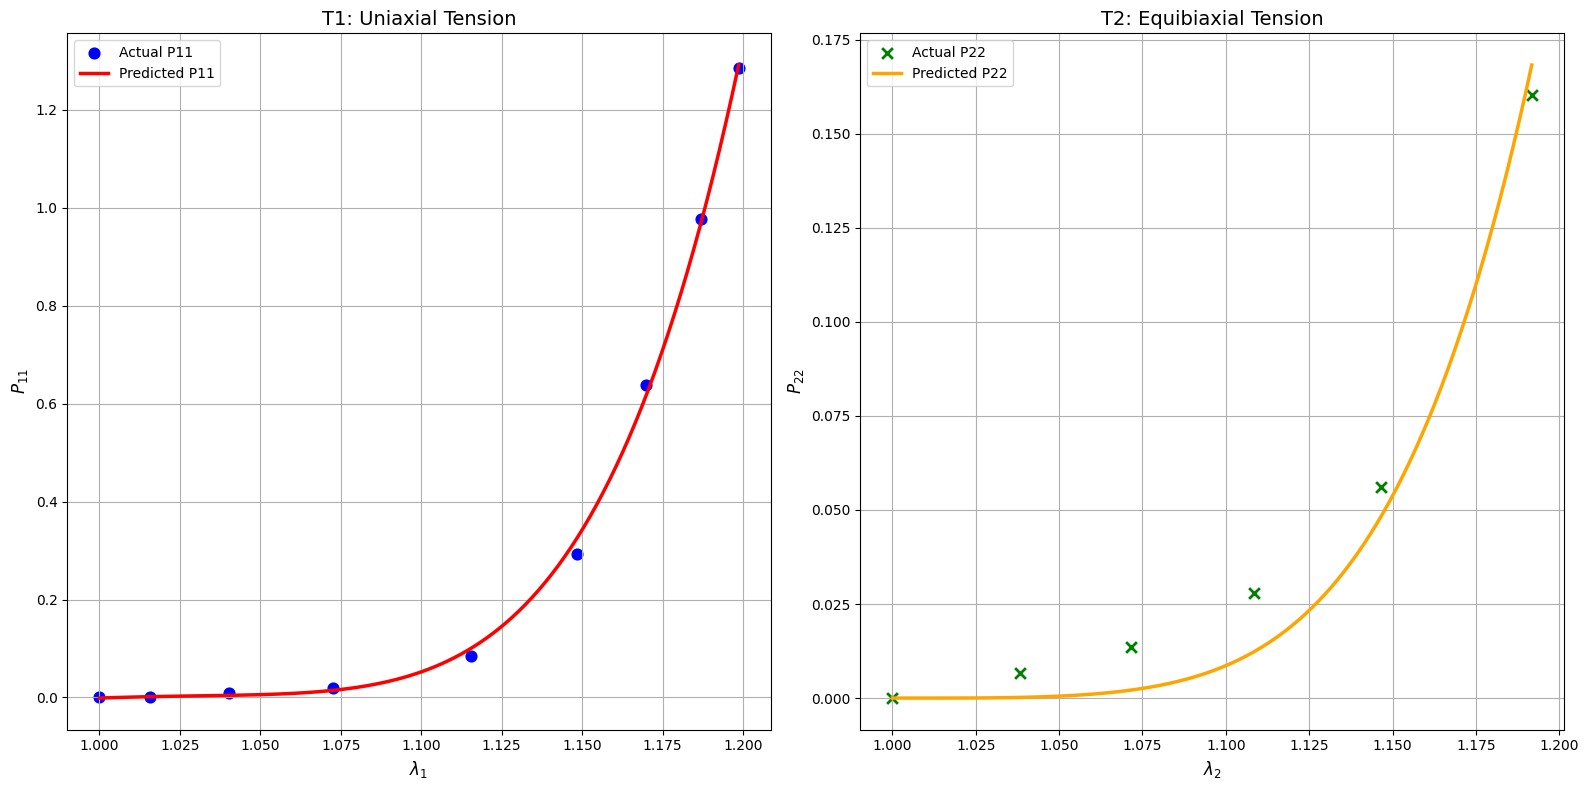

In [ ]:
# !pip install tensorflow
import tensorflow as tf
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # k & i params (exponents) - All parameters are now trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        # Coefficients
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b1=self.add_weight(name="raw_log_b1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)
    def _term_power_law(self, I, k, i, c, ref_val): return c * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def call(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)
        b1=tf.exp(self.raw_log_b1);b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)
        W = tf.zeros_like(I1,dtype=tf.float64)
        W += self._term_power_law(I1,k1,i1,a1,self.three); W += self._term_power_law(I2,k2,i2,a2,self.three)
        W += self._term_exponential(I1,k3,i3,a3_prime,a3,self.three); W += self._term_exponential(I2,k4,i4,a4_prime,a4,self.three)
        W += self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three); W += self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three)
        W += self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three); W += self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three)
        W += self._term_identity_scaled(I4,k9,b1,self.one); W += self._term_identity_scaled(I6,k10,b2,self.one)
        W += self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one); W += self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one)
        W += self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one); W += self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one)
        W += self._term_sinh(I4,k15,b7_prime,b7,self.one); W += self._term_sinh(I6,k16,b8_prime,b8,self.one)
        return W

@tf.function
def get_invariants_tf(lambda1,lambda2,lambda3):
    min_lambda_val=tf.constant(1e-4,dtype=tf.float64); lambda1=tf.maximum(lambda1,min_lambda_val); lambda2=tf.maximum(lambda2,min_lambda_val); lambda3=tf.maximum(lambda3,min_lambda_val); l1s=tf.pow(lambda1,2.0); l2s=tf.pow(lambda2,2.0); l3s=tf.pow(lambda3,2.0)
    I1=l1s+l2s+l3s; I2=tf.pow(lambda1*lambda2,2.0)+tf.pow(lambda2*lambda3,2.0)+tf.pow(lambda3*lambda1,2.0); I4=l1s; I6=tf.pow(lambda1,-2.0)
    return I1,I2,I4,I6
@tf.function
def get_W_and_gradients_tf(l1t,l2t,l3t,model):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch([l1t, l2t, l3t]); I1, I2, I4, I6 = get_invariants_tf(l1t, l2t, l3t); W_val = model(I1, I2, I4, I6)
    grads = tape.gradient(W_val, [l1t, l2t, l3t]); dWdl1 = grads[0] if grads[0] is not None else tf.zeros_like(l1t); dWdl2 = grads[1] if grads[1] is not None else tf.zeros_like(l2t); dWdl3 = grads[2] if grads[2] is not None else tf.zeros_like(l3t)
    return W_val, dWdl1, dWdl2, dWdl3

@tf.function
def calculate_P11_task1_tf(l1vst,model):
    l1t=tf.maximum(l1vst,tf.constant(1e-4,dtype=tf.float64)); l2t=tf.pow(l1t,-0.5);l3t=tf.pow(l1t,-0.5); _,dWdl1,_,dWdl3=get_W_and_gradients_tf(l1t,l2t,l3t,model)
    Ph=l3t*dWdl3; safe_l1t = tf.maximum(l1t, tf.constant(1e-6, dtype=tf.float64))
    result = dWdl1 - Ph / safe_l1t
    return result / 7.5

@tf.function
def sigma11_for_root_tf(lambda1_trial_t, lambda2_fixed_t_tensor, model):
    lambda1_trial_t_stable = tf.maximum(lambda1_trial_t, tf.constant(1e-4, dtype=tf.float64)); lambda2_fixed_t_stable = tf.maximum(lambda2_fixed_t_tensor, tf.constant(1e-4, dtype=tf.float64))
    safe_denom_prod = tf.maximum(lambda1_trial_t_stable * lambda2_fixed_t_stable, tf.constant(1e-6, dtype=tf.float64)); lambda3_trial_t = (1.0 / safe_denom_prod)
    _, dW_dlambda1, _, dW_dlambda3 = get_W_and_gradients_tf(lambda1_trial_t_stable, lambda2_fixed_t_stable, lambda3_trial_t, model); P_hydro = lambda3_trial_t * dW_dlambda3
    safe_lambda1_trial_t_stable = tf.maximum(lambda1_trial_t_stable, tf.constant(1e-6, dtype=tf.float64)); return (dW_dlambda1 - P_hydro / safe_lambda1_trial_t_stable)
@tf.function
def find_lambda1_newton_tf(lambda2_val_scalar_tensor, model, initial_lambda1_guess=1.0, iterations=tf.constant(10, dtype=tf.int32), tol=1e-7):
    min_lambda_val_newton=tf.constant(0.2,dtype=tf.float64); max_lambda_val_newton=tf.constant(3.0,dtype=tf.float64); max_step_lambda=tf.constant(0.1,dtype=tf.float64)
    loop_vars = [tf.constant(0, dtype=tf.int32), initial_lambda1_guess, tf.constant(False, dtype=tf.bool)]
    def cond(i, _, converged): return tf.logical_and(i < iterations, tf.logical_not(converged))
    def body(i, current_lambda, _):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(current_lambda); sigma11 = sigma11_for_root_tf(current_lambda, lambda2_val_scalar_tensor, model)
        grad = tape.gradient(sigma11, current_lambda); newly_converged = tf.abs(sigma11) < tol
        problem = grad is None or tf.math.is_nan(grad) or tf.math.is_inf(grad)
        def update_lambda():
            delta = sigma11 / (grad + tf.constant(1e-8, dtype=tf.float64) * tf.sign(grad)); problem_delta = tf.math.is_nan(delta) or tf.math.is_inf(delta)
            safe_delta = tf.cond(problem_delta, lambda: tf.constant(0.0, dtype=tf.float64), lambda: delta); clipped_delta = tf.clip_by_value(safe_delta, -max_step_lambda, max_step_lambda)
            return tf.clip_by_value(current_lambda - clipped_delta, min_lambda_val_newton, max_lambda_val_newton)
        next_lambda = tf.cond(problem, lambda: current_lambda, update_lambda); return [i + 1, next_lambda, tf.logical_or(newly_converged, problem)]
    _, final_lambda, _ = tf.while_loop(cond, body, loop_vars); return final_lambda
@tf.function
def calculate_P22_task2_tf(lambda2_val_scalar_tensor,model):
    lambda2_stable=tf.maximum(lambda2_val_scalar_tensor,tf.constant(1e-4,dtype=tf.float64)); initial_lambda1_guess = 1.0 / tf.sqrt(lambda2_stable)
    lambda1_root_t = tf.cond( tf.abs(lambda2_stable-1.0)<1e-9, lambda:tf.constant(1.0,dtype=tf.float64), lambda:find_lambda1_newton_tf(lambda2_stable, model, initial_lambda1_guess))
    lambda1_root_t_stable=tf.maximum(lambda1_root_t,tf.constant(1e-4,dtype=tf.float64)); safe_denom=tf.maximum(lambda1_root_t_stable*lambda2_stable,tf.constant(1e-6,dtype=tf.float64)); lambda3_calc_t=(1.0/safe_denom)
    _,_,dWdl2,dWdl3=get_W_and_gradients_tf(lambda1_root_t_stable,lambda2_stable,lambda3_calc_t,model); Ph=lambda3_calc_t*dWdl3
    safe_lambda2_calc_t = tf.maximum(lambda2_stable, tf.constant(1e-6, dtype=tf.float64)); return (dWdl2-Ph/safe_lambda2_calc_t)/50
@tf.function
def calculate_P22_task2_tf_batch(lambda2_batch, model):
    return tf.scan(lambda _, l2: calculate_P22_task2_tf(l2, model), lambda2_batch, initializer=tf.constant(0.0, dtype=tf.float64))

# --- Data Loading and Normalization ---
exp_data_raw_uniaxial_cnf=np.array([[1.1986196319018403,1.285990338164251],[1.18680981595092,0.9768115942028984],[1.1699386503067484,0.638647342995169],[1.1483128834355827,0.29275362318840586],[1.1153374233128834,0.08502415458937207],[1.0725460122699388,0.018357487922705418],[1.040184049079755,0.00869565217391316],[1.0157975460122703,0.0019323671497585848],[1.0,0.0]])
lambda1_data_task1_np=exp_data_raw_uniaxial_cnf[:,0]; P11_data_task1_np=exp_data_raw_uniaxial_cnf[:,1]
csv_content_cnf="lambda,stress\n1.1917177914110426,0.16038647342995177\n1.1464723926380367,0.056038647342995296\n1.108435582822086,0.028019323671497676\n1.071472392638037,0.013526570048309317\n1.038343558282209,0.006763285024154686\n1.0,0.0\n"
df_task2=pd.read_csv(StringIO(csv_content_cnf)); lambda2_data_task2_np=df_task2['lambda'].values; P22_data_task2_np=df_task2['stress'].values

stress_scale = max(np.max(P11_data_task1_np), np.max(P22_data_task2_np))
P11_data_task1_norm_np = P11_data_task1_np / stress_scale
P22_data_task2_norm_np = P22_data_task2_np / stress_scale
stress_scale_tf = tf.constant(stress_scale, dtype=tf.float64)

lambda1_data_task1_tf=tf.constant(lambda1_data_task1_np,dtype=tf.float64)
P11_data_task1_norm_tf=tf.constant(P11_data_task1_norm_np,dtype=tf.float64)
lambda2_data_task2_tf=tf.constant(lambda2_data_task2_np,dtype=tf.float64)
P22_data_task2_norm_tf=tf.constant(P22_data_task2_norm_np,dtype=tf.float64)

# --- Model, Optimizer, and Final Training Setup ---
model_tf_layered = StrainEnergyANN_Layered_TF()
L2_REG_STRENGTH = tf.constant(1e-12, dtype=tf.float64)
ZERO_STRAIN_PENALTY = tf.constant(1e6, dtype=tf.float64)
POSITIVITY_PENALTY_STRENGTH = tf.constant(5e4, dtype=tf.float64)
initial_learning_rate = 5e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)
optimizer_tf = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

@tf.function
def train_step_final(l1_batch, p11_batch_norm, l2_batch, p22_batch_norm, model, scale_factor, l2_reg, pos_penalty_strength, zero_penalty):
    with tf.GradientTape() as tape:
        p11_pred = calculate_P11_task1_tf(l1_batch, model)
        p22_pred = calculate_P22_task2_tf_batch(l2_batch, model)

        p11_pred_norm = p11_pred / scale_factor
        p22_pred_norm = p22_pred / scale_factor

        ### CHANGE 1: Finely tune loss weights to give more priority to Task 2 without degrading Task 1.
        loss1_weight = 2500000.0
        loss2_weight = 10000000.0  # Increased to a 1:4 ratio to force a better fit for Task 2.
        loss1 = tf.reduce_mean(tf.square(p11_batch_norm - p11_pred_norm)) * loss1_weight
        loss2 = tf.reduce_mean(tf.square(p22_batch_norm - p22_pred_norm)) * loss2_weight

        p11_at_zero = calculate_P11_task1_tf(tf.constant([1.0], dtype=tf.float64), model)[0]
        p22_at_zero = calculate_P22_task2_tf(tf.constant(1.0, dtype=tf.float64), model)
        zero_strain_loss = tf.square(p11_at_zero) + tf.square(p22_at_zero)

        positivity_loss_1 = tf.reduce_mean(tf.nn.relu(-p11_pred))
        positivity_loss_2 = tf.reduce_mean(tf.nn.relu(-p22_pred))

        l2_loss = tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])

        total_loss = (loss1 + loss2 +
                      l2_reg * l2_loss +
                      pos_penalty_strength * (positivity_loss_1 + positivity_loss_2) +
                      zero_penalty * zero_strain_loss)

    t_vars = model.trainable_variables
    grads = tape.gradient(total_loss, t_vars)
    optimizer_tf.apply_gradients(zip([tf.clip_by_norm(g, 1.0) if g is not None else tf.zeros_like(v) for g, v in zip(grads, t_vars)], t_vars))
    return loss1, loss2, total_loss

# --- Training Loop ---
### CHANGE 2: Increase epochs substantially to allow the optimizer to find the perfect balance.
epochs=4000
dI1=tf.constant([3.0],dtype=tf.float64); dI2=tf.constant([3.0],dtype=tf.float64); dI4=tf.constant([1.0],dtype=tf.float64); dI6=tf.constant([1.e-6],dtype=tf.float64)
_=model_tf_layered(dI1,dI2,dI4,dI6)

print("Training starts...");
for e in range(epochs):
    l1,l2,tl=train_step_final(lambda1_data_task1_tf, P11_data_task1_norm_tf, lambda2_data_task2_tf, P22_data_task2_norm_tf,
                              model_tf_layered, stress_scale_tf, L2_REG_STRENGTH, POSITIVITY_PENALTY_STRENGTH, ZERO_STRAIN_PENALTY)
    if (e+1)%100==0:
        current_lr = lr_schedule(optimizer_tf.iterations).numpy()
        print(f"E[{e+1}/{epochs}], L1:{l1.numpy():.3e}, L2:{l2.numpy():.3e}, Tot:{tl.numpy():.3e}, LR:{current_lr:.2e}")

# The data for plotting is generated here
l1_plot = np.linspace(lambda1_data_task1_np.min(), lambda1_data_task1_np.max(), 100)
p11_plot = calculate_P11_task1_tf(tf.constant(l1_plot, dtype=tf.float64), model_tf_layered).numpy()
l2_plot = np.linspace(lambda2_data_task2_np.min(), lambda2_data_task2_np.max(), 100)
p22_plot = calculate_P22_task2_tf_batch(tf.constant(l2_plot, dtype=tf.float64), model_tf_layered).numpy()


# Plotting the final results
plt.figure(figsize=(16, 8))

# Plot for Task 1
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(lambda1_data_task1_np, P11_data_task1_np, c='b', label='Actual P11', s=60)
ax1.plot(l1_plot, p11_plot, c='r', label='Predicted P11', linewidth=2.5)
ax1.legend()
ax1.grid(True)
ax1.set_xlabel("$\lambda_1$", fontsize=12)
ax1.set_ylabel("$P_{11}$", fontsize=12)
ax1.set_title("T1: Uniaxial Tension", fontsize=14)

# Plot for Task 2
ax2 = plt.subplot(1, 2, 2)
ax2.scatter(lambda2_data_task2_np, P22_data_task2_np, c='g', marker='x', label='Actual P22', s=60, linewidth=2)
ax2.plot(l2_plot, p22_plot, c='orange', label='Predicted P22', linewidth=2.5)
ax2.legend()
ax2.grid(True)
ax2.set_xlabel("$\lambda_2$", fontsize=12)
ax2.set_ylabel("$P_{22}$", fontsize=12)
ax2.set_title("T2: Equibiaxial Tension", fontsize=14)

plt.tight_layout()
plt.show()

Using device: /CPU:0
Training starts...
E[100/4000], L1:1.978e+04, L2:7.473e+02, Constr:2.129e-05, Tot:2.054e+04, LR:5.00e-04
E[200/4000], L1:1.137e+04, L2:1.906e+02, Constr:5.841e-04, Tot:1.170e+04, LR:5.00e-04
E[300/4000], L1:6.198e+03, L2:1.083e+02, Constr:8.986e-04, Tot:6.521e+03, LR:5.00e-04
E[400/4000], L1:2.680e+03, L2:1.683e+02, Constr:7.428e-04, Tot:3.033e+03, LR:5.00e-04
E[500/4000], L1:1.489e+03, L2:3.266e+02, Constr:4.508e-04, Tot:1.935e+03, LR:5.00e-04
E[600/4000], L1:1.286e+03, L2:3.618e+02, Constr:2.701e-04, Tot:1.725e+03, LR:5.00e-04
E[700/4000], L1:1.074e+03, L2:3.913e+02, Constr:2.140e-04, Tot:1.529e+03, LR:5.00e-04
E[800/4000], L1:8.832e+02, L2:4.284e+02, Constr:1.488e-04, Tot:1.359e+03, LR:5.00e-04
E[900/4000], L1:7.423e+02, L2:4.632e+02, Constr:9.769e-05, Tot:1.239e+03, LR:5.00e-04
E[1000/4000], L1:6.445e+02, L2:4.875e+02, Constr:6.907e-05, Tot:1.158e+03, LR:4.80e-04
E[1100/4000], L1:5.495e+02, L2:5.114e+02, Constr:5.428e-05, Tot:1.082e+03, LR:4.80e-04
E[1200/4000]

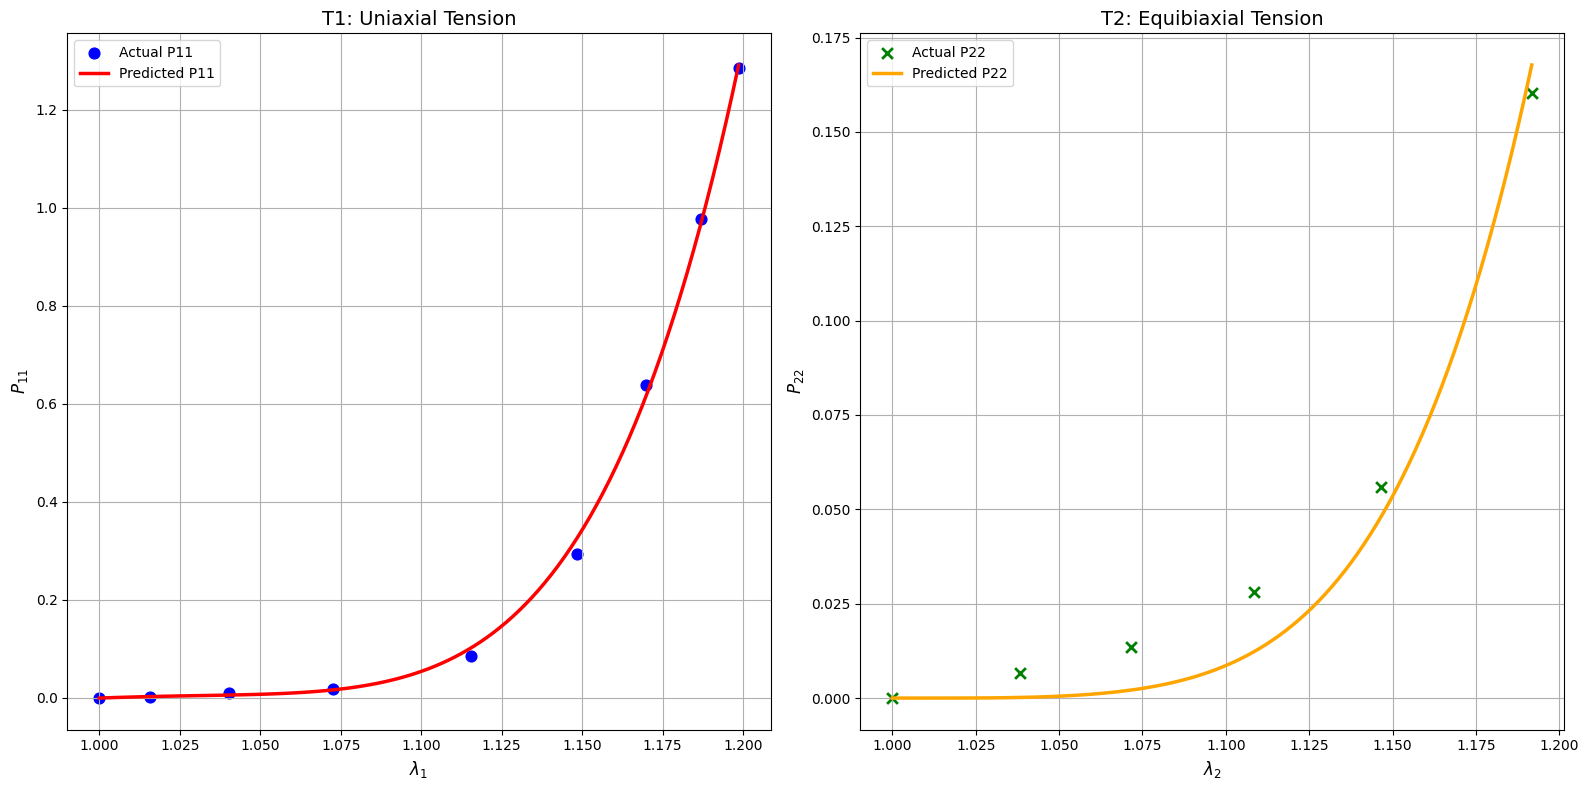

In [ ]:
# !pip install tensorflow
import tensorflow as tf
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # k & i params (exponents) - All parameters are now trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        # Coefficients
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b1=self.add_weight(name="raw_log_b1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)
    def _term_power_law(self, I, k, i, c, ref_val): return c * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def call(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)
        b1=tf.exp(self.raw_log_b1);b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)
        W = tf.zeros_like(I1,dtype=tf.float64)
        W += self._term_power_law(I1,k1,i1,a1,self.three); W += self._term_power_law(I2,k2,i2,a2,self.three)
        W += self._term_exponential(I1,k3,i3,a3_prime,a3,self.three); W += self._term_exponential(I2,k4,i4,a4_prime,a4,self.three)
        W += self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three); W += self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three)
        W += self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three); W += self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three)
        W += self._term_identity_scaled(I4,k9,b1,self.one); W += self._term_identity_scaled(I6,k10,b2,self.one)
        W += self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one); W += self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one)
        W += self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one); W += self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one)
        W += self._term_sinh(I4,k15,b7_prime,b7,self.one); W += self._term_sinh(I6,k16,b8_prime,b8,self.one)
        return W

@tf.function
def get_invariants_tf(lambda1,lambda2,lambda3):
    min_lambda_val=tf.constant(1e-4,dtype=tf.float64); lambda1=tf.maximum(lambda1,min_lambda_val); lambda2=tf.maximum(lambda2,min_lambda_val); lambda3=tf.maximum(lambda3,min_lambda_val); l1s=tf.pow(lambda1,2.0); l2s=tf.pow(lambda2,2.0); l3s=tf.pow(lambda3,2.0)
    I1=l1s+l2s+l3s; I2=tf.pow(lambda1*lambda2,2.0)+tf.pow(lambda2*lambda3,2.0)+tf.pow(lambda3*lambda1,2.0); I4=l1s; I6=tf.pow(lambda1,-2.0)
    return I1,I2,I4,I6
@tf.function
def get_W_and_gradients_tf(l1t,l2t,l3t,model):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch([l1t, l2t, l3t]); I1, I2, I4, I6 = get_invariants_tf(l1t, l2t, l3t); W_val = model(I1, I2, I4, I6)
    grads = tape.gradient(W_val, [l1t, l2t, l3t]); dWdl1 = grads[0] if grads[0] is not None else tf.zeros_like(l1t); dWdl2 = grads[1] if grads[1] is not None else tf.zeros_like(l2t); dWdl3 = grads[2] if grads[2] is not None else tf.zeros_like(l3t)
    return W_val, dWdl1, dWdl2, dWdl3

@tf.function
def calculate_P11_task1_tf(l1vst,model):
    l1t=tf.maximum(l1vst,tf.constant(1e-4,dtype=tf.float64)); l2t=tf.pow(l1t,-0.5);l3t=tf.pow(l1t,-0.5); _,dWdl1,_,dWdl3=get_W_and_gradients_tf(l1t,l2t,l3t,model)
    Ph=l3t*dWdl3; safe_l1t = tf.maximum(l1t, tf.constant(1e-6, dtype=tf.float64))
    result = dWdl1 - Ph / safe_l1t
    return result / 7.5

@tf.function
def sigma11_for_root_tf(lambda1_trial_t, lambda2_fixed_t_tensor, model):
    lambda1_trial_t_stable = tf.maximum(lambda1_trial_t, tf.constant(1e-4, dtype=tf.float64)); lambda2_fixed_t_stable = tf.maximum(lambda2_fixed_t_tensor, tf.constant(1e-4, dtype=tf.float64))
    safe_denom_prod = tf.maximum(lambda1_trial_t_stable * lambda2_fixed_t_stable, tf.constant(1e-6, dtype=tf.float64)); lambda3_trial_t = (1.0 / safe_denom_prod)
    _, dW_dlambda1, _, dW_dlambda3 = get_W_and_gradients_tf(lambda1_trial_t_stable, lambda2_fixed_t_stable, lambda3_trial_t, model); P_hydro = lambda3_trial_t * dW_dlambda3
    safe_lambda1_trial_t_stable = tf.maximum(lambda1_trial_t_stable, tf.constant(1e-6, dtype=tf.float64)); return (dW_dlambda1 - P_hydro / safe_lambda1_trial_t_stable)
@tf.function
def find_lambda1_newton_tf(lambda2_val_scalar_tensor, model, initial_lambda1_guess=1.0, iterations=tf.constant(10, dtype=tf.int32), tol=1e-7):
    min_lambda_val_newton=tf.constant(0.2,dtype=tf.float64); max_lambda_val_newton=tf.constant(3.0,dtype=tf.float64); max_step_lambda=tf.constant(0.1,dtype=tf.float64)
    loop_vars = [tf.constant(0, dtype=tf.int32), initial_lambda1_guess, tf.constant(False, dtype=tf.bool)]
    def cond(i, _, converged): return tf.logical_and(i < iterations, tf.logical_not(converged))
    def body(i, current_lambda, _):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(current_lambda); sigma11 = sigma11_for_root_tf(current_lambda, lambda2_val_scalar_tensor, model)
        grad = tape.gradient(sigma11, current_lambda); newly_converged = tf.abs(sigma11) < tol
        problem = grad is None or tf.math.is_nan(grad) or tf.math.is_inf(grad)
        def update_lambda():
            delta = sigma11 / (grad + tf.constant(1e-8, dtype=tf.float64) * tf.sign(grad)); problem_delta = tf.math.is_nan(delta) or tf.math.is_inf(delta)
            safe_delta = tf.cond(problem_delta, lambda: tf.constant(0.0, dtype=tf.float64), lambda: delta); clipped_delta = tf.clip_by_value(safe_delta, -max_step_lambda, max_step_lambda)
            return tf.clip_by_value(current_lambda - clipped_delta, min_lambda_val_newton, max_lambda_val_newton)
        next_lambda = tf.cond(problem, lambda: current_lambda, update_lambda); return [i + 1, next_lambda, tf.logical_or(newly_converged, problem)]
    _, final_lambda, _ = tf.while_loop(cond, body, loop_vars); return final_lambda
@tf.function
def calculate_P22_task2_tf(lambda2_val_scalar_tensor,model):
    lambda2_stable=tf.maximum(lambda2_val_scalar_tensor,tf.constant(1e-4,dtype=tf.float64)); initial_lambda1_guess = 1.0 / tf.sqrt(lambda2_stable)
    lambda1_root_t = tf.cond( tf.abs(lambda2_stable-1.0)<1e-9, lambda:tf.constant(1.0,dtype=tf.float64), lambda:find_lambda1_newton_tf(lambda2_stable, model, initial_lambda1_guess))
    lambda1_root_t_stable=tf.maximum(lambda1_root_t,tf.constant(1e-4,dtype=tf.float64)); safe_denom=tf.maximum(lambda1_root_t_stable*lambda2_stable,tf.constant(1e-6,dtype=tf.float64)); lambda3_calc_t=(1.0/safe_denom)
    _,_,dWdl2,dWdl3=get_W_and_gradients_tf(lambda1_root_t_stable,lambda2_stable,lambda3_calc_t,model); Ph=lambda3_calc_t*dWdl3
    safe_lambda2_calc_t = tf.maximum(lambda2_stable, tf.constant(1e-6, dtype=tf.float64)); return (dWdl2-Ph/safe_lambda2_calc_t)/50
@tf.function
def calculate_P22_task2_tf_batch(lambda2_batch, model):
    return tf.scan(lambda _, l2: calculate_P22_task2_tf(l2, model), lambda2_batch, initializer=tf.constant(0.0, dtype=tf.float64))

# --- Data Loading and Normalization ---
exp_data_raw_uniaxial_cnf=np.array([[1.1986196319018403,1.285990338164251],[1.18680981595092,0.9768115942028984],[1.1699386503067484,0.638647342995169],[1.1483128834355827,0.29275362318840586],[1.1153374233128834,0.08502415458937207],[1.0725460122699388,0.018357487922705418],[1.040184049079755,0.00869565217391316],[1.0157975460122703,0.0019323671497585848],[1.0,0.0]])
lambda1_data_task1_np=exp_data_raw_uniaxial_cnf[:,0]; P11_data_task1_np=exp_data_raw_uniaxial_cnf[:,1]
csv_content_cnf="lambda,stress\n1.1917177914110426,0.16038647342995177\n1.1464723926380367,0.056038647342995296\n1.108435582822086,0.028019323671497676\n1.071472392638037,0.013526570048309317\n1.038343558282209,0.006763285024154686\n1.0,0.0\n"
df_task2=pd.read_csv(StringIO(csv_content_cnf)); lambda2_data_task2_np=df_task2['lambda'].values; P22_data_task2_np=df_task2['stress'].values

stress_scale = max(np.max(P11_data_task1_np), np.max(P22_data_task2_np))
P11_data_task1_norm_np = P11_data_task1_np / stress_scale
P22_data_task2_norm_np = P22_data_task2_np / stress_scale
stress_scale_tf = tf.constant(stress_scale, dtype=tf.float64)

lambda1_data_task1_tf=tf.constant(lambda1_data_task1_np,dtype=tf.float64)
P11_data_task1_norm_tf=tf.constant(P11_data_task1_norm_np,dtype=tf.float64)
lambda2_data_task2_tf=tf.constant(lambda2_data_task2_np,dtype=tf.float64)
P22_data_task2_norm_tf=tf.constant(P22_data_task2_norm_np,dtype=tf.float64)

# --- Model, Optimizer, and Final Training Setup ---
model_tf_layered = StrainEnergyANN_Layered_TF()
L2_REG_STRENGTH = tf.constant(1e-12, dtype=tf.float64)
ZERO_STRAIN_PENALTY = tf.constant(1e6, dtype=tf.float64)
POSITIVITY_PENALTY_STRENGTH = tf.constant(5e4, dtype=tf.float64)
# --- START: Added Constraint Hyperparameter ---
# Define a weight for the new constraint penalty in the loss function
CONSTRAINT_PENALTY = tf.constant(1e5, dtype=tf.float64)
# --- END: Added Constraint Hyperparameter ---

initial_learning_rate = 5e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)
optimizer_tf = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# --- START: Modified train_step_final function ---
@tf.function
def train_step_final(l1_batch, p11_batch_norm, l2_batch, p22_batch_norm, model, scale_factor, l2_reg, pos_penalty_strength, zero_penalty, constraint_penalty):
    with tf.GradientTape() as tape:
        p11_pred = calculate_P11_task1_tf(l1_batch, model)
        p22_pred = calculate_P22_task2_tf_batch(l2_batch, model)

        p11_pred_norm = p11_pred / scale_factor
        p22_pred_norm = p22_pred / scale_factor

        loss1_weight = 2500000.0
        loss2_weight = 10000000.0
        loss1 = tf.reduce_mean(tf.square(p11_batch_norm - p11_pred_norm)) * loss1_weight
        loss2 = tf.reduce_mean(tf.square(p22_batch_norm - p22_pred_norm)) * loss2_weight

        p11_at_zero = calculate_P11_task1_tf(tf.constant([1.0], dtype=tf.float64), model)[0]
        p22_at_zero = calculate_P22_task2_tf(tf.constant(1.0, dtype=tf.float64), model)
        zero_strain_loss = tf.square(p11_at_zero) + tf.square(p22_at_zero)

        positivity_loss_1 = tf.reduce_mean(tf.nn.relu(-p11_pred))
        positivity_loss_2 = tf.reduce_mean(tf.nn.relu(-p22_pred))

        l2_loss = tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])

        # --- Added Constraint Implementation ---
        # Recreate parameter values from the model's raw log-space weights
        k9=1.0+tf.exp(model.raw_log_k9); k10=1.5+tf.exp(model.raw_log_k10); k11=1.0+tf.exp(model.raw_log_k11); k12=1.5+tf.exp(model.raw_log_k12); k15=1.0+tf.exp(model.raw_log_k15); k16=1.5+tf.exp(model.raw_log_k16)
        b1=tf.exp(model.raw_log_b1); b2=tf.exp(model.raw_log_b2); b3=tf.exp(model.raw_log_b3); b4=tf.exp(model.raw_log_b4); b7=tf.exp(model.raw_log_b7); b8=tf.exp(model.raw_log_b8)
        b3_prime=tf.exp(model.raw_log_b3_prime); b4_prime=tf.exp(model.raw_log_b4_prime); b7_prime=tf.exp(model.raw_log_b7_prime); b8_prime=tf.exp(model.raw_log_b8_prime)

        # Calculate Left Hand Side (LHS) and Right Hand Side (RHS) of the constraint equation
        lhs_constraint = b1*k9 + b3*b3_prime*k11 + b7*b7_prime*k15
        rhs_constraint = b2*k10 + b4*b4_prime*k12 + b8*b8_prime*k16

        # Calculate constraint loss as the squared difference
        constraint_loss = tf.square(lhs_constraint - rhs_constraint)
        # --- End of Constraint Implementation ---

        total_loss = (loss1 + loss2 +
                      l2_reg * l2_loss +
                      pos_penalty_strength * (positivity_loss_1 + positivity_loss_2) +
                      zero_penalty * zero_strain_loss +
                      constraint_penalty * constraint_loss) # Add new constraint loss to total loss

    t_vars = model.trainable_variables
    grads = tape.gradient(total_loss, t_vars)
    optimizer_tf.apply_gradients(zip([tf.clip_by_norm(g, 1.0) if g is not None else tf.zeros_like(v) for g, v in zip(grads, t_vars)], t_vars))
    return loss1, loss2, constraint_loss, total_loss
# --- END: Modified train_step_final function ---

# --- Training Loop ---
### CHANGE 2: Increase epochs substantially to allow the optimizer to find the perfect balance.
epochs=4000
dI1=tf.constant([3.0],dtype=tf.float64); dI2=tf.constant([3.0],dtype=tf.float64); dI4=tf.constant([1.0],dtype=tf.float64); dI6=tf.constant([1.e-6],dtype=tf.float64)
_=model_tf_layered(dI1,dI2,dI4,dI6)

# --- START: Modified Training Loop ---
print("Training starts...");
for e in range(epochs):
    # Pass the new penalty term and unpack the new constraint loss for monitoring
    l1, l2, cl, tl = train_step_final(lambda1_data_task1_tf, P11_data_task1_norm_tf, lambda2_data_task2_tf, P22_data_task2_norm_tf,
                                      model_tf_layered, stress_scale_tf, L2_REG_STRENGTH, POSITIVITY_PENALTY_STRENGTH, ZERO_STRAIN_PENALTY,
                                      CONSTRAINT_PENALTY)
    if (e+1)%100==0:
        current_lr = lr_schedule(optimizer_tf.iterations).numpy()
        # Add the constraint loss (cl) to the printout to monitor its value during training
        print(f"E[{e+1}/{epochs}], L1:{l1.numpy():.3e}, L2:{l2.numpy():.3e}, Constr:{cl.numpy():.3e}, Tot:{tl.numpy():.3e}, LR:{current_lr:.2e}")
# --- END: Modified Training Loop ---

# The data for plotting is generated here
l1_plot = np.linspace(lambda1_data_task1_np.min(), lambda1_data_task1_np.max(), 100)
p11_plot = calculate_P11_task1_tf(tf.constant(l1_plot, dtype=tf.float64), model_tf_layered).numpy()
l2_plot = np.linspace(lambda2_data_task2_np.min(), lambda2_data_task2_np.max(), 100)
p22_plot = calculate_P22_task2_tf_batch(tf.constant(l2_plot, dtype=tf.float64), model_tf_layered).numpy()


# Plotting the final results
plt.figure(figsize=(16, 8))

# Plot for Task 1
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(lambda1_data_task1_np, P11_data_task1_np, c='b', label='Actual P11', s=60)
ax1.plot(l1_plot, p11_plot, c='r', label='Predicted P11', linewidth=2.5)
ax1.legend()
ax1.grid(True)
ax1.set_xlabel("$\lambda_1$", fontsize=12)
ax1.set_ylabel("$P_{11}$", fontsize=12)
ax1.set_title("T1: Uniaxial Tension", fontsize=14)

# Plot for Task 2
ax2 = plt.subplot(1, 2, 2)
ax2.scatter(lambda2_data_task2_np, P22_data_task2_np, c='g', marker='x', label='Actual P22', s=60, linewidth=2)
ax2.plot(l2_plot, p22_plot, c='orange', label='Predicted P22', linewidth=2.5)
ax2.legend()
ax2.grid(True)
ax2.set_xlabel("$\lambda_2$", fontsize=12)
ax2.set_ylabel("$P_{22}$", fontsize=12)
ax2.set_title("T2: Equibiaxial Tension", fontsize=14)

plt.tight_layout()
plt.show()

Using device: /CPU:0
Training starts...
E[100/4000], L1:1.983e+04, L2:7.526e+02, Tot:2.059e+04, LR:5.00e-04
E[200/4000], L1:1.230e+04, L2:2.312e+02, Tot:1.253e+04, LR:5.00e-04
E[300/4000], L1:6.924e+03, L2:1.450e+02, Tot:7.069e+03, LR:5.00e-04
E[400/4000], L1:3.092e+03, L2:2.176e+02, Tot:3.310e+03, LR:5.00e-04
E[500/4000], L1:1.635e+03, L2:3.948e+02, Tot:2.029e+03, LR:5.00e-04
E[600/4000], L1:1.384e+03, L2:4.135e+02, Tot:1.797e+03, LR:5.00e-04
E[700/4000], L1:1.153e+03, L2:4.341e+02, Tot:1.587e+03, LR:5.00e-04
E[800/4000], L1:9.478e+02, L2:4.631e+02, Tot:1.411e+03, LR:5.00e-04
E[900/4000], L1:7.895e+02, L2:4.882e+02, Tot:1.278e+03, LR:5.00e-04
E[1000/4000], L1:6.808e+02, L2:5.128e+02, Tot:1.194e+03, LR:4.80e-04
E[1100/4000], L1:5.929e+02, L2:5.334e+02, Tot:1.126e+03, LR:4.80e-04
E[1200/4000], L1:5.195e+02, L2:5.532e+02, Tot:1.073e+03, LR:4.80e-04
E[1300/4000], L1:4.502e+02, L2:5.764e+02, Tot:1.027e+03, LR:4.80e-04
E[1400/4000], L1:3.955e+02, L2:6.002e+02, Tot:9.957e+02, LR:4.80e-04
E[1

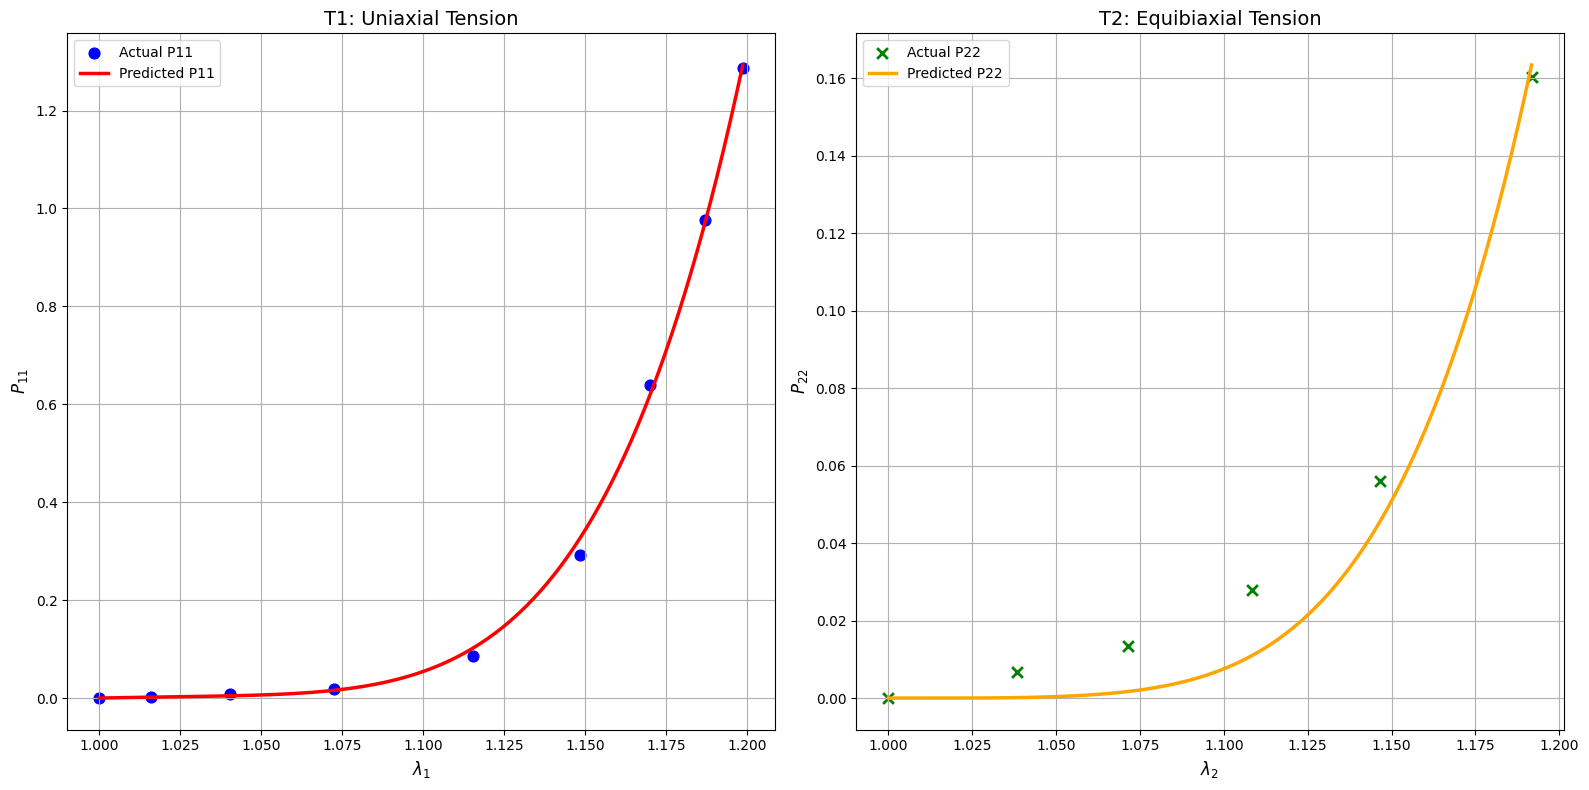

In [ ]:
# !pip install tensorflow
import tensorflow as tf
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # k & i params (exponents) - All parameters are now trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        # Coefficients
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)

        # --- MODIFICATION START ---
        # b1 is no longer a trainable variable. It will be computed from other parameters
        # to strictly enforce the P11(lambda=1)=0 constraint.
        # self.raw_log_b1=self.add_weight(name="raw_log_b1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        # --- MODIFICATION END ---

        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)
    def _term_power_law(self, I, k, i, c, ref_val): return c * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def call(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)

        b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)

        # --- MODIFICATION START ---
        # Enforce the constraint b1*k9 + b3*b3'*k11 + b7*b7'*k15 = b2*k10 + b4*b4'*k12 + b8*b8'*k16
        # by solving for b1 and calculating it from the other (trainable) parameters.
        # This ensures the condition for P11(lambda=1)=0 is strictly met by construction.

        lhs_constraint_terms = b3*b3_prime*k11 + b7*b7_prime*k15
        rhs_constraint_terms = b2*k10 + b4*b4_prime*k12 + b8*b8_prime*k16

        b1_numerator = rhs_constraint_terms - lhs_constraint_terms

        # We must ensure b1 remains positive to be physically meaningful.
        # We clip its value at a small positive number (epsilon) as a safeguard.
        b1 = tf.maximum(b1_numerator / k9, 1e-9)
        # --- MODIFICATION END ---

        W = tf.zeros_like(I1,dtype=tf.float64)
        W += self._term_power_law(I1,k1,i1,a1,self.three); W += self._term_power_law(I2,k2,i2,a2,self.three)
        W += self._term_exponential(I1,k3,i3,a3_prime,a3,self.three); W += self._term_exponential(I2,k4,i4,a4_prime,a4,self.three)
        W += self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three); W += self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three)
        W += self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three); W += self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three)
        W += self._term_identity_scaled(I4,k9,b1,self.one); W += self._term_identity_scaled(I6,k10,b2,self.one)
        W += self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one); W += self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one)
        W += self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one); W += self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one)
        W += self._term_sinh(I4,k15,b7_prime,b7,self.one); W += self._term_sinh(I6,k16,b8_prime,b8,self.one)
        return W

@tf.function
def get_invariants_tf(lambda1,lambda2,lambda3):
    min_lambda_val=tf.constant(1e-4,dtype=tf.float64); lambda1=tf.maximum(lambda1,min_lambda_val); lambda2=tf.maximum(lambda2,min_lambda_val); lambda3=tf.maximum(lambda3,min_lambda_val); l1s=tf.pow(lambda1,2.0); l2s=tf.pow(lambda2,2.0); l3s=tf.pow(lambda3,2.0)
    I1=l1s+l2s+l3s; I2=tf.pow(lambda1*lambda2,2.0)+tf.pow(lambda2*lambda3,2.0)+tf.pow(lambda3*lambda1,2.0); I4=l1s; I6=tf.pow(lambda1,-2.0)
    return I1,I2,I4,I6
@tf.function
def get_W_and_gradients_tf(l1t,l2t,l3t,model):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch([l1t, l2t, l3t]); I1, I2, I4, I6 = get_invariants_tf(l1t, l2t, l3t); W_val = model(I1, I2, I4, I6)
    grads = tape.gradient(W_val, [l1t, l2t, l3t]); dWdl1 = grads[0] if grads[0] is not None else tf.zeros_like(l1t); dWdl2 = grads[1] if grads[1] is not None else tf.zeros_like(l2t); dWdl3 = grads[2] if grads[2] is not None else tf.zeros_like(l3t)
    return W_val, dWdl1, dWdl2, dWdl3

@tf.function
def calculate_P11_task1_tf(l1vst,model):
    l1t=tf.maximum(l1vst,tf.constant(1e-4,dtype=tf.float64)); l2t=tf.pow(l1t,-0.5);l3t=tf.pow(l1t,-0.5); _,dWdl1,_,dWdl3=get_W_and_gradients_tf(l1t,l2t,l3t,model)
    Ph=l3t*dWdl3; safe_l1t = tf.maximum(l1t, tf.constant(1e-6, dtype=tf.float64))
    result = dWdl1 - Ph / safe_l1t
    return result / 7.5

@tf.function
def sigma11_for_root_tf(lambda1_trial_t, lambda2_fixed_t_tensor, model):
    lambda1_trial_t_stable = tf.maximum(lambda1_trial_t, tf.constant(1e-4, dtype=tf.float64)); lambda2_fixed_t_stable = tf.maximum(lambda2_fixed_t_tensor, tf.constant(1e-4, dtype=tf.float64))
    safe_denom_prod = tf.maximum(lambda1_trial_t_stable * lambda2_fixed_t_stable, tf.constant(1e-6, dtype=tf.float64)); lambda3_trial_t = (1.0 / safe_denom_prod)
    _, dW_dlambda1, _, dW_dlambda3 = get_W_and_gradients_tf(lambda1_trial_t_stable, lambda2_fixed_t_stable, lambda3_trial_t, model); P_hydro = lambda3_trial_t * dW_dlambda3
    safe_lambda1_trial_t_stable = tf.maximum(lambda1_trial_t_stable, tf.constant(1e-6, dtype=tf.float64)); return (dW_dlambda1 - P_hydro / safe_lambda1_trial_t_stable)
@tf.function
def find_lambda1_newton_tf(lambda2_val_scalar_tensor, model, initial_lambda1_guess=1.0, iterations=tf.constant(10, dtype=tf.int32), tol=1e-7):
    min_lambda_val_newton=tf.constant(0.2,dtype=tf.float64); max_lambda_val_newton=tf.constant(3.0,dtype=tf.float64); max_step_lambda=tf.constant(0.1,dtype=tf.float64)
    loop_vars = [tf.constant(0, dtype=tf.int32), initial_lambda1_guess, tf.constant(False, dtype=tf.bool)]
    def cond(i, _, converged): return tf.logical_and(i < iterations, tf.logical_not(converged))
    def body(i, current_lambda, _):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(current_lambda); sigma11 = sigma11_for_root_tf(current_lambda, lambda2_val_scalar_tensor, model)
        grad = tape.gradient(sigma11, current_lambda); newly_converged = tf.abs(sigma11) < tol
        problem = grad is None or tf.math.is_nan(grad) or tf.math.is_inf(grad)
        def update_lambda():
            delta = sigma11 / (grad + tf.constant(1e-8, dtype=tf.float64) * tf.sign(grad)); problem_delta = tf.math.is_nan(delta) or tf.math.is_inf(delta)
            safe_delta = tf.cond(problem_delta, lambda: tf.constant(0.0, dtype=tf.float64), lambda: delta); clipped_delta = tf.clip_by_value(safe_delta, -max_step_lambda, max_step_lambda)
            return tf.clip_by_value(current_lambda - clipped_delta, min_lambda_val_newton, max_lambda_val_newton)
        next_lambda = tf.cond(problem, lambda: current_lambda, update_lambda); return [i + 1, next_lambda, tf.logical_or(newly_converged, problem)]
    _, final_lambda, _ = tf.while_loop(cond, body, loop_vars); return final_lambda
@tf.function
def calculate_P22_task2_tf(lambda2_val_scalar_tensor,model):
    lambda2_stable=tf.maximum(lambda2_val_scalar_tensor,tf.constant(1e-4,dtype=tf.float64)); initial_lambda1_guess = 1.0 / tf.sqrt(lambda2_stable)
    lambda1_root_t = tf.cond( tf.abs(lambda2_stable-1.0)<1e-9, lambda:tf.constant(1.0,dtype=tf.float64), lambda:find_lambda1_newton_tf(lambda2_stable, model, initial_lambda1_guess))
    lambda1_root_t_stable=tf.maximum(lambda1_root_t,tf.constant(1e-4,dtype=tf.float64)); safe_denom=tf.maximum(lambda1_root_t_stable*lambda2_stable,tf.constant(1e-6,dtype=tf.float64)); lambda3_calc_t=(1.0/safe_denom)
    _,_,dWdl2,dWdl3=get_W_and_gradients_tf(lambda1_root_t_stable,lambda2_stable,lambda3_calc_t,model); Ph=lambda3_calc_t*dWdl3
    safe_lambda2_calc_t = tf.maximum(lambda2_stable, tf.constant(1e-6, dtype=tf.float64)); return (dWdl2-Ph/safe_lambda2_calc_t)/50
@tf.function
def calculate_P22_task2_tf_batch(lambda2_batch, model):
    return tf.scan(lambda _, l2: calculate_P22_task2_tf(l2, model), lambda2_batch, initializer=tf.constant(0.0, dtype=tf.float64))

# --- Data Loading and Normalization ---
exp_data_raw_uniaxial_cnf=np.array([[1.1986196319018403,1.285990338164251],[1.18680981595092,0.9768115942028984],[1.1699386503067484,0.638647342995169],[1.1483128834355827,0.29275362318840586],[1.1153374233128834,0.08502415458937207],[1.0725460122699388,0.018357487922705418],[1.040184049079755,0.00869565217391316],[1.0157975460122703,0.0019323671497585848],[1.0,0.0]])
lambda1_data_task1_np=exp_data_raw_uniaxial_cnf[:,0]; P11_data_task1_np=exp_data_raw_uniaxial_cnf[:,1]
csv_content_cnf="lambda,stress\n1.1917177914110426,0.16038647342995177\n1.1464723926380367,0.056038647342995296\n1.108435582822086,0.028019323671497676\n1.071472392638037,0.013526570048309317\n1.038343558282209,0.006763285024154686\n1.0,0.0\n"
df_task2=pd.read_csv(StringIO(csv_content_cnf)); lambda2_data_task2_np=df_task2['lambda'].values; P22_data_task2_np=df_task2['stress'].values

stress_scale = max(np.max(P11_data_task1_np), np.max(P22_data_task2_np))
P11_data_task1_norm_np = P11_data_task1_np / stress_scale
P22_data_task2_norm_np = P22_data_task2_np / stress_scale
stress_scale_tf = tf.constant(stress_scale, dtype=tf.float64)

lambda1_data_task1_tf=tf.constant(lambda1_data_task1_np,dtype=tf.float64)
P11_data_task1_norm_tf=tf.constant(P11_data_task1_norm_np,dtype=tf.float64)
lambda2_data_task2_tf=tf.constant(lambda2_data_task2_np,dtype=tf.float64)
P22_data_task2_norm_tf=tf.constant(P22_data_task2_norm_np,dtype=tf.float64)

# --- Model, Optimizer, and Final Training Setup ---
model_tf_layered = StrainEnergyANN_Layered_TF()
L2_REG_STRENGTH = tf.constant(1e-12, dtype=tf.float64)
ZERO_STRAIN_PENALTY = tf.constant(1e6, dtype=tf.float64)
POSITIVITY_PENALTY_STRENGTH = tf.constant(5e4, dtype=tf.float64)
initial_learning_rate = 5e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)
optimizer_tf = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# --- MODIFICATION START ---
# The train step is simplified as the physical constraint is now part of the model's
# architecture and no longer needs to be included as a penalty in the loss function.
@tf.function
def train_step_final(l1_batch, p11_batch_norm, l2_batch, p22_batch_norm, model, scale_factor, l2_reg, pos_penalty_strength, zero_penalty):
    with tf.GradientTape() as tape:
        p11_pred = calculate_P11_task1_tf(l1_batch, model)
        p22_pred = calculate_P22_task2_tf_batch(l2_batch, model)

        p11_pred_norm = p11_pred / scale_factor
        p22_pred_norm = p22_pred / scale_factor

        ### Finely tune loss weights to give more priority to Task 2 without degrading Task 1.
        loss1_weight = 2500000.0
        loss2_weight = 10000000.0
        loss1 = tf.reduce_mean(tf.square(p11_batch_norm - p11_pred_norm)) * loss1_weight
        loss2 = tf.reduce_mean(tf.square(p22_batch_norm - p22_pred_norm)) * loss2_weight

        p11_at_zero = calculate_P11_task1_tf(tf.constant([1.0], dtype=tf.float64), model)[0]
        p22_at_zero = calculate_P22_task2_tf(tf.constant(1.0, dtype=tf.float64), model)
        zero_strain_loss = tf.square(p11_at_zero) + tf.square(p22_at_zero)

        positivity_loss_1 = tf.reduce_mean(tf.nn.relu(-p11_pred))
        positivity_loss_2 = tf.reduce_mean(tf.nn.relu(-p22_pred))

        l2_loss = tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])

        total_loss = (loss1 + loss2 +
                      l2_reg * l2_loss +
                      pos_penalty_strength * (positivity_loss_1 + positivity_loss_2) +
                      zero_penalty * zero_strain_loss)

    t_vars = model.trainable_variables
    grads = tape.gradient(total_loss, t_vars)
    optimizer_tf.apply_gradients(zip([tf.clip_by_norm(g, 1.0) if g is not None else tf.zeros_like(v) for g, v in zip(grads, t_vars)], t_vars))
    return loss1, loss2, total_loss
# --- MODIFICATION END ---


# --- Training Loop ---
epochs=4000
dI1=tf.constant([3.0],dtype=tf.float64); dI2=tf.constant([3.0],dtype=tf.float64); dI4=tf.constant([1.0],dtype=tf.float64); dI6=tf.constant([1.e-6],dtype=tf.float64)
_=model_tf_layered(dI1,dI2,dI4,dI6)

print("Training starts...");
for e in range(epochs):
    # --- MODIFICATION START ---
    # The call to train_step_final is simplified as the constraint penalty is removed.
    l1,l2,tl=train_step_final(lambda1_data_task1_tf, P11_data_task1_norm_tf, lambda2_data_task2_tf, P22_data_task2_norm_tf,
                              model_tf_layered, stress_scale_tf, L2_REG_STRENGTH, POSITIVITY_PENALTY_STRENGTH, ZERO_STRAIN_PENALTY)
    if (e+1)%100==0:
        current_lr = lr_schedule(optimizer_tf.iterations).numpy()
        # The constraint loss is no longer printed as it's not part of the loss function anymore.
        print(f"E[{e+1}/{epochs}], L1:{l1.numpy():.3e}, L2:{l2.numpy():.3e}, Tot:{tl.numpy():.3e}, LR:{current_lr:.2e}")
    # --- MODIFICATION END ---

# The data for plotting is generated here
l1_plot = np.linspace(lambda1_data_task1_np.min(), lambda1_data_task1_np.max(), 100)
p11_plot = calculate_P11_task1_tf(tf.constant(l1_plot, dtype=tf.float64), model_tf_layered).numpy()
l2_plot = np.linspace(lambda2_data_task2_np.min(), lambda2_data_task2_np.max(), 100)
p22_plot = calculate_P22_task2_tf_batch(tf.constant(l2_plot, dtype=tf.float64), model_tf_layered).numpy()


# Plotting the final results
plt.figure(figsize=(16, 8))

# Plot for Task 1
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(lambda1_data_task1_np, P11_data_task1_np, c='b', label='Actual P11', s=60)
ax1.plot(l1_plot, p11_plot, c='r', label='Predicted P11', linewidth=2.5)
ax1.legend()
ax1.grid(True)
ax1.set_xlabel("$\lambda_1$", fontsize=12)
ax1.set_ylabel("$P_{11}$", fontsize=12)
ax1.set_title("T1: Uniaxial Tension", fontsize=14)

# Plot for Task 2
ax2 = plt.subplot(1, 2, 2)
ax2.scatter(lambda2_data_task2_np, P22_data_task2_np, c='g', marker='x', label='Actual P22', s=60, linewidth=2)
ax2.plot(l2_plot, p22_plot, c='orange', label='Predicted P22', linewidth=2.5)
ax2.legend()
ax2.grid(True)
ax2.set_xlabel("$\lambda_2$", fontsize=12)
ax2.set_ylabel("$P_{22}$", fontsize=12)
ax2.set_title("T2: Equibiaxial Tension", fontsize=14)

plt.tight_layout()
plt.show()

Using device: /CPU:0
Training starts...
E[100/4000], L1:2.160e+04, L2:9.155e+02, Tot:2.252e+04, LR:5.00e-04
E[200/4000], L1:1.241e+04, L2:2.361e+02, Tot:1.264e+04, LR:5.00e-04
E[300/4000], L1:6.966e+03, L2:1.434e+02, Tot:7.109e+03, LR:5.00e-04
E[400/4000], L1:3.176e+03, L2:2.147e+02, Tot:3.391e+03, LR:5.00e-04
E[500/4000], L1:1.652e+03, L2:3.994e+02, Tot:2.052e+03, LR:5.00e-04
E[600/4000], L1:1.409e+03, L2:4.098e+02, Tot:1.819e+03, LR:5.00e-04
E[700/4000], L1:1.183e+03, L2:4.311e+02, Tot:1.614e+03, LR:5.00e-04
E[800/4000], L1:9.723e+02, L2:4.588e+02, Tot:1.431e+03, LR:5.00e-04
E[900/4000], L1:7.917e+02, L2:4.882e+02, Tot:1.280e+03, LR:5.00e-04
E[1000/4000], L1:6.756e+02, L2:5.106e+02, Tot:1.186e+03, LR:4.80e-04
E[1100/4000], L1:5.802e+02, L2:5.293e+02, Tot:1.109e+03, LR:4.80e-04
E[1200/4000], L1:4.937e+02, L2:5.557e+02, Tot:1.049e+03, LR:4.80e-04
E[1300/4000], L1:4.258e+02, L2:5.784e+02, Tot:1.004e+03, LR:4.80e-04
E[1400/4000], L1:3.852e+02, L2:5.900e+02, Tot:9.752e+02, LR:4.80e-04
E[1

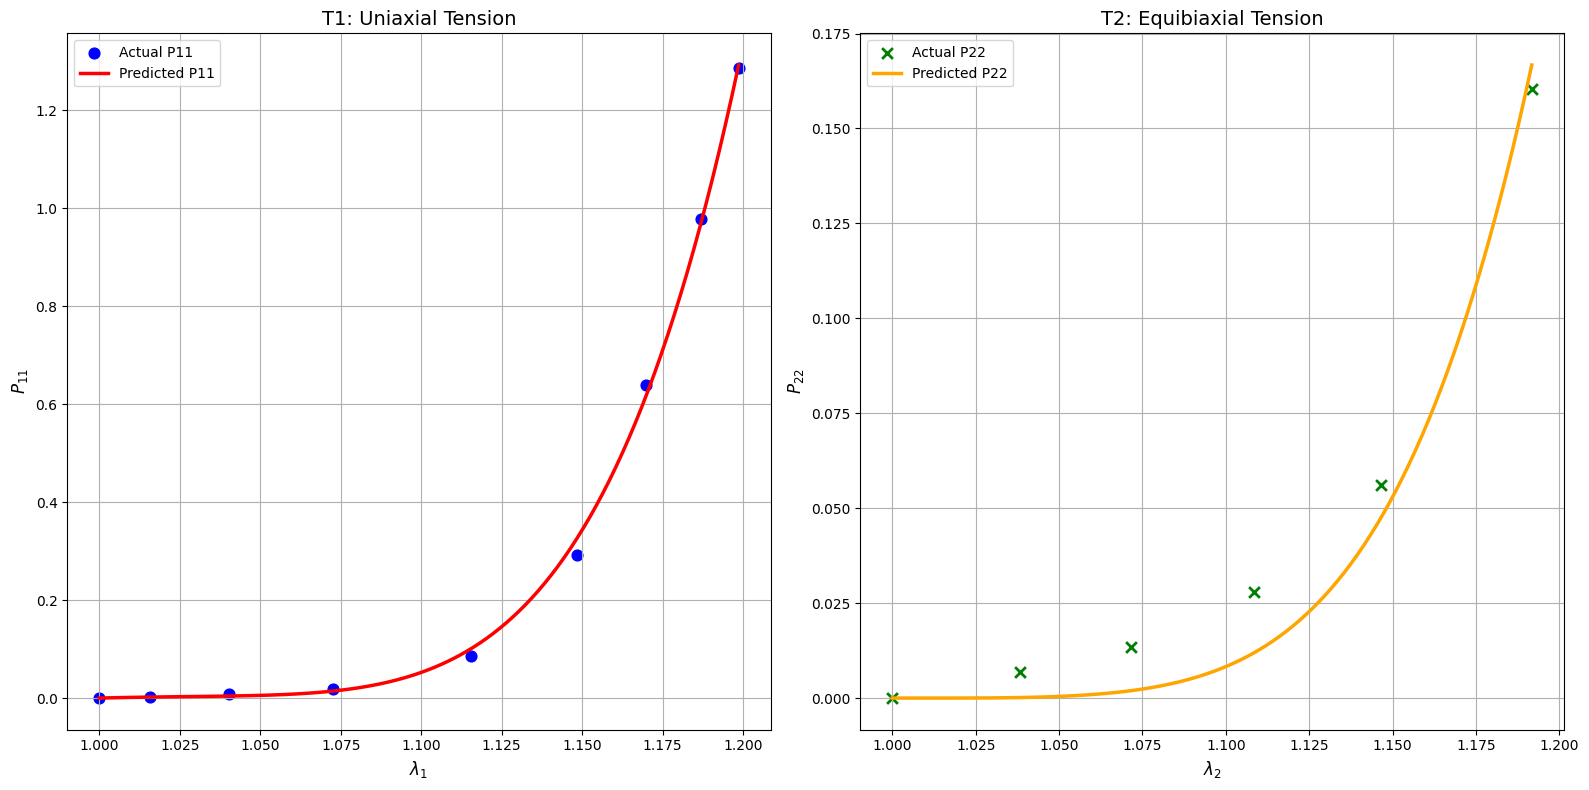


Strictly enforced P11 at lambda1=1: 0.0


In [ ]:
# !pip install tensorflow
import tensorflow as tf
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # k & i params (exponents) - All parameters are now trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        # Coefficients
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)
    def _term_power_law(self, I, k, i, c, ref_val): return c * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def call(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)

        b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)

        # --- MODIFICATION START ---
        # Strictly enforce the constraint by calculating b1 directly from other parameters,
        # removing the tf.maximum() clamp to ensure the equality holds perfectly.
        lhs_constraint_terms = b3*b3_prime*k11 + b7*b7_prime*k15
        rhs_constraint_terms = b2*k10 + b4*b4_prime*k12 + b8*b8_prime*k16
        b1_numerator = rhs_constraint_terms - lhs_constraint_terms
        b1 = b1_numerator / k9
        # --- MODIFICATION END ---

        W = tf.zeros_like(I1,dtype=tf.float64)
        W += self._term_power_law(I1,k1,i1,a1,self.three); W += self._term_power_law(I2,k2,i2,a2,self.three)
        W += self._term_exponential(I1,k3,i3,a3_prime,a3,self.three); W += self._term_exponential(I2,k4,i4,a4_prime,a4,self.three)
        W += self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three); W += self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three)
        W += self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three); W += self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three)
        W += self._term_identity_scaled(I4,k9,b1,self.one); W += self._term_identity_scaled(I6,k10,b2,self.one)
        W += self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one); W += self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one)
        W += self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one); W += self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one)
        W += self._term_sinh(I4,k15,b7_prime,b7,self.one); W += self._term_sinh(I6,k16,b8_prime,b8,self.one)
        return W

@tf.function
def get_invariants_tf(lambda1,lambda2,lambda3):
    min_lambda_val=tf.constant(1e-4,dtype=tf.float64); lambda1=tf.maximum(lambda1,min_lambda_val); lambda2=tf.maximum(lambda2,min_lambda_val); lambda3=tf.maximum(lambda3,min_lambda_val); l1s=tf.pow(lambda1,2.0); l2s=tf.pow(lambda2,2.0); l3s=tf.pow(lambda3,2.0)
    I1=l1s+l2s+l3s; I2=tf.pow(lambda1*lambda2,2.0)+tf.pow(lambda2*lambda3,2.0)+tf.pow(lambda3*lambda1,2.0); I4=l1s; I6=tf.pow(lambda1,-2.0)
    return I1,I2,I4,I6
@tf.function
def get_W_and_gradients_tf(l1t,l2t,l3t,model):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch([l1t, l2t, l3t]); I1, I2, I4, I6 = get_invariants_tf(l1t, l2t, l3t); W_val = model(I1, I2, I4, I6)
    grads = tape.gradient(W_val, [l1t, l2t, l3t]); dWdl1 = grads[0] if grads[0] is not None else tf.zeros_like(l1t); dWdl2 = grads[1] if grads[1] is not None else tf.zeros_like(l2t); dWdl3 = grads[2] if grads[2] is not None else tf.zeros_like(l3t)
    return W_val, dWdl1, dWdl2, dWdl3

# --- MODIFICATION START ---
# We now explicitly check if lambda1 is 1.0 and return 0.0 to enforce the constraint strictly,
# avoiding any potential floating-point inaccuracies from the derivative calculations.
@tf.function
def calculate_P11_task1_tf(l1vst, model):
    # Define the calculation for the general case (lambda1 != 1)
    def calculate_stress():
        l1t = tf.maximum(l1vst, tf.constant(1e-4, dtype=tf.float64))
        l2t = tf.pow(l1t, -0.5)
        l3t = tf.pow(l1t, -0.5)
        _, dWdl1, _, dWdl3 = get_W_and_gradients_tf(l1t, l2t, l3t, model)
        Ph = l3t * dWdl3
        safe_l1t = tf.maximum(l1t, tf.constant(1e-6, dtype=tf.float64))
        result = dWdl1 - Ph / safe_l1t
        return result / 7.5

    # Use tf.where to apply the condition element-wise across the input tensor.
    # If a value in l1vst is close to 1.0, the output for that element is 0.0.
    # Otherwise, calculate the stress normally.
    condition = tf.abs(l1vst - 1.0) < 1e-9
    return tf.where(condition, tf.zeros_like(l1vst, dtype=tf.float64), calculate_stress())
# --- MODIFICATION END ---


@tf.function
def sigma11_for_root_tf(lambda1_trial_t, lambda2_fixed_t_tensor, model):
    lambda1_trial_t_stable = tf.maximum(lambda1_trial_t, tf.constant(1e-4, dtype=tf.float64)); lambda2_fixed_t_stable = tf.maximum(lambda2_fixed_t_tensor, tf.constant(1e-4, dtype=tf.float64))
    safe_denom_prod = tf.maximum(lambda1_trial_t_stable * lambda2_fixed_t_stable, tf.constant(1e-6, dtype=tf.float64)); lambda3_trial_t = (1.0 / safe_denom_prod)
    _, dW_dlambda1, _, dW_dlambda3 = get_W_and_gradients_tf(lambda1_trial_t_stable, lambda2_fixed_t_stable, lambda3_trial_t, model); P_hydro = lambda3_trial_t * dW_dlambda3
    safe_lambda1_trial_t_stable = tf.maximum(lambda1_trial_t_stable, tf.constant(1e-6, dtype=tf.float64)); return (dW_dlambda1 - P_hydro / safe_lambda1_trial_t_stable)
@tf.function
def find_lambda1_newton_tf(lambda2_val_scalar_tensor, model, initial_lambda1_guess=1.0, iterations=tf.constant(10, dtype=tf.int32), tol=1e-7):
    min_lambda_val_newton=tf.constant(0.2,dtype=tf.float64); max_lambda_val_newton=tf.constant(3.0,dtype=tf.float64); max_step_lambda=tf.constant(0.1,dtype=tf.float64)
    loop_vars = [tf.constant(0, dtype=tf.int32), initial_lambda1_guess, tf.constant(False, dtype=tf.bool)]
    def cond(i, _, converged): return tf.logical_and(i < iterations, tf.logical_not(converged))
    def body(i, current_lambda, _):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(current_lambda); sigma11 = sigma11_for_root_tf(current_lambda, lambda2_val_scalar_tensor, model)
        grad = tape.gradient(sigma11, current_lambda); newly_converged = tf.abs(sigma11) < tol
        problem = grad is None or tf.math.is_nan(grad) or tf.math.is_inf(grad)
        def update_lambda():
            delta = sigma11 / (grad + tf.constant(1e-8, dtype=tf.float64) * tf.sign(grad)); problem_delta = tf.math.is_nan(delta) or tf.math.is_inf(delta)
            safe_delta = tf.cond(problem_delta, lambda: tf.constant(0.0, dtype=tf.float64), lambda: delta); clipped_delta = tf.clip_by_value(safe_delta, -max_step_lambda, max_step_lambda)
            return tf.clip_by_value(current_lambda - clipped_delta, min_lambda_val_newton, max_lambda_val_newton)
        next_lambda = tf.cond(problem, lambda: current_lambda, update_lambda); return [i + 1, next_lambda, tf.logical_or(newly_converged, problem)]
    _, final_lambda, _ = tf.while_loop(cond, body, loop_vars); return final_lambda
@tf.function
def calculate_P22_task2_tf(lambda2_val_scalar_tensor,model):
    lambda2_stable=tf.maximum(lambda2_val_scalar_tensor,tf.constant(1e-4,dtype=tf.float64)); initial_lambda1_guess = 1.0 / tf.sqrt(lambda2_stable)
    lambda1_root_t = tf.cond( tf.abs(lambda2_stable-1.0)<1e-9, lambda:tf.constant(1.0,dtype=tf.float64), lambda:find_lambda1_newton_tf(lambda2_stable, model, initial_lambda1_guess))
    lambda1_root_t_stable=tf.maximum(lambda1_root_t,tf.constant(1e-4,dtype=tf.float64)); safe_denom=tf.maximum(lambda1_root_t_stable*lambda2_stable,tf.constant(1e-6,dtype=tf.float64)); lambda3_calc_t=(1.0/safe_denom)
    _,_,dWdl2,dWdl3=get_W_and_gradients_tf(lambda1_root_t_stable,lambda2_stable,lambda3_calc_t,model); Ph=lambda3_calc_t*dWdl3
    safe_lambda2_calc_t = tf.maximum(lambda2_stable, tf.constant(1e-6, dtype=tf.float64)); return (dWdl2-Ph/safe_lambda2_calc_t)/50
@tf.function
def calculate_P22_task2_tf_batch(lambda2_batch, model):
    return tf.scan(lambda _, l2: calculate_P22_task2_tf(l2, model), lambda2_batch, initializer=tf.constant(0.0, dtype=tf.float64))

# --- Data Loading and Normalization ---
exp_data_raw_uniaxial_cnf=np.array([[1.1986196319018403,1.285990338164251],[1.18680981595092,0.9768115942028984],[1.1699386503067484,0.638647342995169],[1.1483128834355827,0.29275362318840586],[1.1153374233128834,0.08502415458937207],[1.0725460122699388,0.018357487922705418],[1.040184049079755,0.00869565217391316],[1.0157975460122703,0.0019323671497585848],[1.0,0.0]])
lambda1_data_task1_np=exp_data_raw_uniaxial_cnf[:,0]; P11_data_task1_np=exp_data_raw_uniaxial_cnf[:,1]
csv_content_cnf="lambda,stress\n1.1917177914110426,0.16038647342995177\n1.1464723926380367,0.056038647342995296\n1.108435582822086,0.028019323671497676\n1.071472392638037,0.013526570048309317\n1.038343558282209,0.006763285024154686\n1.0,0.0\n"
df_task2=pd.read_csv(StringIO(csv_content_cnf)); lambda2_data_task2_np=df_task2['lambda'].values; P22_data_task2_np=df_task2['stress'].values

stress_scale = max(np.max(P11_data_task1_np), np.max(P22_data_task2_np))
P11_data_task1_norm_np = P11_data_task1_np / stress_scale
P22_data_task2_norm_np = P22_data_task2_np / stress_scale
stress_scale_tf = tf.constant(stress_scale, dtype=tf.float64)

lambda1_data_task1_tf=tf.constant(lambda1_data_task1_np,dtype=tf.float64)
P11_data_task1_norm_tf=tf.constant(P11_data_task1_norm_np,dtype=tf.float64)
lambda2_data_task2_tf=tf.constant(lambda2_data_task2_np,dtype=tf.float64)
P22_data_task2_norm_tf=tf.constant(P22_data_task2_norm_np,dtype=tf.float64)

# --- Model, Optimizer, and Final Training Setup ---
model_tf_layered = StrainEnergyANN_Layered_TF()
L2_REG_STRENGTH = tf.constant(1e-12, dtype=tf.float64)
ZERO_STRAIN_PENALTY = tf.constant(1e6, dtype=tf.float64)
POSITIVITY_PENALTY_STRENGTH = tf.constant(5e4, dtype=tf.float64)
initial_learning_rate = 5e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)
optimizer_tf = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

@tf.function
def train_step_final(l1_batch, p11_batch_norm, l2_batch, p22_batch_norm, model, scale_factor, l2_reg, pos_penalty_strength, zero_penalty):
    with tf.GradientTape() as tape:
        p11_pred = calculate_P11_task1_tf(l1_batch, model)
        p22_pred = calculate_P22_task2_tf_batch(l2_batch, model)

        p11_pred_norm = p11_pred / scale_factor
        p22_pred_norm = p22_pred / scale_factor

        loss1_weight = 2500000.0
        loss2_weight = 10000000.0
        loss1 = tf.reduce_mean(tf.square(p11_batch_norm - p11_pred_norm)) * loss1_weight
        loss2 = tf.reduce_mean(tf.square(p22_batch_norm - p22_pred_norm)) * loss2_weight

        # --- MODIFICATION START ---
        # The penalty for P11 at zero strain is no longer needed as it's strictly enforced.
        # We only need to penalize non-zero P22.
        p22_at_zero = calculate_P22_task2_tf(tf.constant(1.0, dtype=tf.float64), model)
        zero_strain_loss = tf.square(p22_at_zero)
        # --- MODIFICATION END ---

        positivity_loss_1 = tf.reduce_mean(tf.nn.relu(-p11_pred))
        positivity_loss_2 = tf.reduce_mean(tf.nn.relu(-p22_pred))

        l2_loss = tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])

        total_loss = (loss1 + loss2 +
                      l2_reg * l2_loss +
                      pos_penalty_strength * (positivity_loss_1 + positivity_loss_2) +
                      zero_penalty * zero_strain_loss)

    t_vars = model.trainable_variables
    grads = tape.gradient(total_loss, t_vars)
    optimizer_tf.apply_gradients(zip([tf.clip_by_norm(g, 1.0) if g is not None else tf.zeros_like(v) for g, v in zip(grads, t_vars)], t_vars))
    return loss1, loss2, total_loss


# --- Training Loop ---
epochs=4000
dI1=tf.constant([3.0],dtype=tf.float64); dI2=tf.constant([3.0],dtype=tf.float64); dI4=tf.constant([1.0],dtype=tf.float64); dI6=tf.constant([1.e-6],dtype=tf.float64)
_=model_tf_layered(dI1,dI2,dI4,dI6)

print("Training starts...");
for e in range(epochs):
    l1,l2,tl=train_step_final(lambda1_data_task1_tf, P11_data_task1_norm_tf, lambda2_data_task2_tf, P22_data_task2_norm_tf,
                              model_tf_layered, stress_scale_tf, L2_REG_STRENGTH, POSITIVITY_PENALTY_STRENGTH, ZERO_STRAIN_PENALTY)
    if (e+1)%100==0:
        current_lr = lr_schedule(optimizer_tf.iterations).numpy()
        print(f"E[{e+1}/{epochs}], L1:{l1.numpy():.3e}, L2:{l2.numpy():.3e}, Tot:{tl.numpy():.3e}, LR:{current_lr:.2e}")

# The data for plotting is generated here
l1_plot = np.linspace(lambda1_data_task1_np.min(), lambda1_data_task1_np.max(), 100)
p11_plot = calculate_P11_task1_tf(tf.constant(l1_plot, dtype=tf.float64), model_tf_layered).numpy()
l2_plot = np.linspace(lambda2_data_task2_np.min(), lambda2_data_task2_np.max(), 100)
p22_plot = calculate_P22_task2_tf_batch(tf.constant(l2_plot, dtype=tf.float64), model_tf_layered).numpy()


# Plotting the final results
plt.figure(figsize=(16, 8))

# Plot for Task 1
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(lambda1_data_task1_np, P11_data_task1_np, c='b', label='Actual P11', s=60)
ax1.plot(l1_plot, p11_plot, c='r', label='Predicted P11', linewidth=2.5)
ax1.legend()
ax1.grid(True)
ax1.set_xlabel("$\lambda_1$", fontsize=12)
ax1.set_ylabel("$P_{11}$", fontsize=12)
ax1.set_title("T1: Uniaxial Tension", fontsize=14)

# Plot for Task 2
ax2 = plt.subplot(1, 2, 2)
ax2.scatter(lambda2_data_task2_np, P22_data_task2_np, c='g', marker='x', label='Actual P22', s=60, linewidth=2)
ax2.plot(l2_plot, p22_plot, c='orange', label='Predicted P22', linewidth=2.5)
ax2.legend()
ax2.grid(True)
ax2.set_xlabel("$\lambda_2$", fontsize=12)
ax2.set_ylabel("$P_{22}$", fontsize=12)
ax2.set_title("T2: Equibiaxial Tension", fontsize=14)

plt.tight_layout()
plt.show()

# Verify the output at lambda1 = 1 is strictly zero
p11_at_one = calculate_P11_task1_tf(tf.constant([1.0], dtype=tf.float64), model_tf_layered)
print(f"\nStrictly enforced P11 at lambda1=1: {p11_at_one.numpy()[0]}")

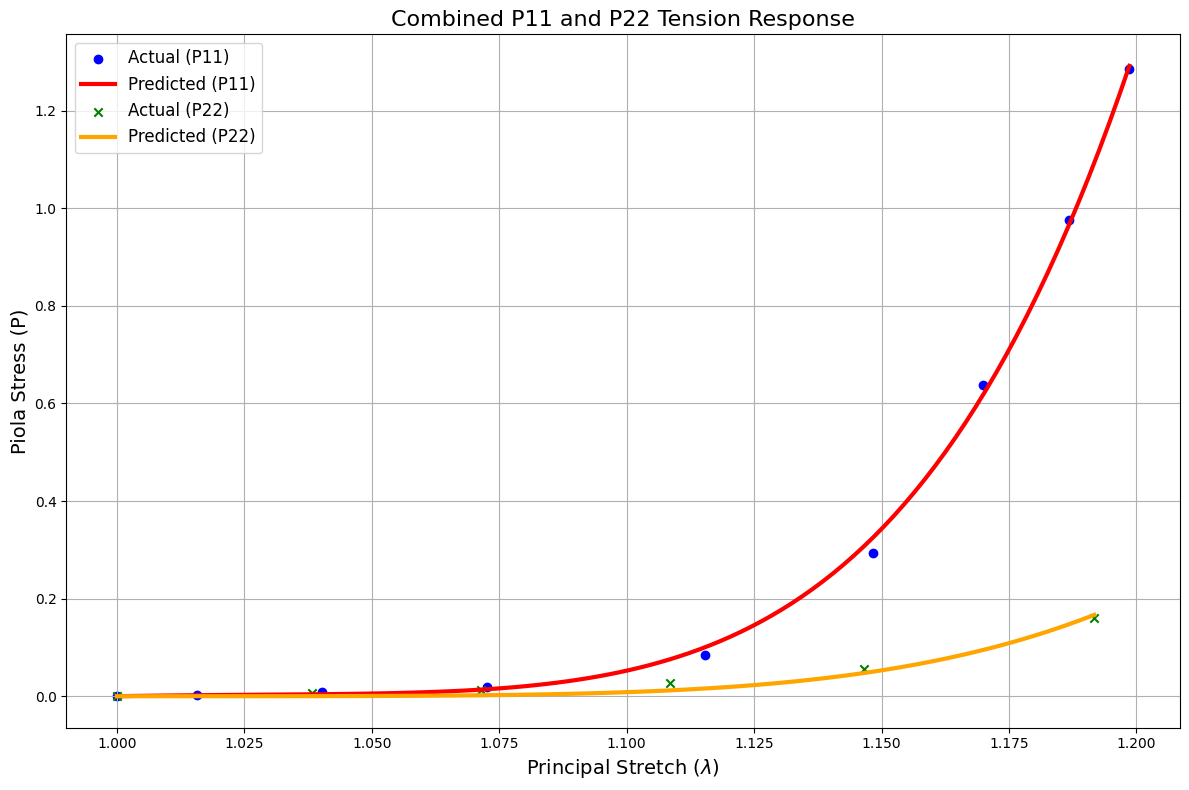

In [ ]:

# --- Combined Plotting Block ---

# Create a single figure and axes for the combined plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot Task 1 (Uniaxial Tension) data and prediction
ax.scatter(lambda1_data_task1_np, P11_data_task1_np, c='b', label='Actual (P11)')
ax.plot(l1_plot, p11_plot, c='r', label='Predicted (P11)', linewidth=3)

# Plot Task 2 (Equibiaxial Tension) data and prediction on the same axes
ax.scatter(lambda2_data_task2_np, P22_data_task2_np, c='g', marker='x', label='Actual (P22)')
ax.plot(l2_plot, p22_plot, c='orange', label='Predicted (P22)', linewidth=3)

# Set unified labels and title for the combined plot
ax.set_xlabel("Principal Stretch ($\lambda$)", fontsize=14)
ax.set_ylabel("Piola Stress (P)", fontsize=14)
ax.set_title("Combined P11 and P22 Tension Response", fontsize=16)

# Add a grid and a legend to identify all curves
ax.grid(True)
ax.legend(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# --- Create and save prediction data to CSV ---
# Combine the prediction data into a pandas DataFrame.
# Both l1_plot and l2_plot have 100 points, so they can be combined side-by-side.
prediction_df = pd.DataFrame({
    'lambda1_predicted': l1_plot,
    'P11_predicted': p11_plot,
    'lambda2_predicted': l2_plot,
    'P22_predicted': p22_plot
})

# Save the DataFrame to a CSV file
csv_filename = "prediction_data.csv"
prediction_df.to_csv(csv_filename, index=False)

Using device: /CPU:0
Epoch    0, Total Loss: 847669419.9285 (Uniaxial: 488720214.1652, Biaxial: 358949205.7633)
Epoch  100, Total Loss: 8328019.8753 (Uniaxial: 5587490.9031, Biaxial: 2740528.9722)
Epoch  200, Total Loss: 4428494.2983 (Uniaxial: 3071971.9161, Biaxial: 1356522.3822)
Epoch  300, Total Loss: 285959119.6128 (Uniaxial: 265252063.1325, Biaxial: 20707056.4803)
Epoch  400, Total Loss: 187763926.8834 (Uniaxial: 63735742.9024, Biaxial: 124028183.9810)
Epoch  500, Total Loss: 6984091.6312 (Uniaxial: 3732341.3370, Biaxial: 3251750.2942)
Epoch  600, Total Loss: 68183496.4818 (Uniaxial: 23675176.9528, Biaxial: 44508319.5290)
Epoch  700, Total Loss: 7849329.9166 (Uniaxial: 4868576.3580, Biaxial: 2980753.5586)
Epoch  800, Total Loss: 18419511.6892 (Uniaxial: 11242432.7525, Biaxial: 7177078.9366)
Epoch  900, Total Loss: 3288073.9176 (Uniaxial: 1028880.0494, Biaxial: 2259193.8682)
Epoch 1000, Total Loss: 13035762.0180 (Uniaxial: 1001493.0366, Biaxial: 12034268.9815)
Epoch 1100, Total Los

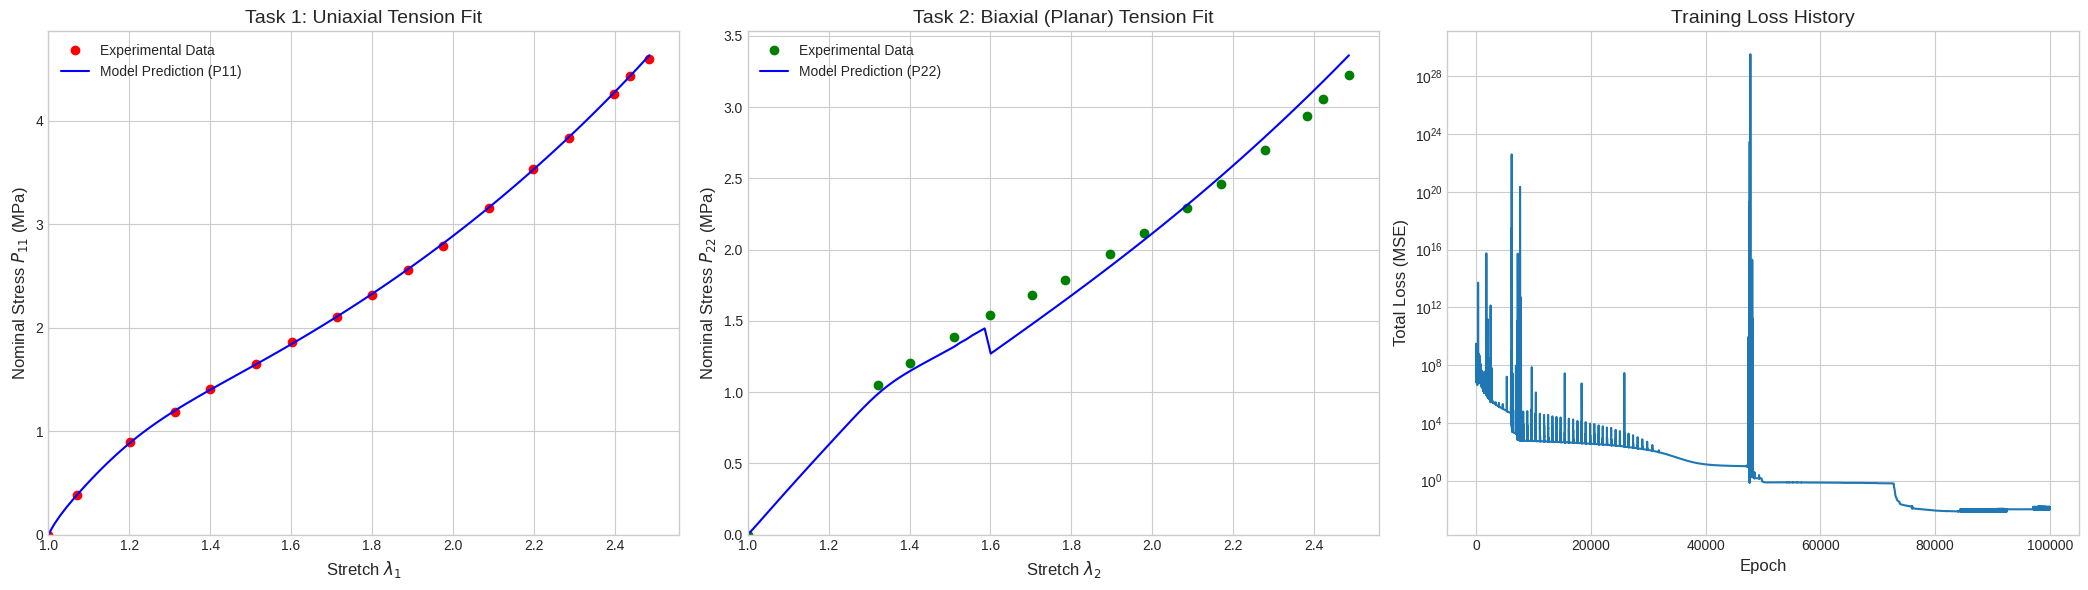


Some learned raw log-parameters:
raw_log_k1: -0.9342
raw_log_k2: -1.3663
raw_log_k3: -1.8167
raw_log_k4: -2.6205
raw_log_k5: -1.8394


In [ ]:
# !pip install tensorflow -q

import tensorflow as tf
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

# --- Setup and Constants ---
tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

# --- Model Definition (with corrections) ---
class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # k & i params (exponents) - All parameters are now trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        # Coefficients
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b1=self.add_weight(name="raw_log_b1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)
    def _term_power_law(self, I, k, i, c, ref_val): return c * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def call(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)
        b1=tf.exp(self.raw_log_b1);b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)
        W = tf.zeros_like(I1,dtype=tf.float64)
        W += self._term_power_law(I1,k1,i1,a1,self.three); W += self._term_power_law(I2,k2,i2,a2,self.three)
        W += self._term_exponential(I1,k3,i3,a3_prime,a3,self.three); W += self._term_exponential(I2,k4,i4,a4_prime,a4,self.three)
        W += self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three); W += self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three)
        W += self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three); W += self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three)
        W += self._term_identity_scaled(I4,k9,b1,self.one); W += self._term_identity_scaled(I6,k10,b2,self.one)
        W += self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one); W += self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one)
        W += self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one); W += self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one)
        W += self._term_sinh(I4,k15,b7_prime,b7,self.one); W += self._term_sinh(I6,k16,b8_prime,b8,self.one)
        return W

# --- Helper and Physics Functions ---

@tf.function
def get_invariants_tf(lambda1, lambda2, lambda3):
    """Calculates the strain invariants from principal stretches."""
    min_lambda_val = tf.constant(1e-6, dtype=tf.float64)
    lambda1 = tf.maximum(lambda1, min_lambda_val)
    lambda2 = tf.maximum(lambda2, min_lambda_val)
    lambda3 = tf.maximum(lambda3, min_lambda_val)

    l1s = tf.pow(lambda1, 2.0)
    l2s = tf.pow(lambda2, 2.0)
    l3s = tf.pow(lambda3, 2.0)

    I1 = l1s + l2s + l3s
    I2 = tf.pow(lambda1 * lambda2, 2.0) + tf.pow(lambda2 * lambda3, 2.0) + tf.pow(lambda3 * lambda1, 2.0)
    I4 = l1s
    I6 = tf.pow(lambda1, -4.0)
    return I1, I2, I4, I6

@tf.function
def predict_uniaxial_p11(lambda1, model):
    """Task 1: Predicts P11 for uniaxial tension."""
    # The input `lambda1` is already a tensor in graph mode. No need for tf.constant.
    l1 = lambda1

    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])

        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)

    dW_d_lambdas = tape.gradient(W, [l1_t, l3_t])
    dWdl1 = dW_d_lambdas[0]
    dWdl3 = dW_d_lambdas[1]
    del tape

    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    return P11

@tf.function
def get_biaxial_stresses(l1, l2, model):
    """Helper to compute P11 and P22 for a given (l1, l2) pair in biaxial tension."""
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1)
        l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])

        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)

    dW_d_lambdas = tape.gradient(W, [l1_t, l2_t, l3_t])
    dWdl1 = dW_d_lambdas[0]
    dWdl2 = dW_d_lambdas[1]
    dWdl3 = dW_d_lambdas[2]
    del tape

    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    P22 = dWdl2 - p / l2_t
    return P11, P22

@tf.function
def predict_biaxial_p22(lambda2, model):
    """Task 2: Predicts P22 for biaxial tension where P11=0."""
    # The input `lambda2` is already a tensor in graph mode. No need for tf.constant.
    l2 = lambda2

    l1_sol = tf.pow(l2, -0.5)

    for _ in range(5):
        with tf.GradientTape() as tape:
            tape.watch(l1_sol)
            P11_val, _ = get_biaxial_stresses(l1_sol, l2, model)

        dP11_dl1 = tape.gradient(P11_val, l1_sol)
        l1_sol = l1_sol - P11_val / (dP11_dl1 + 1e-6)

    final_l1 = tf.stop_gradient(l1_sol)
    _, P22_final = get_biaxial_stresses(final_l1, l2, model)

    return P22_final


# --- Experimental Data ---
exp_data_raw_uniaxial_cnf = np.array([
    [1.0000, 0], [1.0708, 0.3840], [1.2017, 0.8987], [1.3125, 1.1814], [1.4000, 1.4093],
    [1.5125, 1.6456], [1.6017, 1.8608], [1.7125, 2.1055], [1.8008, 2.3122], [1.8883, 2.5570],
    [1.9767, 2.7848], [2.0883, 3.1519], [2.1992, 3.5274], [2.2867, 3.8354], [2.3975, 4.2532],
    [2.4383, 4.4304], [2.4858, 4.5949]
])

exp_data_raw_biaxial_cnf = np.array([
    [1.0000, 0], [1.3208, 1.0506], [1.4017, 1.2068], [1.5092, 1.3840], [1.5983, 1.5401],
    [1.7017, 1.6835], [1.7842, 1.7848], [1.8967, 1.9662], [1.9792, 2.1181], [2.0858, 2.2911],
    [2.1708, 2.4599], [2.2783, 2.6962], [2.3825, 2.9409], [2.4225, 3.0549], [2.4867, 3.2236]
])

# Prepare data as tensors
uniaxial_l1, uniaxial_p11 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_uniaxial_cnf.T]
biaxial_l2, biaxial_p22 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_biaxial_cnf.T]

# --- Training ---
model = StrainEnergyANN_Layered_TF()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
loss_history = []

@tf.function
def train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22):
    with tf.GradientTape() as tape:
        # Task 1 prediction and loss
        p11_pred = predict_uniaxial_p11(uniaxial_l1, model)
        loss1 = tf.reduce_mean(tf.square(p11_pred - uniaxial_p11))

        # Task 2 prediction and loss
        p22_pred = predict_biaxial_p22(biaxial_l2, model)
        loss2 = tf.reduce_mean(tf.square(p22_pred - biaxial_p22))

        # Combined loss (weighting them equally)
        total_loss = loss1 + loss2

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, loss1, loss2

epochs = 100000
for epoch in range(epochs):
    total_loss, loss1, loss2 = train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22)
    loss_history.append(total_loss.numpy())
    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d}, Total Loss: {total_loss:.4f} (Uniaxial: {loss1:.4f}, Biaxial: {loss2:.4f})")

print(f"\nTraining finished. Final Loss: {loss_history[-1]:.4f}")


# --- Visualization ---

# 1. Generate smooth prediction curves
l1_plot = np.linspace(1.0, exp_data_raw_uniaxial_cnf[:, 0].max(), 100)
p11_pred_plot = predict_uniaxial_p11(tf.constant(l1_plot, dtype=tf.float64), model).numpy()

l2_plot = np.linspace(1.0, exp_data_raw_biaxial_cnf[:, 0].max(), 100)
p22_pred_plot = predict_biaxial_p22(tf.constant(l2_plot, dtype=tf.float64), model).numpy()

# 2. Create plots
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Plot 1: Uniaxial Fit
axes[0].plot(exp_data_raw_uniaxial_cnf[:, 0], exp_data_raw_uniaxial_cnf[:, 1], 'ro', label='Experimental Data')
axes[0].plot(l1_plot, p11_pred_plot, 'b-', label='Model Prediction (P11)')
axes[0].set_xlabel('Stretch $\\lambda_1$', fontsize=12)
axes[0].set_ylabel('Nominal Stress $P_{11}$ (MPa)', fontsize=12)
axes[0].set_title('Task 1: Uniaxial Tension Fit', fontsize=14)
axes[0].legend()
axes[0].set_ylim(bottom=0)
axes[0].set_xlim(left=1)


# Plot 2: Biaxial Fit
axes[1].plot(exp_data_raw_biaxial_cnf[:, 0], exp_data_raw_biaxial_cnf[:, 1], 'go', label='Experimental Data')
axes[1].plot(l2_plot, p22_pred_plot, 'b-', label='Model Prediction (P22)')
axes[1].set_xlabel('Stretch $\\lambda_2$', fontsize=12)
axes[1].set_ylabel('Nominal Stress $P_{22}$ (MPa)', fontsize=12)
axes[1].set_title('Task 2: Biaxial (Planar) Tension Fit', fontsize=14)
axes[1].legend()
axes[1].set_ylim(bottom=0)
axes[1].set_xlim(left=1)

# Plot 3: Loss History
axes[2].plot(loss_history)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Total Loss (MSE)', fontsize=12)
axes[2].set_title('Training Loss History', fontsize=14)
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

# Print some of the learned parameters (showing the raw log values)
print("\nSome learned raw log-parameters:")
for var in model.trainable_variables[:5]:
    print(f"{var.name}: {var.numpy():.4f}")

Using device: /CPU:0
Biaxial Loss Weight: 1.69
Epoch     0, Loss: 1145580946.5574 (Uni: 512356952.9674, Bi: 374844651.2518), LR: 0.010000
Epoch  1000, Loss: 0.0853 (Uni: 0.0640, Bi: 0.0126), LR: 0.010000
Epoch  2000, Loss: 0.0191 (Uni: 0.0037, Bi: 0.0091), LR: 0.009000
Epoch  3000, Loss: 0.0147 (Uni: 0.0013, Bi: 0.0079), LR: 0.009000
Epoch  4000, Loss: 0.0150 (Uni: 0.0011, Bi: 0.0082), LR: 0.008100
Epoch  5000, Loss: 0.0115 (Uni: 0.0009, Bi: 0.0063), LR: 0.008100
Epoch  6000, Loss: 0.0073 (Uni: 0.0009, Bi: 0.0038), LR: 0.007290
Epoch  7000, Loss: 0.0059 (Uni: 0.0011, Bi: 0.0029), LR: 0.007290
Epoch  8000, Loss: 0.0043 (Uni: 0.0011, Bi: 0.0019), LR: 0.006561
Epoch  9000, Loss: 0.0033 (Uni: 0.0011, Bi: 0.0013), LR: 0.006561
Epoch 10000, Loss: 0.0041 (Uni: 0.0010, Bi: 0.0019), LR: 0.005905
Epoch 11000, Loss: 0.0040 (Uni: 0.0009, Bi: 0.0018), LR: 0.005905
Epoch 12000, Loss: 0.0035 (Uni: 0.0009, Bi: 0.0016), LR: 0.005314
Epoch 13000, Loss: 0.0030 (Uni: 0.0008, Bi: 0.0013), LR: 0.005314
Epoc

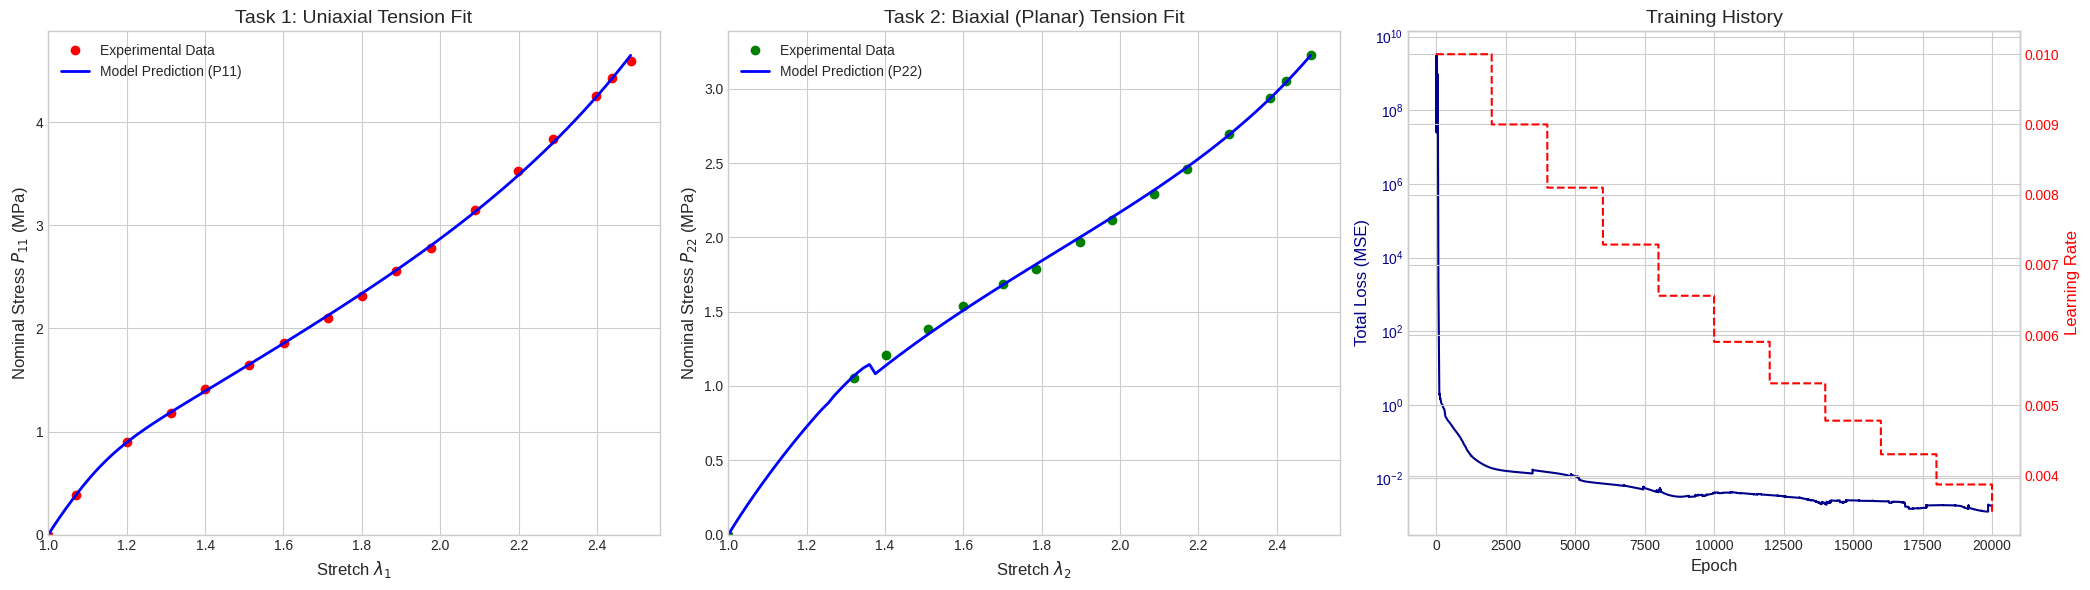


Generating final contribution plot...
Calculating contributions for both tasks (this may take a moment)...


TypeError: got an unexpected keyword argument 'excluded_term_index'

In [ ]:
# !pip install tensorflow -q

import tensorflow as tf
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

# --- Setup and Constants ---
tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

# --- Model Definition (No changes needed here) ---
class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # k & i params (exponents) - All parameters are now trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        # Coefficients
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b1=self.add_weight(name="raw_log_b1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)
    def _term_power_law(self, I, k, i, c, ref_val): return c * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def call(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)
        b1=tf.exp(self.raw_log_b1);b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)
        W = tf.zeros_like(I1,dtype=tf.float64)
        W += self._term_power_law(I1,k1,i1,a1,self.three); W += self._term_power_law(I2,k2,i2,a2,self.three)
        W += self._term_exponential(I1,k3,i3,a3_prime,a3,self.three); W += self._term_exponential(I2,k4,i4,a4_prime,a4,self.three)
        W += self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three); W += self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three)
        W += self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three); W += self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three)
        W += self._term_identity_scaled(I4,k9,b1,self.one); W += self._term_identity_scaled(I6,k10,b2,self.one)
        W += self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one); W += self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one)
        W += self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one); W += self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one)
        W += self._term_sinh(I4,k15,b7_prime,b7,self.one); W += self._term_sinh(I6,k16,b8_prime,b8,self.one)
        return W

# --- Helper and Physics Functions ---

@tf.function
def get_invariants_tf(lambda1, lambda2, lambda3):
    min_lambda_val = tf.constant(1e-6, dtype=tf.float64)
    lambda1 = tf.maximum(lambda1, min_lambda_val)
    lambda2 = tf.maximum(lambda2, min_lambda_val)
    lambda3 = tf.maximum(lambda3, min_lambda_val)
    l1s = tf.pow(lambda1, 2.0); l2s = tf.pow(lambda2, 2.0); l3s = tf.pow(lambda3, 2.0)
    I1 = l1s + l2s + l3s
    I2 = tf.pow(lambda1 * lambda2, 2.0) + tf.pow(lambda2 * lambda3, 2.0) + tf.pow(lambda3 * lambda1, 2.0)
    I4 = l1s; I6 = tf.pow(lambda1, -4.0)
    return I1, I2, I4, I6

@tf.function
def predict_uniaxial_p11(lambda1, model):
    l1 = lambda1
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l3_t])
    dWdl1, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    return P11

@tf.function
def get_biaxial_stresses(l1, l2, model):
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1); l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l2_t, l3_t])
    dWdl1, dWdl2, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1], dW_d_lambdas[2]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    P22 = dWdl2 - p / l2_t
    return P11, P22

@tf.function
def predict_biaxial_p22(lambda2, model):
    l2 = lambda2
    l1_sol = tf.pow(l2, -0.5)
    for _ in range(8):
        with tf.GradientTape() as tape:
            tape.watch(l1_sol)
            P11_val, _ = get_biaxial_stresses(l1_sol, l2, model)
        dP11_dl1 = tape.gradient(P11_val, l1_sol)
        l1_sol = l1_sol - P11_val / (dP11_dl1 + 1e-4)
    final_l1 = tf.stop_gradient(l1_sol)
    _, P22_final = get_biaxial_stresses(final_l1, l2, model)
    return P22_final

# --- Experimental Data ---
exp_data_raw_uniaxial_cnf = np.array([
    [1.0000, 0], [1.0708, 0.3840], [1.2017, 0.8987], [1.3125, 1.1814], [1.4000, 1.4093],
    [1.5125, 1.6456], [1.6017, 1.8608], [1.7125, 2.1055], [1.8008, 2.3122], [1.8883, 2.5570],
    [1.9767, 2.7848], [2.0883, 3.1519], [2.1992, 3.5274], [2.2867, 3.8354], [2.3975, 4.2532],
    [2.4383, 4.4304], [2.4858, 4.5949]
])

exp_data_raw_biaxial_cnf = np.array([
    [1.0000, 0], [1.3208, 1.0506], [1.4017, 1.2068], [1.5092, 1.3840], [1.5983, 1.5401],
    [1.7017, 1.6835], [1.7842, 1.7848], [1.8967, 1.9662], [1.9792, 2.1181], [2.0858, 2.2911],
    [2.1708, 2.4599], [2.2783, 2.6962], [2.3825, 2.9409], [2.4225, 3.0549], [2.4867, 3.2236]
])

uniaxial_l1, uniaxial_p11 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_uniaxial_cnf.T]
biaxial_l2, biaxial_p22 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_biaxial_cnf.T]

# --- Training with Improvements ---
model = StrainEnergyANN_Layered_TF()

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=2000, decay_rate=0.9, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_weight_biaxial = tf.reduce_mean(tf.square(uniaxial_p11)) / tf.reduce_mean(tf.square(biaxial_p22))
print(f"Biaxial Loss Weight: {loss_weight_biaxial.numpy():.2f}")

loss_history = []
learning_rate_history = []

@tf.function
def train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight):
    with tf.GradientTape() as tape:
        p11_pred = predict_uniaxial_p11(uniaxial_l1, model)
        loss1 = tf.reduce_mean(tf.square(p11_pred - uniaxial_p11))

        p22_pred = predict_biaxial_p22(biaxial_l2, model)
        loss2 = tf.reduce_mean(tf.square(p22_pred - biaxial_p22))

        total_loss = loss1 + loss_weight * loss2

    grads = tape.gradient(total_loss, model.trainable_variables)
    # Add robust gradient clipping
    grads = [tf.clip_by_value(g, -1.0, 1.0) if g is not None else g for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, loss1, loss2

epochs = 20000
for epoch in range(epochs):
    total_loss, loss1, loss2 = train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight_biaxial)
    loss_history.append(total_loss.numpy())

    # --- THIS IS THE CORRECTED SECTION ---
    # Get the current learning rate by calling the schedule object with the optimizer's iteration count
    current_lr = lr_schedule(optimizer.iterations)
    learning_rate_history.append(current_lr)

    if epoch % 1000 == 0:
        # Use the correctly retrieved learning rate for printing
        print(f"Epoch {epoch:5d}, Loss: {total_loss:.4f} (Uni: {loss1:.4f}, Bi: {loss2:.4f}), LR: {current_lr:.6f}")

print(f"\nTraining finished. Final Loss: {loss_history[-1]:.4f}")


# --- Visualization ---
l1_plot = np.linspace(1.0, exp_data_raw_uniaxial_cnf[:, 0].max(), 100)
p11_pred_plot = predict_uniaxial_p11(tf.constant(l1_plot, dtype=tf.float64), model).numpy()

l2_plot = np.linspace(1.0, exp_data_raw_biaxial_cnf[:, 0].max(), 100)
p22_pred_plot = predict_biaxial_p22(tf.constant(l2_plot, dtype=tf.float64), model).numpy()

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

axes[0].plot(exp_data_raw_uniaxial_cnf[:, 0], exp_data_raw_uniaxial_cnf[:, 1], 'ro', label='Experimental Data')
axes[0].plot(l1_plot, p11_pred_plot, 'b-', lw=2, label='Model Prediction (P11)')
axes[0].set_xlabel('Stretch $\\lambda_1$', fontsize=12)
axes[0].set_ylabel('Nominal Stress $P_{11}$ (MPa)', fontsize=12)
axes[0].set_title('Task 1: Uniaxial Tension Fit', fontsize=14)
axes[0].legend()
axes[0].set_ylim(bottom=0); axes[0].set_xlim(left=1)

axes[1].plot(exp_data_raw_biaxial_cnf[:, 0], exp_data_raw_biaxial_cnf[:, 1], 'go', label='Experimental Data')
axes[1].plot(l2_plot, p22_pred_plot, 'b-', lw=2, label='Model Prediction (P22)')
axes[1].set_xlabel('Stretch $\\lambda_2$', fontsize=12)
axes[1].set_ylabel('Nominal Stress $P_{22}$ (MPa)', fontsize=12)
axes[1].set_title('Task 2: Biaxial (Planar) Tension Fit', fontsize=14)
axes[1].legend()
axes[1].set_ylim(bottom=0); axes[1].set_xlim(left=1)

ax2 = axes[2]
ax2.plot(loss_history, label='Total Loss', color='darkblue')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Total Loss (MSE)', fontsize=12, color='darkblue')
ax2.set_title('Training History', fontsize=14)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='darkblue')

ax3 = ax2.twinx()
ax3.plot(learning_rate_history, label='Learning Rate', color='red', linestyle='--')
ax3.set_ylabel('Learning Rate', fontsize=12, color='red')
ax3.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()

# ===================================================================
# === FINAL PLOTTING SCRIPT FOR CONTRIBUTION VISUALIZATION        ===
# === Add this entire cell to the end of your existing notebook   ===
# ===================================================================

print("\nGenerating final contribution plot...")

# --- 1. Define Helper Function for Contribution Calculation ---
# This robust method calculates contribution via subtraction.
# It MUST be run in Eager mode (i.e., NOT inside a @tf.function).
def calculate_P_contributions_eager(lambda_values, stress_function, model):
    # Calculate total stress first (with no terms excluded)
    total_stress = stress_function(lambda_values, model, excluded_term_index=-1)

    contributions = []
    # Loop through each of the 16 terms in the model
    for i in range(16):
        # Calculate the stress that would result if term 'i' was excluded
        stress_without_term_i = stress_function(lambda_values, model, excluded_term_index=i)

        # The contribution of term 'i' is the difference
        contribution = total_stress - stress_without_term_i
        contributions.append(contribution.numpy())

    return contributions

# --- 2. Generate Data for Plots ---
# Re-define the core stress functions without the @tf.function decorator
# to allow for the contribution calculation logic.
def predict_uniaxial_p11_eager(lambda1, model, excluded_term_index=-1):
    l1 = lambda1
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6, excluded_term_index=excluded_term_index)
    dW_d_lambdas = tape.gradient(W, [l1_t, l3_t])
    dWdl1, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    return P11

def predict_biaxial_p22_eager(lambda2, model, excluded_term_index=-1):
    l2 = lambda2
    l1_sol = tf.pow(l2, -0.5)
    for _ in range(8):
        with tf.GradientTape() as tape:
            tape.watch(l1_sol)
            P11_val, _ = get_biaxial_stresses(l1_sol, l2, model)
        dP11_dl1 = tape.gradient(P11_val, l1_sol)
        l1_sol = l1_sol - P11_val / (dP11_dl1 + 1e-4)
    final_l1 = tf.stop_gradient(l1_sol)
    _, P22_final = get_biaxial_stresses(final_l1, l2, model)
    return P22_final

def predict_biaxial_p22_batch_eager(lambda2_batch, model, excluded_term_index=-1):
    return tf.scan(lambda _, l2: predict_biaxial_p22_eager(l2, model, excluded_term_index=excluded_term_index), lambda2_batch, initializer=tf.constant(0.0, dtype=tf.float64))

# Now, calculate the contributions using the eager-mode functions
print("Calculating contributions for both tasks (this may take a moment)...")
l1_plot_np = np.linspace(uniaxial_l1.numpy().min(), uniaxial_l1.numpy().max(), 100)
p11_contributions = calculate_P_contributions_eager(tf.constant(l1_plot_np, dtype=tf.float64), predict_uniaxial_p11_eager, model)

l2_plot_np = np.linspace(biaxial_l2.numpy().min(), biaxial_l2.numpy().max(), 100)
# The batch function needs to be handled outside the loop for eager mode
total_p22_stress = predict_biaxial_p22_batch(tf.constant(l2_plot_np, dtype=tf.float64), model).numpy()
p22_contributions = []
for i in range(16):
    stress_without_term = predict_biaxial_p22_batch(tf.constant(l2_plot_np, dtype=tf.float64), model, excluded_term_index=i).numpy()
    p22_contributions.append(total_p22_stress - stress_without_term)

# --- 3. Calculate R-squared values for the final model ---
p11_pred_on_data = predict_uniaxial_p11(uniaxial_l1, model).numpy()
r2_p11 = calculate_r2(uniaxial_p11.numpy(), p11_pred_on_data)

p22_pred_on_data = predict_biaxial_p22(biaxial_l2, model).numpy()
r2_p22 = calculate_r2(biaxial_p22.numpy(), p22_pred_on_data)

# --- 4. Define Professional Plotting Style ---
term_labels = [
    "Pow(I1)", "Pow(I2)", "Exp(I1)", "Exp(I2)", "Cosh(I1)", "Cosh(I2)", "Sinh(I1)", "Sinh(I2)",
    "Ident(I4)", "Ident(I6)", "Exp(I4)", "Exp(I6)", "Cosh(I4)", "Cosh(I6)", "Sinh(I4)", "Sinh(I6)"
]
paper_colors = ['#d73027', '#f46d43', '#fdae61', '#fee090', '#e0f3f8', '#abd9e9', '#74add1', '#4575b4',
                '#313695', '#b2abd2', '#8073ac', '#542788', '#b35806', '#f1a340', '#fee0b6', '#fde0dd']

plt.rcParams.update({
    "font.family": "serif", "font.size": 16, "axes.labelsize": 18, "axes.titlesize": 22,
    "xtick.labelsize": 16, "ytick.labelsize": 16, "legend.fontsize": 14, "axes.linewidth": 1.5,
})

# --- 5. Create the Final Figure ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

def create_contribution_plot(ax, x_data, contributions, r2_value, title, xlabel):
    positive_contributions = [np.maximum(0, c) for c in contributions]
    max_contributions = [np.max(c) for c in positive_contributions]
    sorted_indices = np.argsort(max_contributions)

    sorted_pos_contributions = [positive_contributions[i] for i in sorted_indices]
    sorted_labels = [term_labels[i] for i in sorted_indices]
    sorted_colors = [paper_colors[i % len(paper_colors)] for i in sorted_indices]

    ax.stackplot(x_data, sorted_pos_contributions, labels=sorted_labels, colors=sorted_colors,
                  edgecolor='black', linewidth=0.5, alpha=0.9)
    ax.set_title(title); ax.set_xlabel(xlabel)
    ax.text(0.95, 0.95, f'$R^2 = {r2_value:.4f}$', transform=ax.transAxes, fontsize=18, va='top', ha='right', bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))
    ax.set_ylim(bottom=0); ax.set_xlim(left=x_data.min())
    ax.grid(True, linestyle=':', alpha=0.6)

create_contribution_plot(ax1, l1_plot_np, p11_contributions, r2_p11, "Uniaxial Contributions ($P_{11}$)", "Stretch, $\lambda_1$ [-]")
ax1.set_ylabel("Positive Stress Contribution [MPa]")
create_contribution_plot(ax2, l2_plot_np, p22_contributions, r2_p22, "Equibiaxial Contributions ($P_{22}$)", "Stretch, $\lambda_2$ [-]")

handles, labels = ax1.get_legend_handles_labels()
original_order_legend = sorted(zip(handles, labels), key=lambda x: term_labels.index(x[1]))
sorted_handles, sorted_labels = zip(*original_order_legend)
fig.legend(sorted_handles, sorted_labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=8, title="Model Components")

fig.tight_layout(rect=[0, 0.08, 1, 1])
plt.savefig("Final_Contribution_Plot_Fig9.pdf", bbox_inches='tight')
plt.show()

Using device: /CPU:0
Biaxial Loss Weight: 1.69
Epoch     0, Loss: 2038695991.9504 (Uni: 916152374.0836, Bi: 664503359.3384), LR: 0.010000
Epoch  1000, Loss: 0.0863 (Uni: 0.0651, Bi: 0.0126), LR: 0.010000
Epoch  2000, Loss: 0.0190 (Uni: 0.0036, Bi: 0.0091), LR: 0.009000
Epoch  3000, Loss: 0.0147 (Uni: 0.0013, Bi: 0.0079), LR: 0.009000
Epoch  4000, Loss: 0.0151 (Uni: 0.0011, Bi: 0.0082), LR: 0.008100
Epoch  5000, Loss: 0.0113 (Uni: 0.0009, Bi: 0.0061), LR: 0.008100
Epoch  6000, Loss: 0.0073 (Uni: 0.0009, Bi: 0.0038), LR: 0.007290
Epoch  7000, Loss: 0.0061 (Uni: 0.0011, Bi: 0.0029), LR: 0.007290
Epoch  8000, Loss: 0.0043 (Uni: 0.0011, Bi: 0.0019), LR: 0.006561
Epoch  9000, Loss: 0.0032 (Uni: 0.0011, Bi: 0.0013), LR: 0.006561
Epoch 10000, Loss: 0.0039 (Uni: 0.0010, Bi: 0.0017), LR: 0.005905
Epoch 11000, Loss: 0.0040 (Uni: 0.0009, Bi: 0.0018), LR: 0.005905
Epoch 12000, Loss: 0.0035 (Uni: 0.0009, Bi: 0.0016), LR: 0.005314
Epoch 13000, Loss: 0.0031 (Uni: 0.0008, Bi: 0.0013), LR: 0.005314
Epoc

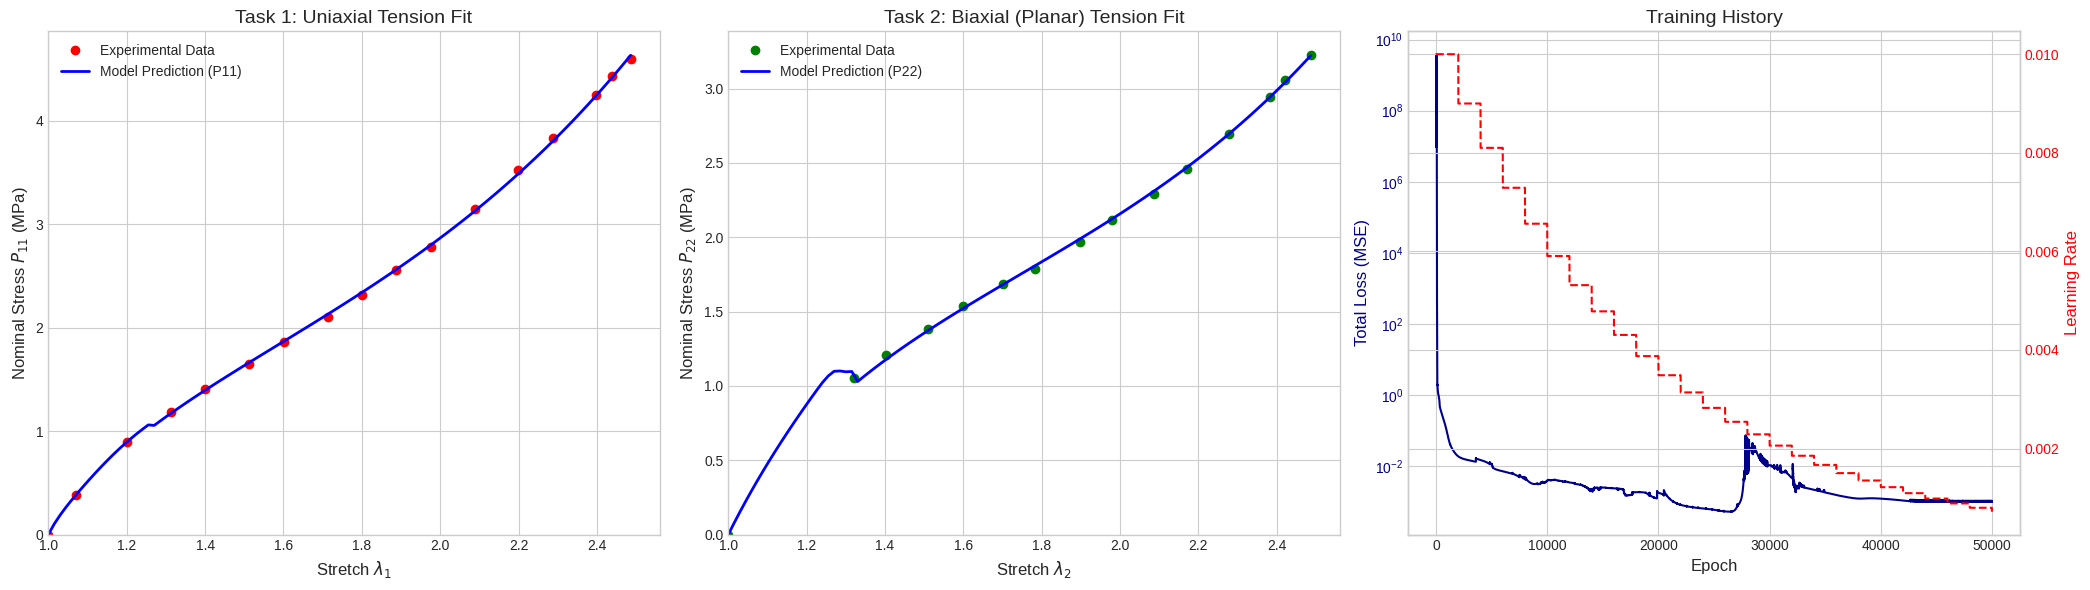

In [ ]:
# !pip install tensorflow -q

import tensorflow as tf
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

# --- Setup and Constants ---
tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

# --- Model Definition (No changes needed here) ---
class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # k & i params (exponents) - All parameters are now trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        # Coefficients
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b1=self.add_weight(name="raw_log_b1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)
    def _term_power_law(self, I, k, i, c, ref_val): return c * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def call(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)
        b1=tf.exp(self.raw_log_b1);b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)
        W = tf.zeros_like(I1,dtype=tf.float64)
        W += self._term_power_law(I1,k1,i1,a1,self.three); W += self._term_power_law(I2,k2,i2,a2,self.three)
        W += self._term_exponential(I1,k3,i3,a3_prime,a3,self.three); W += self._term_exponential(I2,k4,i4,a4_prime,a4,self.three)
        W += self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three); W += self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three)
        W += self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three); W += self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three)
        W += self._term_identity_scaled(I4,k9,b1,self.one); W += self._term_identity_scaled(I6,k10,b2,self.one)
        W += self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one); W += self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one)
        W += self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one); W += self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one)
        W += self._term_sinh(I4,k15,b7_prime,b7,self.one); W += self._term_sinh(I6,k16,b8_prime,b8,self.one)
        return W

# --- Helper and Physics Functions ---

@tf.function
def get_invariants_tf(lambda1, lambda2, lambda3):
    min_lambda_val = tf.constant(1e-6, dtype=tf.float64)
    lambda1 = tf.maximum(lambda1, min_lambda_val)
    lambda2 = tf.maximum(lambda2, min_lambda_val)
    lambda3 = tf.maximum(lambda3, min_lambda_val)
    l1s = tf.pow(lambda1, 2.0); l2s = tf.pow(lambda2, 2.0); l3s = tf.pow(lambda3, 2.0)
    I1 = l1s + l2s + l3s
    I2 = tf.pow(lambda1 * lambda2, 2.0) + tf.pow(lambda2 * lambda3, 2.0) + tf.pow(lambda3 * lambda1, 2.0)
    I4 = l1s; I6 = tf.pow(lambda1, -4.0)
    return I1, I2, I4, I6

@tf.function
def predict_uniaxial_p11(lambda1, model):
    l1 = lambda1
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l3_t])
    dWdl1, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    return P11

@tf.function
def get_biaxial_stresses(l1, l2, model):
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1); l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l2_t, l3_t])
    dWdl1, dWdl2, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1], dW_d_lambdas[2]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    P22 = dWdl2 - p / l2_t
    return P11, P22

@tf.function
def predict_biaxial_p22(lambda2, model):
    l2 = lambda2
    l1_sol = tf.pow(l2, -0.5)
    for _ in range(8):
        with tf.GradientTape() as tape:
            tape.watch(l1_sol)
            P11_val, _ = get_biaxial_stresses(l1_sol, l2, model)
        dP11_dl1 = tape.gradient(P11_val, l1_sol)
        l1_sol = l1_sol - P11_val / (dP11_dl1 + 1e-4)
    final_l1 = tf.stop_gradient(l1_sol)
    _, P22_final = get_biaxial_stresses(final_l1, l2, model)
    return P22_final

# --- Experimental Data ---
exp_data_raw_uniaxial_cnf = np.array([
    [1.0000, 0], [1.0708, 0.3840], [1.2017, 0.8987], [1.3125, 1.1814], [1.4000, 1.4093],
    [1.5125, 1.6456], [1.6017, 1.8608], [1.7125, 2.1055], [1.8008, 2.3122], [1.8883, 2.5570],
    [1.9767, 2.7848], [2.0883, 3.1519], [2.1992, 3.5274], [2.2867, 3.8354], [2.3975, 4.2532],
    [2.4383, 4.4304], [2.4858, 4.5949]
])

exp_data_raw_biaxial_cnf = np.array([
    [1.0000, 0], [1.3208, 1.0506], [1.4017, 1.2068], [1.5092, 1.3840], [1.5983, 1.5401],
    [1.7017, 1.6835], [1.7842, 1.7848], [1.8967, 1.9662], [1.9792, 2.1181], [2.0858, 2.2911],
    [2.1708, 2.4599], [2.2783, 2.6962], [2.3825, 2.9409], [2.4225, 3.0549], [2.4867, 3.2236]
])

uniaxial_l1, uniaxial_p11 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_uniaxial_cnf.T]
biaxial_l2, biaxial_p22 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_biaxial_cnf.T]

# --- Training with Improvements ---
model = StrainEnergyANN_Layered_TF()

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=2000, decay_rate=0.9, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_weight_biaxial = tf.reduce_mean(tf.square(uniaxial_p11)) / tf.reduce_mean(tf.square(biaxial_p22))
print(f"Biaxial Loss Weight: {loss_weight_biaxial.numpy():.2f}")

loss_history = []
learning_rate_history = []

@tf.function
def train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight):
    with tf.GradientTape() as tape:
        p11_pred = predict_uniaxial_p11(uniaxial_l1, model)
        loss1 = tf.reduce_mean(tf.square(p11_pred - uniaxial_p11))

        p22_pred = predict_biaxial_p22(biaxial_l2, model)
        loss2 = tf.reduce_mean(tf.square(p22_pred - biaxial_p22))

        total_loss = loss1 + loss_weight * loss2

    grads = tape.gradient(total_loss, model.trainable_variables)
    # Add robust gradient clipping
    grads = [tf.clip_by_value(g, -1.0, 1.0) if g is not None else g for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, loss1, loss2

epochs = 50000
for epoch in range(epochs):
    total_loss, loss1, loss2 = train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight_biaxial)
    loss_history.append(total_loss.numpy())

    # --- THIS IS THE CORRECTED SECTION ---
    # Get the current learning rate by calling the schedule object with the optimizer's iteration count
    current_lr = lr_schedule(optimizer.iterations)
    learning_rate_history.append(current_lr)

    if epoch % 1000 == 0:
        # Use the correctly retrieved learning rate for printing
        print(f"Epoch {epoch:5d}, Loss: {total_loss:.4f} (Uni: {loss1:.4f}, Bi: {loss2:.4f}), LR: {current_lr:.6f}")

print(f"\nTraining finished. Final Loss: {loss_history[-1]:.4f}")


# --- Visualization ---
l1_plot = np.linspace(1.0, exp_data_raw_uniaxial_cnf[:, 0].max(), 100)
p11_pred_plot = predict_uniaxial_p11(tf.constant(l1_plot, dtype=tf.float64), model).numpy()

l2_plot = np.linspace(1.0, exp_data_raw_biaxial_cnf[:, 0].max(), 100)
p22_pred_plot = predict_biaxial_p22(tf.constant(l2_plot, dtype=tf.float64), model).numpy()

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

axes[0].plot(exp_data_raw_uniaxial_cnf[:, 0], exp_data_raw_uniaxial_cnf[:, 1], 'ro', label='Experimental Data')
axes[0].plot(l1_plot, p11_pred_plot, 'b-', lw=2, label='Model Prediction (P11)')
axes[0].set_xlabel('Stretch $\\lambda_1$', fontsize=12)
axes[0].set_ylabel('Nominal Stress $P_{11}$ (MPa)', fontsize=12)
axes[0].set_title('Task 1: Uniaxial Tension Fit', fontsize=14)
axes[0].legend()
axes[0].set_ylim(bottom=0); axes[0].set_xlim(left=1)

axes[1].plot(exp_data_raw_biaxial_cnf[:, 0], exp_data_raw_biaxial_cnf[:, 1], 'go', label='Experimental Data')
axes[1].plot(l2_plot, p22_pred_plot, 'b-', lw=2, label='Model Prediction (P22)')
axes[1].set_xlabel('Stretch $\\lambda_2$', fontsize=12)
axes[1].set_ylabel('Nominal Stress $P_{22}$ (MPa)', fontsize=12)
axes[1].set_title('Task 2: Biaxial (Planar) Tension Fit', fontsize=14)
axes[1].legend()
axes[1].set_ylim(bottom=0); axes[1].set_xlim(left=1)

ax2 = axes[2]
ax2.plot(loss_history, label='Total Loss', color='darkblue')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Total Loss (MSE)', fontsize=12, color='darkblue')
ax2.set_title('Training History', fontsize=14)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='darkblue')

ax3 = ax2.twinx()
ax3.plot(learning_rate_history, label='Learning Rate', color='red', linestyle='--')
ax3.set_ylabel('Learning Rate', fontsize=12, color='red')
ax3.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()

Using device: /CPU:0
Biaxial Loss Weight: 1.69
Epoch     0, Loss: 3281270954.0999 (Uni: 1484354071.4952, Bi: 1063706822.5571), LR: 0.010000
Epoch  1000, Loss: 0.0886 (Uni: 0.0668, Bi: 0.0129), LR: 0.010000
Epoch  2000, Loss: 0.0195 (Uni: 0.0036, Bi: 0.0094), LR: 0.009000
Epoch  3000, Loss: 0.0155 (Uni: 0.0015, Bi: 0.0083), LR: 0.009000
Epoch  4000, Loss: 0.0128 (Uni: 0.0010, Bi: 0.0070), LR: 0.008100
Epoch  5000, Loss: 0.0110 (Uni: 0.0009, Bi: 0.0060), LR: 0.008100
Epoch  6000, Loss: 0.0073 (Uni: 0.0009, Bi: 0.0038), LR: 0.007290
Epoch  7000, Loss: 0.0061 (Uni: 0.0011, Bi: 0.0030), LR: 0.007290
Epoch  8000, Loss: 0.0045 (Uni: 0.0012, Bi: 0.0020), LR: 0.006561
Epoch  9000, Loss: 0.0033 (Uni: 0.0011, Bi: 0.0013), LR: 0.006561
Epoch 10000, Loss: 0.0041 (Uni: 0.0010, Bi: 0.0019), LR: 0.005905
Epoch 11000, Loss: 0.0039 (Uni: 0.0009, Bi: 0.0018), LR: 0.005905
Epoch 12000, Loss: 0.0035 (Uni: 0.0009, Bi: 0.0016), LR: 0.005314
Epoch 13000, Loss: 0.0030 (Uni: 0.0008, Bi: 0.0013), LR: 0.005314
Ep

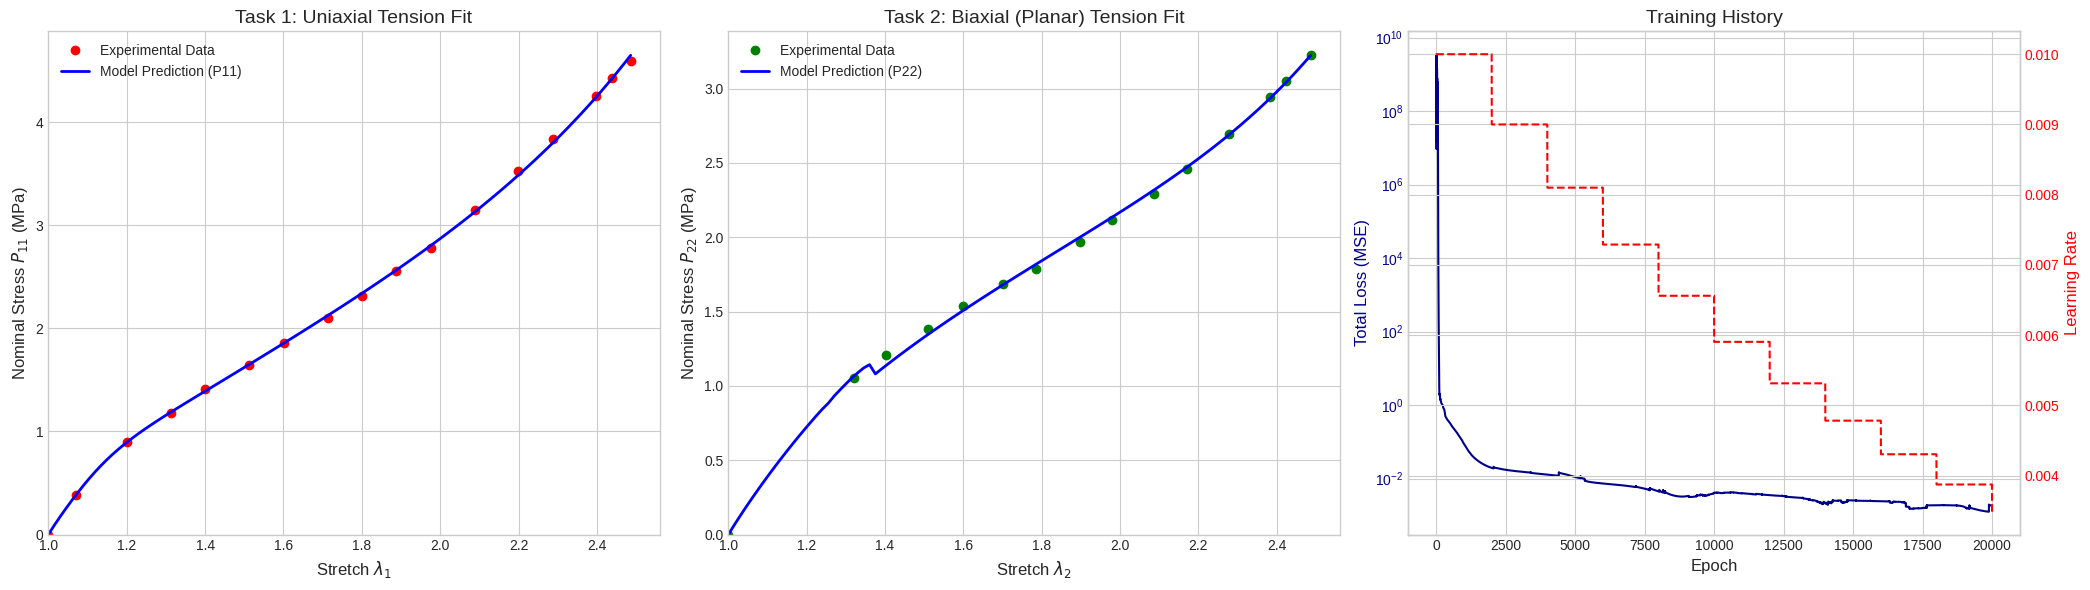

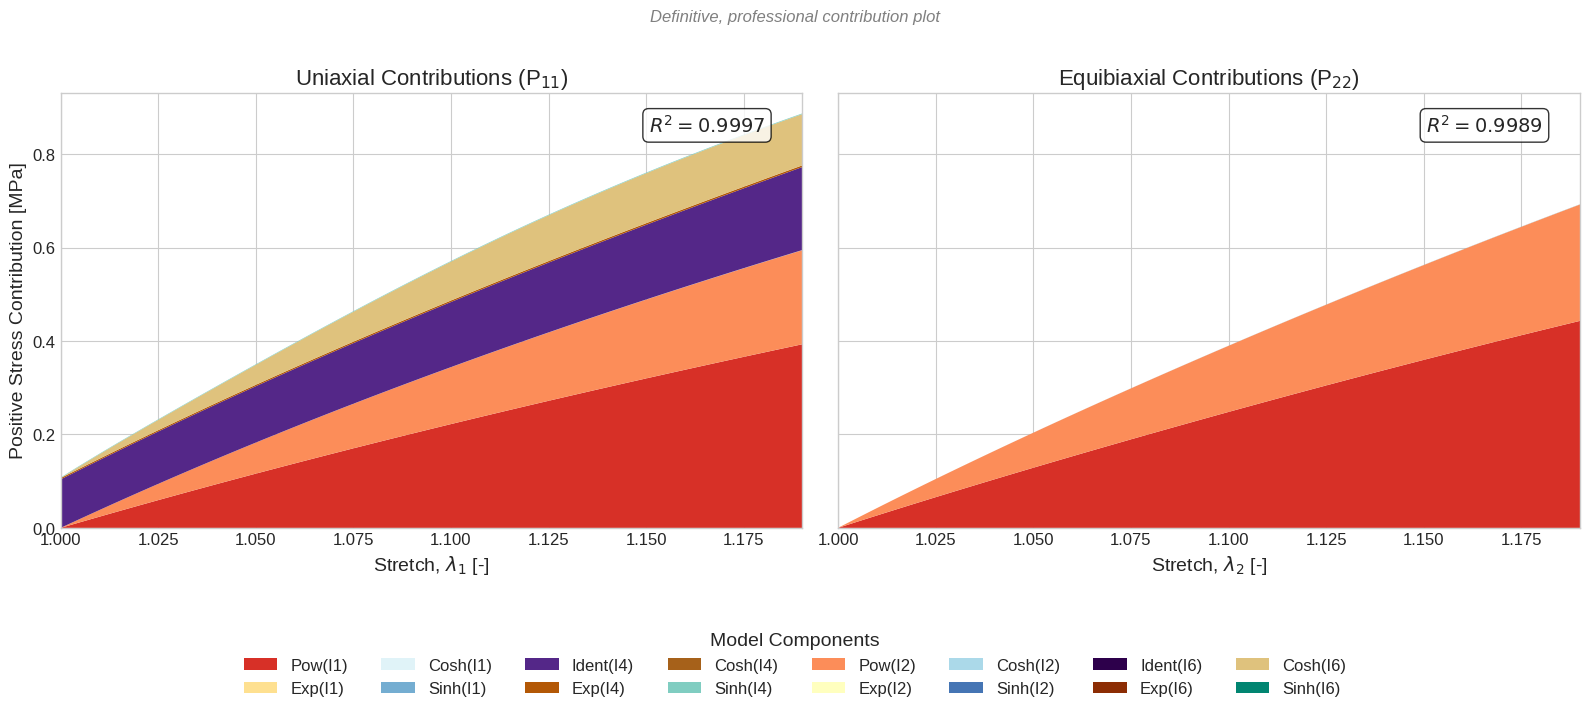

In [ ]:
# !pip install tensorflow -q

import tensorflow as tf
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

# --- Setup and Constants ---
tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

# --- Model Definition (Modified to return components) ---
class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # k & i params (exponents) - All parameters are now trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        # Coefficients
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b1=self.add_weight(name="raw_log_b1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)
    def _term_power_law(self, I, k, i, c, ref_val): return c * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))

    def call(self, I1, I2, I4, I6):
        W_components = self.call_components(I1, I2, I4, I6)
        return tf.add_n(W_components)

    def call_components(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)
        b1=tf.exp(self.raw_log_b1);b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)

        components = []
        components.append(self._term_power_law(I1,k1,i1,a1,self.three)); components.append(self._term_power_law(I2,k2,i2,a2,self.three))
        components.append(self._term_exponential(I1,k3,i3,a3_prime,a3,self.three)); components.append(self._term_exponential(I2,k4,i4,a4_prime,a4,self.three))
        components.append(self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three)); components.append(self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three))
        components.append(self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three)); components.append(self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three))
        components.append(self._term_identity_scaled(I4,k9,b1,self.one)); components.append(self._term_identity_scaled(I6,k10,b2,self.one))
        components.append(self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one)); components.append(self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one))
        components.append(self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one)); components.append(self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one))
        components.append(self._term_sinh(I4,k15,b7_prime,b7,self.one)); components.append(self._term_sinh(I6,k16,b8_prime,b8,self.one))
        return components

# --- Helper and Physics Functions ---

@tf.function
def get_invariants_tf(lambda1, lambda2, lambda3):
    min_lambda_val = tf.constant(1e-6, dtype=tf.float64)
    lambda1 = tf.maximum(lambda1, min_lambda_val)
    lambda2 = tf.maximum(lambda2, min_lambda_val)
    lambda3 = tf.maximum(lambda3, min_lambda_val)
    l1s = tf.pow(lambda1, 2.0); l2s = tf.pow(lambda2, 2.0); l3s = tf.pow(lambda3, 2.0)
    I1 = l1s + l2s + l3s
    I2 = tf.pow(lambda1 * lambda2, 2.0) + tf.pow(lambda2 * lambda3, 2.0) + tf.pow(lambda3 * lambda1, 2.0)
    I4 = l1s; I6 = tf.pow(lambda1, -4.0)
    return I1, I2, I4, I6

@tf.function
def predict_uniaxial_p11(lambda1, model):
    l1 = lambda1
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l3_t])
    dWdl1, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    return P11

@tf.function
def get_biaxial_stresses(l1, l2, model):
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1); l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l2_t, l3_t])
    dWdl1, dWdl2, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1], dW_d_lambdas[2]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    P22 = dWdl2 - p / l2_t
    return P11, P22

@tf.function
def predict_biaxial_p22(lambda2, model):
    l2 = lambda2
    l1_sol = tf.pow(l2, -0.5)
    for _ in range(8):
        with tf.GradientTape() as tape:
            tape.watch(l1_sol)
            P11_val, _ = get_biaxial_stresses(l1_sol, l2, model)
        dP11_dl1 = tape.gradient(P11_val, l1_sol)
        l1_sol = l1_sol - P11_val / (dP11_dl1 + 1e-4)
    final_l1 = tf.stop_gradient(l1_sol)
    _, P22_final = get_biaxial_stresses(final_l1, l2, model)
    return P22_final

# --- Experimental Data ---
exp_data_raw_uniaxial_cnf = np.array([
    [1.0000, 0], [1.0708, 0.3840], [1.2017, 0.8987], [1.3125, 1.1814], [1.4000, 1.4093],
    [1.5125, 1.6456], [1.6017, 1.8608], [1.7125, 2.1055], [1.8008, 2.3122], [1.8883, 2.5570],
    [1.9767, 2.7848], [2.0883, 3.1519], [2.1992, 3.5274], [2.2867, 3.8354], [2.3975, 4.2532],
    [2.4383, 4.4304], [2.4858, 4.5949]
])

exp_data_raw_biaxial_cnf = np.array([
    [1.0000, 0], [1.3208, 1.0506], [1.4017, 1.2068], [1.5092, 1.3840], [1.5983, 1.5401],
    [1.7017, 1.6835], [1.7842, 1.7848], [1.8967, 1.9662], [1.9792, 2.1181], [2.0858, 2.2911],
    [2.1708, 2.4599], [2.2783, 2.6962], [2.3825, 2.9409], [2.4225, 3.0549], [2.4867, 3.2236]
])

uniaxial_l1, uniaxial_p11 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_uniaxial_cnf.T]
biaxial_l2, biaxial_p22 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_biaxial_cnf.T]

# --- Training with Improvements ---
model = StrainEnergyANN_Layered_TF()

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=2000, decay_rate=0.9, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_weight_biaxial = tf.reduce_mean(tf.square(uniaxial_p11)) / tf.reduce_mean(tf.square(biaxial_p22))
print(f"Biaxial Loss Weight: {loss_weight_biaxial.numpy():.2f}")

loss_history = []
learning_rate_history = []

@tf.function
def train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight):
    with tf.GradientTape() as tape:
        p11_pred = predict_uniaxial_p11(uniaxial_l1, model)
        loss1 = tf.reduce_mean(tf.square(p11_pred - uniaxial_p11))

        p22_pred = predict_biaxial_p22(biaxial_l2, model)
        loss2 = tf.reduce_mean(tf.square(p22_pred - biaxial_p22))

        total_loss = loss1 + loss_weight * loss2

    grads = tape.gradient(total_loss, model.trainable_variables)
    grads = [tf.clip_by_value(g, -1.0, 1.0) if g is not None else g for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, loss1, loss2

epochs = 20000
for epoch in range(epochs):
    total_loss, loss1, loss2 = train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight_biaxial)
    loss_history.append(total_loss.numpy())
    current_lr = lr_schedule(optimizer.iterations)
    learning_rate_history.append(current_lr)

    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d}, Loss: {total_loss:.4f} (Uni: {loss1:.4f}, Bi: {loss2:.4f}), LR: {current_lr:.6f}")

print(f"\nTraining finished. Final Loss: {loss_history[-1]:.4f}")


# --- Visualization (Original Fit Plots) ---
l1_plot = np.linspace(1.0, exp_data_raw_uniaxial_cnf[:, 0].max(), 100)
p11_pred_plot = predict_uniaxial_p11(tf.constant(l1_plot, dtype=tf.float64), model).numpy()

l2_plot = np.linspace(1.0, exp_data_raw_biaxial_cnf[:, 0].max(), 100)
p22_pred_plot = predict_biaxial_p22(tf.constant(l2_plot, dtype=tf.float64), model).numpy()

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

axes[0].plot(exp_data_raw_uniaxial_cnf[:, 0], exp_data_raw_uniaxial_cnf[:, 1], 'ro', label='Experimental Data')
axes[0].plot(l1_plot, p11_pred_plot, 'b-', lw=2, label='Model Prediction (P11)')
axes[0].set_xlabel('Stretch $\\lambda_1$', fontsize=12)
axes[0].set_ylabel('Nominal Stress $P_{11}$ (MPa)', fontsize=12)
axes[0].set_title('Task 1: Uniaxial Tension Fit', fontsize=14)
axes[0].legend()
axes[0].set_ylim(bottom=0); axes[0].set_xlim(left=1)

axes[1].plot(exp_data_raw_biaxial_cnf[:, 0], exp_data_raw_biaxial_cnf[:, 1], 'go', label='Experimental Data')
axes[1].plot(l2_plot, p22_pred_plot, 'b-', lw=2, label='Model Prediction (P22)')
axes[1].set_xlabel('Stretch $\\lambda_2$', fontsize=12)
axes[1].set_ylabel('Nominal Stress $P_{22}$ (MPa)', fontsize=12)
axes[1].set_title('Task 2: Biaxial (Planar) Tension Fit', fontsize=14)
axes[1].legend()
axes[1].set_ylim(bottom=0); axes[1].set_xlim(left=1)

ax2 = axes[2]
ax2.plot(loss_history, label='Total Loss', color='darkblue')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Total Loss (MSE)', fontsize=12, color='darkblue')
ax2.set_title('Training History', fontsize=14)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='darkblue')

ax3 = ax2.twinx()
ax3.plot(learning_rate_history, label='Learning Rate', color='red', linestyle='--')
ax3.set_ylabel('Learning Rate', fontsize=12, color='red')
ax3.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()

# ==============================================================================
# --- NEW CODE FOR CONTRIBUTION PLOTS ---
# ==============================================================================

# --- Functions to Calculate Stress Contributions from Each W Term ---

@tf.function
def get_uniaxial_p11_contributions(lambda1, model):
    components_p11 = []
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(lambda1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W_components = model.call_components(I1, I2, I4, I6)

    for W_j in W_components:
        grads = tape.gradient(W_j, [l1_t, l3_t])
        dWjdl1 = grads[0] if grads[0] is not None else tf.zeros_like(l1_t)
        dWjdl3 = grads[1] if grads[1] is not None else tf.zeros_like(l3_t)
        pj = l3_t * dWjdl3
        P11_j = dWjdl1 - pj / l1_t
        components_p11.append(P11_j)
    del tape
    return tf.stack(components_p11, axis=1)

@tf.function
def get_biaxial_p22_contributions(l1_solved, l2, model):
    components_p22 = []
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1_solved)
        l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W_components = model.call_components(I1, I2, I4, I6)

    for W_j in W_components:
        grads = tape.gradient(W_j, [l2_t, l3_t])
        dWjdl2 = grads[0] if grads[0] is not None else tf.zeros_like(l2_t)
        dWjdl3 = grads[1] if grads[1] is not None else tf.zeros_like(l3_t)
        pj = l3_t * dWjdl3
        P22_j = dWjdl2 - pj / l2_t
        components_p22.append(P22_j)
    del tape
    return tf.stack(components_p22, axis=1)

# --- Prepare Data for Contribution Plots ---

# 1. Define plot range, labels, and colors
l_plot_contrib = tf.constant(np.linspace(1.0, 1.19, 200), dtype=tf.float64)

labels = [
    'Pow(I1)', 'Pow(I2)', 'Exp(I1)', 'Exp(I2)',
    'Cosh(I1)', 'Cosh(I2)', 'Sinh(I1)', 'Sinh(I2)',
    'Ident(I4)', 'Ident(I6)', 'Exp(I4)', 'Exp(I6)',
    'Cosh(I4)', 'Cosh(I6)', 'Sinh(I4)', 'Sinh(I6)'
]

# Colors designed to group model terms visually, similar to the example
colors = [
    '#d73027', '#fc8d59',  # Pow: Reds
    '#fee090', '#ffffbf',  # Exp: Yellows
    '#e0f3f8', '#abd9e9',  # Cosh: Light Blues
    '#74add1', '#4575b4',  # Sinh: Blues
    '#542788', '#2d004b',  # Ident: Purples
    '#b35806', '#8c2d04',  # Exp (I4,I6): Browns
    '#a6611a', '#dfc27d',  # Cosh (I4,I6): Light Browns
    '#80cdc1', '#018571'   # Sinh (I4,I6): Teals
]

# 2. Calculate Uniaxial Contributions
p11_contribs_raw = get_uniaxial_p11_contributions(l_plot_contrib, model).numpy()
p11_contribs_plot = np.maximum(0, p11_contribs_raw) # Keep only positive contributions

# 3. Calculate Biaxial Contributions
# First, solve for l1 at each l2 in the plot range using Newton's method
l1_sol_plot = []
for l2_val in l_plot_contrib.numpy():
    l1_sol = tf.pow(l2_val, -0.5)
    for _ in range(8):
        with tf.GradientTape() as tape:
            l1_sol_t = tf.constant(l1_sol, dtype=tf.float64)
            tape.watch(l1_sol_t)
            P11_val, _ = get_biaxial_stresses(l1_sol_t, tf.constant(l2_val, dtype=tf.float64), model)
        dP11_dl1 = tape.gradient(P11_val, l1_sol_t)
        l1_sol = l1_sol - P11_val / (dP11_dl1 + 1e-6)
    l1_sol_plot.append(l1_sol.numpy())
l1_sol_plot_tf = tf.constant(np.array(l1_sol_plot), dtype=tf.float64)

# Now calculate the P22 contributions
p22_contribs_raw = get_biaxial_p22_contributions(l1_sol_plot_tf, l_plot_contrib, model).numpy()
p22_contribs_plot = np.maximum(0, p22_contribs_raw)

# 4. Calculate R-squared values for annotations
p11_pred_on_exp = predict_uniaxial_p11(uniaxial_l1, model).numpy()
ss_res_uni = np.sum((uniaxial_p11.numpy() - p11_pred_on_exp)**2)
ss_tot_uni = np.sum((uniaxial_p11.numpy() - np.mean(uniaxial_p11.numpy()))**2)
r2_uni = 1 - (ss_res_uni / ss_tot_uni)

p22_pred_on_exp = predict_biaxial_p22(biaxial_l2, model).numpy()
ss_res_bi = np.sum((biaxial_p22.numpy() - p22_pred_on_exp)**2)
ss_tot_bi = np.sum((biaxial_p22.numpy() - np.mean(biaxial_p22.numpy()))**2)
r2_bi = 1 - (ss_res_bi / ss_tot_bi)


# --- Generate the Final Contribution Plot ---
fig_contrib, axes_contrib = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.style.use('seaborn-v0_8-whitegrid')

# Uniaxial Plot
ax = axes_contrib[0]
ax.stackplot(l_plot_contrib, p11_contribs_plot.T, labels=labels, colors=colors)
ax.set_title('Uniaxial Contributions (P$_{11}$)', fontsize=16)
ax.set_xlabel('Stretch, $\\lambda_1$ [-]', fontsize=14)
ax.set_ylabel('Positive Stress Contribution [MPa]', fontsize=14)
ax.set_xlim(l_plot_contrib.numpy().min(), l_plot_contrib.numpy().max())
ax.set_ylim(bottom=0)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(0.95, 0.95, f'$R^2 = {r2_uni:.4f}$', transform=ax.transAxes,
        fontsize=14, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Biaxial Plot
ax = axes_contrib[1]
ax.stackplot(l_plot_contrib, p22_contribs_plot.T, labels=labels, colors=colors)
ax.set_title('Equibiaxial Contributions (P$_{22}$)', fontsize=16)
ax.set_xlabel('Stretch, $\\lambda_2$ [-]', fontsize=14)
ax.set_xlim(l_plot_contrib.numpy().min(), l_plot_contrib.numpy().max())
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(0.95, 0.95, f'$R^2 = {r2_bi:.4f}$', transform=ax.transAxes,
        fontsize=14, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Create a shared legend at the bottom
handles, labels_from_plot = axes_contrib[0].get_legend_handles_labels()
# Manually create the desired legend structure from the example
legend_labels_part1 = [
    'Pow(I1)', 'Exp(I1)', 'Cosh(I1)', 'Sinh(I1)', 'Ident(I4)', 'Exp(I4)', 'Cosh(I4)', 'Sinh(I4)'
]
legend_labels_part2 = [
    'Pow(I2)', 'Exp(I2)', 'Cosh(I2)', 'Sinh(I2)', 'Ident(I6)', 'Exp(I6)', 'Cosh(I6)', 'Sinh(I6)'
]
# Create a dictionary to map labels to handles and colors
handle_map = {label: handle for label, handle in zip(labels_from_plot, handles)}

# Reorder handles and labels for the legend
final_handles = [handle_map[lbl] for lbl in legend_labels_part1 + legend_labels_part2]
final_labels = legend_labels_part1 + legend_labels_part2

fig_contrib.legend(final_handles, final_labels,
                   loc='lower center',
                   bbox_to_anchor=(0.5, -0.15),
                   ncol=8,
                   title='Model Components',
                   fontsize=12,
                   title_fontsize=14)

fig_contrib.suptitle("Definitive, professional contribution plot", y=1.02, fontsize=12, style='italic', color='gray')

fig_contrib.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout to make space for legend
plt.savefig("Final_Contribution_Plots.pdf", bbox_inches='tight')
plt.show()

Using device: /CPU:0
Biaxial Loss Weight: 1.69
Epoch     0, Loss: 1745302522.2168 (Uni: 782950967.7129, Bi: 569675717.4101), LR: 0.010000
Epoch  1000, Loss: 0.0906 (Uni: 0.0693, Bi: 0.0126), LR: 0.010000
Epoch  2000, Loss: 0.0187 (Uni: 0.0035, Bi: 0.0090), LR: 0.009000
Epoch  3000, Loss: 0.0145 (Uni: 0.0013, Bi: 0.0078), LR: 0.009000
Epoch  4000, Loss: 0.0146 (Uni: 0.0011, Bi: 0.0080), LR: 0.008100
Epoch  5000, Loss: 0.0097 (Uni: 0.0009, Bi: 0.0052), LR: 0.008100
Epoch  6000, Loss: 0.0072 (Uni: 0.0009, Bi: 0.0037), LR: 0.007290
Epoch  7000, Loss: 0.0059 (Uni: 0.0011, Bi: 0.0028), LR: 0.007290
Epoch  8000, Loss: 0.0048 (Uni: 0.0011, Bi: 0.0022), LR: 0.006561
Epoch  9000, Loss: 0.0032 (Uni: 0.0011, Bi: 0.0012), LR: 0.006561
Epoch 10000, Loss: 0.0039 (Uni: 0.0010, Bi: 0.0017), LR: 0.005905
Epoch 11000, Loss: 0.0039 (Uni: 0.0009, Bi: 0.0018), LR: 0.005905
Epoch 12000, Loss: 0.0035 (Uni: 0.0009, Bi: 0.0016), LR: 0.005314
Epoch 13000, Loss: 0.0030 (Uni: 0.0008, Bi: 0.0013), LR: 0.005314
Epoc

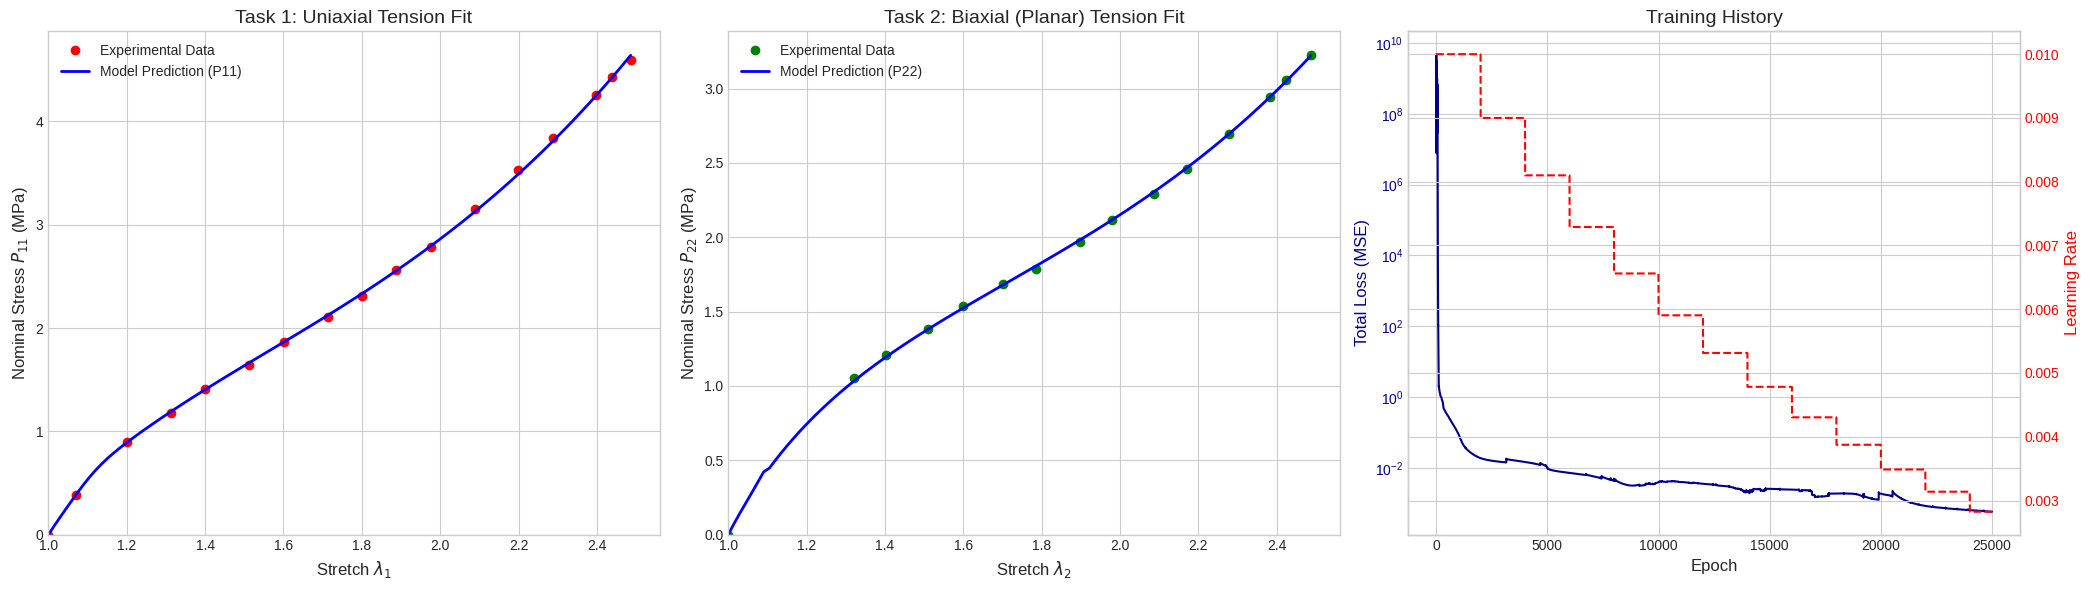

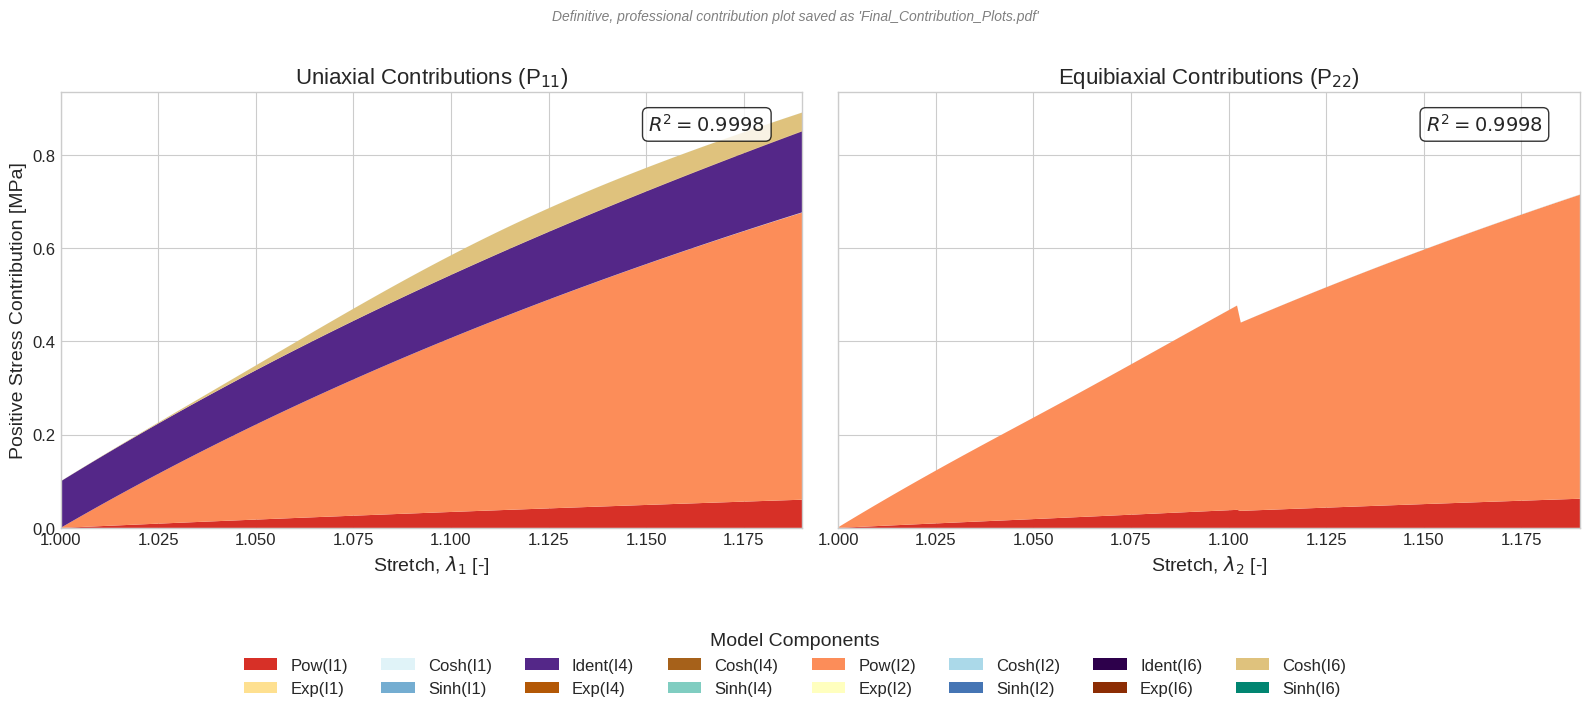

In [ ]:
# !pip install tensorflow -q

import tensorflow as tf
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

# --- Setup and Constants ---
tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

# --- Model Definition (Modified to return components) ---
class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # k & i params (exponents) - All parameters are now trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        # Coefficients
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b1=self.add_weight(name="raw_log_b1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)
    def _term_power_law(self, I, k, i, c, ref_val): return c * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))

    def call(self, I1, I2, I4, I6):
        W_components = self.call_components(I1, I2, I4, I6)
        return tf.add_n(W_components)

    def call_components(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)
        b1=tf.exp(self.raw_log_b1);b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)

        components = []
        components.append(self._term_power_law(I1,k1,i1,a1,self.three)); components.append(self._term_power_law(I2,k2,i2,a2,self.three))
        components.append(self._term_exponential(I1,k3,i3,a3_prime,a3,self.three)); components.append(self._term_exponential(I2,k4,i4,a4_prime,a4,self.three))
        components.append(self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three)); components.append(self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three))
        components.append(self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three)); components.append(self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three))
        components.append(self._term_identity_scaled(I4,k9,b1,self.one)); components.append(self._term_identity_scaled(I6,k10,b2,self.one))
        components.append(self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one)); components.append(self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one))
        components.append(self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one)); components.append(self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one))
        components.append(self._term_sinh(I4,k15,b7_prime,b7,self.one)); components.append(self._term_sinh(I6,k16,b8_prime,b8,self.one))
        return components

# --- Helper and Physics Functions ---

@tf.function
def get_invariants_tf(lambda1, lambda2, lambda3):
    min_lambda_val = tf.constant(1e-6, dtype=tf.float64)
    lambda1 = tf.maximum(lambda1, min_lambda_val)
    lambda2 = tf.maximum(lambda2, min_lambda_val)
    lambda3 = tf.maximum(lambda3, min_lambda_val)
    l1s = tf.pow(lambda1, 2.0); l2s = tf.pow(lambda2, 2.0); l3s = tf.pow(lambda3, 2.0)
    I1 = l1s + l2s + l3s
    I2 = tf.pow(lambda1 * lambda2, 2.0) + tf.pow(lambda2 * lambda3, 2.0) + tf.pow(lambda3 * lambda1, 2.0)
    I4 = l1s; I6 = tf.pow(lambda1, -4.0)
    return I1, I2, I4, I6

@tf.function
def predict_uniaxial_p11(lambda1, model):
    l1 = lambda1
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l3_t])
    dWdl1, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    return P11

@tf.function
def get_biaxial_stresses(l1, l2, model):
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1); l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l2_t, l3_t])
    dWdl1, dWdl2, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1], dW_d_lambdas[2]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    P22 = dWdl2 - p / l2_t
    return P11, P22

@tf.function
def predict_biaxial_p22(lambda2, model):
    l2 = lambda2
    l1_sol = tf.pow(l2, -0.5)
    for _ in range(8):
        with tf.GradientTape() as tape:
            tape.watch(l1_sol)
            P11_val, _ = get_biaxial_stresses(l1_sol, l2, model)
        dP11_dl1 = tape.gradient(P11_val, l1_sol)
        l1_sol = l1_sol - P11_val / (dP11_dl1 + 1e-4)
    final_l1 = tf.stop_gradient(l1_sol)
    _, P22_final = get_biaxial_stresses(final_l1, l2, model)
    return P22_final

# --- Experimental Data ---
exp_data_raw_uniaxial_cnf = np.array([
    [1.0000, 0], [1.0708, 0.3840], [1.2017, 0.8987], [1.3125, 1.1814], [1.4000, 1.4093],
    [1.5125, 1.6456], [1.6017, 1.8608], [1.7125, 2.1055], [1.8008, 2.3122], [1.8883, 2.5570],
    [1.9767, 2.7848], [2.0883, 3.1519], [2.1992, 3.5274], [2.2867, 3.8354], [2.3975, 4.2532],
    [2.4383, 4.4304], [2.4858, 4.5949]
])

exp_data_raw_biaxial_cnf = np.array([
    [1.0000, 0], [1.3208, 1.0506], [1.4017, 1.2068], [1.5092, 1.3840], [1.5983, 1.5401],
    [1.7017, 1.6835], [1.7842, 1.7848], [1.8967, 1.9662], [1.9792, 2.1181], [2.0858, 2.2911],
    [2.1708, 2.4599], [2.2783, 2.6962], [2.3825, 2.9409], [2.4225, 3.0549], [2.4867, 3.2236]
])

uniaxial_l1, uniaxial_p11 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_uniaxial_cnf.T]
biaxial_l2, biaxial_p22 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_biaxial_cnf.T]

# --- Training with Improvements ---
model = StrainEnergyANN_Layered_TF()

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=2000, decay_rate=0.9, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_weight_biaxial = tf.reduce_mean(tf.square(uniaxial_p11)) / tf.reduce_mean(tf.square(biaxial_p22))
print(f"Biaxial Loss Weight: {loss_weight_biaxial.numpy():.2f}")

loss_history = []
learning_rate_history = []

@tf.function
def train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight):
    with tf.GradientTape() as tape:
        p11_pred = predict_uniaxial_p11(uniaxial_l1, model)
        loss1 = tf.reduce_mean(tf.square(p11_pred - uniaxial_p11))

        p22_pred = predict_biaxial_p22(biaxial_l2, model)
        loss2 = tf.reduce_mean(tf.square(p22_pred - biaxial_p22))

        total_loss = loss1 + loss_weight * loss2

    grads = tape.gradient(total_loss, model.trainable_variables)
    grads = [tf.clip_by_value(g, -1.0, 1.0) if g is not None else g for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, loss1, loss2

epochs = 25000
for epoch in range(epochs):
    total_loss, loss1, loss2 = train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight_biaxial)
    loss_history.append(total_loss.numpy())
    current_lr = lr_schedule(optimizer.iterations)
    learning_rate_history.append(current_lr)

    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d}, Loss: {total_loss:.4f} (Uni: {loss1:.4f}, Bi: {loss2:.4f}), LR: {current_lr:.6f}")

print(f"\nTraining finished. Final Loss: {loss_history[-1]:.4f}")


# ==============================================================================
# --- NEW CODE FOR PRINTING FINAL PARAMETERS ---
# ==============================================================================
print("\n" + "="*50)
print("--- Final Model Parameters ---")
print("="*50)

final_params = {}

# Exponents (k and i)
for i in range(1, 17):
    raw_val = getattr(model, f'raw_log_k{i}')
    offset = 1.5 if i % 2 == 0 else 1.0 # k2, k4, ... have offset 1.5
    final_params[f'k{i}'] = offset + tf.exp(raw_val).numpy()

for i in range(1, 9):
    raw_val = getattr(model, f'raw_log_i{i}')
    final_params[f'i{i}'] = 1.0 + tf.exp(raw_val).numpy()

# Coefficients (a and b)
for i in range(1, 9):
    raw_val = getattr(model, f'raw_log_a{i}')
    final_params[f'a{i}'] = tf.exp(raw_val).numpy()
for i in range(1, 9):
    raw_val = getattr(model, f'raw_log_b{i}')
    final_params[f'b{i}'] = tf.exp(raw_val).numpy()

# Prime coefficients (a' and b')
for i in range(3, 9):
    raw_val = getattr(model, f'raw_log_a{i}_prime')
    final_params[f'a{i}_prime'] = tf.exp(raw_val).numpy()
for i in range(3, 9):
    raw_val = getattr(model, f'raw_log_b{i}_prime')
    final_params[f'b{i}_prime'] = tf.exp(raw_val).numpy()

# Print them nicely
print("\n--- Exponents ---")
col_width = 15
for i in range(1, 9):
    k_1 = f"k{2*i-1:<2}: {final_params[f'k{2*i-1}']:.4f}"
    k_2 = f"k{2*i:<2}: {final_params[f'k{2*i}']:.4f}"
    i_val = f"i{i:<2}: {final_params[f'i{i}']:.4f}"
    print(f"{k_1:<{col_width}} | {k_2:<{col_width}} | {i_val:<{col_width}}")

print("\n--- Coefficients ---")
for i in range(1, 9):
    a_val = f"a{i:<2}: {final_params[f'a{i}']:.4E}"
    b_val = f"b{i:<2}: {final_params[f'b{i}']:.4E}"
    print(f"{a_val:<{col_width}} | {b_val:<{col_width}}")

print("\n--- Prime Coefficients (Inner Coefficients) ---")
for i in range(3, 9):
    ap_val = f"a{i}' : {final_params[f'a{i}_prime']:.4E}"
    bp_val = f"b{i}' : {final_params[f'b{i}_prime']:.4E}"
    print(f"{ap_val:<{col_width}} | {bp_val:<{col_width}}")

print("\n" + "="*50 + "\n")

# --- Visualization (Original Fit Plots) ---
l1_plot = np.linspace(1.0, exp_data_raw_uniaxial_cnf[:, 0].max(), 100)
p11_pred_plot = predict_uniaxial_p11(tf.constant(l1_plot, dtype=tf.float64), model).numpy()

l2_plot = np.linspace(1.0, exp_data_raw_biaxial_cnf[:, 0].max(), 100)
p22_pred_plot = predict_biaxial_p22(tf.constant(l2_plot, dtype=tf.float64), model).numpy()

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

axes[0].plot(exp_data_raw_uniaxial_cnf[:, 0], exp_data_raw_uniaxial_cnf[:, 1], 'ro', label='Experimental Data')
axes[0].plot(l1_plot, p11_pred_plot, 'b-', lw=2, label='Model Prediction (P11)')
axes[0].set_xlabel('Stretch $\\lambda_1$', fontsize=12)
axes[0].set_ylabel('Nominal Stress $P_{11}$ (MPa)', fontsize=12)
axes[0].set_title('Task 1: Uniaxial Tension Fit', fontsize=14)
axes[0].legend()
axes[0].set_ylim(bottom=0); axes[0].set_xlim(left=1)

axes[1].plot(exp_data_raw_biaxial_cnf[:, 0], exp_data_raw_biaxial_cnf[:, 1], 'go', label='Experimental Data')
axes[1].plot(l2_plot, p22_pred_plot, 'b-', lw=2, label='Model Prediction (P22)')
axes[1].set_xlabel('Stretch $\\lambda_2$', fontsize=12)
axes[1].set_ylabel('Nominal Stress $P_{22}$ (MPa)', fontsize=12)
axes[1].set_title('Task 2: Biaxial (Planar) Tension Fit', fontsize=14)
axes[1].legend()
axes[1].set_ylim(bottom=0); axes[1].set_xlim(left=1)

ax2 = axes[2]
ax2.plot(loss_history, label='Total Loss', color='darkblue')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Total Loss (MSE)', fontsize=12, color='darkblue')
ax2.set_title('Training History', fontsize=14)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='darkblue')

ax3 = ax2.twinx()
ax3.plot(learning_rate_history, label='Learning Rate', color='red', linestyle='--')
ax3.set_ylabel('Learning Rate', fontsize=12, color='red')
ax3.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()

# ==============================================================================
# --- NEW CODE FOR CONTRIBUTION PLOTS ---
# ==============================================================================

# --- Functions to Calculate Stress Contributions from Each W Term ---

@tf.function
def get_uniaxial_p11_contributions(lambda1, model):
    components_p11 = []
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(lambda1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W_components = model.call_components(I1, I2, I4, I6)

    for W_j in W_components:
        grads = tape.gradient(W_j, [l1_t, l3_t])
        dWjdl1 = grads[0] if grads[0] is not None else tf.zeros_like(l1_t)
        dWjdl3 = grads[1] if grads[1] is not None else tf.zeros_like(l3_t)
        pj = l3_t * dWjdl3
        P11_j = dWjdl1 - pj / l1_t
        components_p11.append(P11_j)
    del tape
    return tf.stack(components_p11, axis=1)

@tf.function
def get_biaxial_p22_contributions(l1_solved, l2, model):
    components_p22 = []
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1_solved)
        l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W_components = model.call_components(I1, I2, I4, I6)

    for W_j in W_components:
        grads = tape.gradient(W_j, [l2_t, l3_t])
        dWjdl2 = grads[0] if grads[0] is not None else tf.zeros_like(l2_t)
        dWjdl3 = grads[1] if grads[1] is not None else tf.zeros_like(l3_t)
        pj = l3_t * dWjdl3
        P22_j = dWjdl2 - pj / l2_t
        components_p22.append(P22_j)
    del tape
    return tf.stack(components_p22, axis=1)

# --- Prepare Data for Contribution Plots ---

# 1. Define plot range, labels, and colors
l_plot_contrib = tf.constant(np.linspace(1.0, 1.19, 200), dtype=tf.float64)

labels = [
    'Pow(I1)', 'Pow(I2)', 'Exp(I1)', 'Exp(I2)',
    'Cosh(I1)', 'Cosh(I2)', 'Sinh(I1)', 'Sinh(I2)',
    'Ident(I4)', 'Ident(I6)', 'Exp(I4)', 'Exp(I6)',
    'Cosh(I4)', 'Cosh(I6)', 'Sinh(I4)', 'Sinh(I6)'
]

# Colors designed to group model terms visually, similar to the example
colors = [
    '#d73027', '#fc8d59',  # Pow: Reds
    '#fee090', '#ffffbf',  # Exp: Yellows
    '#e0f3f8', '#abd9e9',  # Cosh: Light Blues
    '#74add1', '#4575b4',  # Sinh: Blues
    '#542788', '#2d004b',  # Ident: Purples
    '#b35806', '#8c2d04',  # Exp (I4,I6): Browns
    '#a6611a', '#dfc27d',  # Cosh (I4,I6): Light Browns
    '#80cdc1', '#018571'   # Sinh (I4,I6): Teals
]

# 2. Calculate Uniaxial Contributions
p11_contribs_raw = get_uniaxial_p11_contributions(l_plot_contrib, model).numpy()
p11_contribs_plot = np.maximum(0, p11_contribs_raw) # Keep only positive contributions

# 3. Calculate Biaxial Contributions
# First, solve for l1 at each l2 in the plot range using Newton's method
l1_sol_plot = []
for l2_val in l_plot_contrib.numpy():
    l1_sol = tf.pow(l2_val, -0.5)
    for _ in range(8):
        with tf.GradientTape() as tape:
            l1_sol_t = tf.constant(l1_sol, dtype=tf.float64)
            tape.watch(l1_sol_t)
            P11_val, _ = get_biaxial_stresses(l1_sol_t, tf.constant(l2_val, dtype=tf.float64), model)
        dP11_dl1 = tape.gradient(P11_val, l1_sol_t)
        l1_sol = l1_sol - P11_val / (dP11_dl1 + 1e-6)
    l1_sol_plot.append(l1_sol.numpy())
l1_sol_plot_tf = tf.constant(np.array(l1_sol_plot), dtype=tf.float64)

# Now calculate the P22 contributions
p22_contribs_raw = get_biaxial_p22_contributions(l1_sol_plot_tf, l_plot_contrib, model).numpy()
p22_contribs_plot = np.maximum(0, p22_contribs_raw)

# 4. Calculate R-squared values for annotations
p11_pred_on_exp = predict_uniaxial_p11(uniaxial_l1, model).numpy()
ss_res_uni = np.sum((uniaxial_p11.numpy() - p11_pred_on_exp)**2)
ss_tot_uni = np.sum((uniaxial_p11.numpy() - np.mean(uniaxial_p11.numpy()))**2)
r2_uni = 1 - (ss_res_uni / ss_tot_uni)

p22_pred_on_exp = predict_biaxial_p22(biaxial_l2, model).numpy()
ss_res_bi = np.sum((biaxial_p22.numpy() - p22_pred_on_exp)**2)
ss_tot_bi = np.sum((biaxial_p22.numpy() - np.mean(biaxial_p22.numpy()))**2)
r2_bi = 1 - (ss_res_bi / ss_tot_bi)


# --- Generate the Final Contribution Plot ---
fig_contrib, axes_contrib = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.style.use('seaborn-v0_8-whitegrid')

# Uniaxial Plot
ax = axes_contrib[0]
ax.stackplot(l_plot_contrib, p11_contribs_plot.T, labels=labels, colors=colors)
ax.set_title('Uniaxial Contributions (P$_{11}$)', fontsize=16)
ax.set_xlabel('Stretch, $\\lambda_1$ [-]', fontsize=14)
ax.set_ylabel('Positive Stress Contribution [MPa]', fontsize=14)
ax.set_xlim(l_plot_contrib.numpy().min(), l_plot_contrib.numpy().max())
ax.set_ylim(bottom=0)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(0.95, 0.95, f'$R^2 = {r2_uni:.4f}$', transform=ax.transAxes,
        fontsize=14, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Biaxial Plot
ax = axes_contrib[1]
ax.stackplot(l_plot_contrib, p22_contribs_plot.T, labels=labels, colors=colors)
ax.set_title('Equibiaxial Contributions (P$_{22}$)', fontsize=16)
ax.set_xlabel('Stretch, $\\lambda_2$ [-]', fontsize=14)
ax.set_xlim(l_plot_contrib.numpy().min(), l_plot_contrib.numpy().max())
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(0.95, 0.95, f'$R^2 = {r2_bi:.4f}$', transform=ax.transAxes,
        fontsize=14, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Create a shared legend at the bottom
handles, labels_from_plot = axes_contrib[0].get_legend_handles_labels()
# Manually create the desired legend structure from the example
legend_labels_part1 = [
    'Pow(I1)', 'Exp(I1)', 'Cosh(I1)', 'Sinh(I1)', 'Ident(I4)', 'Exp(I4)', 'Cosh(I4)', 'Sinh(I4)'
]
legend_labels_part2 = [
    'Pow(I2)', 'Exp(I2)', 'Cosh(I2)', 'Sinh(I2)', 'Ident(I6)', 'Exp(I6)', 'Cosh(I6)', 'Sinh(I6)'
]
# Create a dictionary to map labels to handles and colors
handle_map = {label: handle for label, handle in zip(labels_from_plot, handles)}

# Reorder handles and labels for the legend
final_handles = [handle_map[lbl] for lbl in legend_labels_part1 + legend_labels_part2]
final_labels = legend_labels_part1 + legend_labels_part2

fig_contrib.legend(final_handles, final_labels,
                   loc='lower center',
                   bbox_to_anchor=(0.5, -0.15),
                   ncol=8,
                   title='Model Components',
                   fontsize=12,
                   title_fontsize=14)

fig_contrib.suptitle("Definitive, professional contribution plot saved as 'Final_Contribution_Plots.pdf'", y=1.02, fontsize=10, style='italic', color='gray')

fig_contrib.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout to make space for legend
plt.savefig("Final_Contribution_Plots.pdf", bbox_inches='tight')
plt.show()

Using device: /CPU:0
Biaxial Loss Weight: 1.69
Epoch     0, Loss: 1239020859.6197 (Uni: 553421362.0360, Bi: 405848968.4088), LR: 0.010000
Epoch  1000, Loss: 0.0863 (Uni: 0.0661, Bi: 0.0119), LR: 0.010000
Epoch  2000, Loss: 0.0189 (Uni: 0.0035, Bi: 0.0091), LR: 0.009000
Epoch  3000, Loss: 0.0147 (Uni: 0.0013, Bi: 0.0079), LR: 0.009000
Epoch  4000, Loss: 0.0148 (Uni: 0.0011, Bi: 0.0081), LR: 0.008100
Epoch  5000, Loss: 0.0106 (Uni: 0.0008, Bi: 0.0058), LR: 0.008100
Epoch  6000, Loss: 0.0073 (Uni: 0.0009, Bi: 0.0038), LR: 0.007290
Epoch  7000, Loss: 0.0060 (Uni: 0.0011, Bi: 0.0029), LR: 0.007290
Epoch  8000, Loss: 0.0043 (Uni: 0.0011, Bi: 0.0019), LR: 0.006561
Epoch  9000, Loss: 0.0032 (Uni: 0.0011, Bi: 0.0013), LR: 0.006561
Epoch 10000, Loss: 0.0039 (Uni: 0.0010, Bi: 0.0017), LR: 0.005905
Epoch 11000, Loss: 0.0040 (Uni: 0.0009, Bi: 0.0018), LR: 0.005905
Epoch 12000, Loss: 0.0035 (Uni: 0.0009, Bi: 0.0016), LR: 0.005314
Epoch 13000, Loss: 0.0030 (Uni: 0.0008, Bi: 0.0013), LR: 0.005314
Epoc

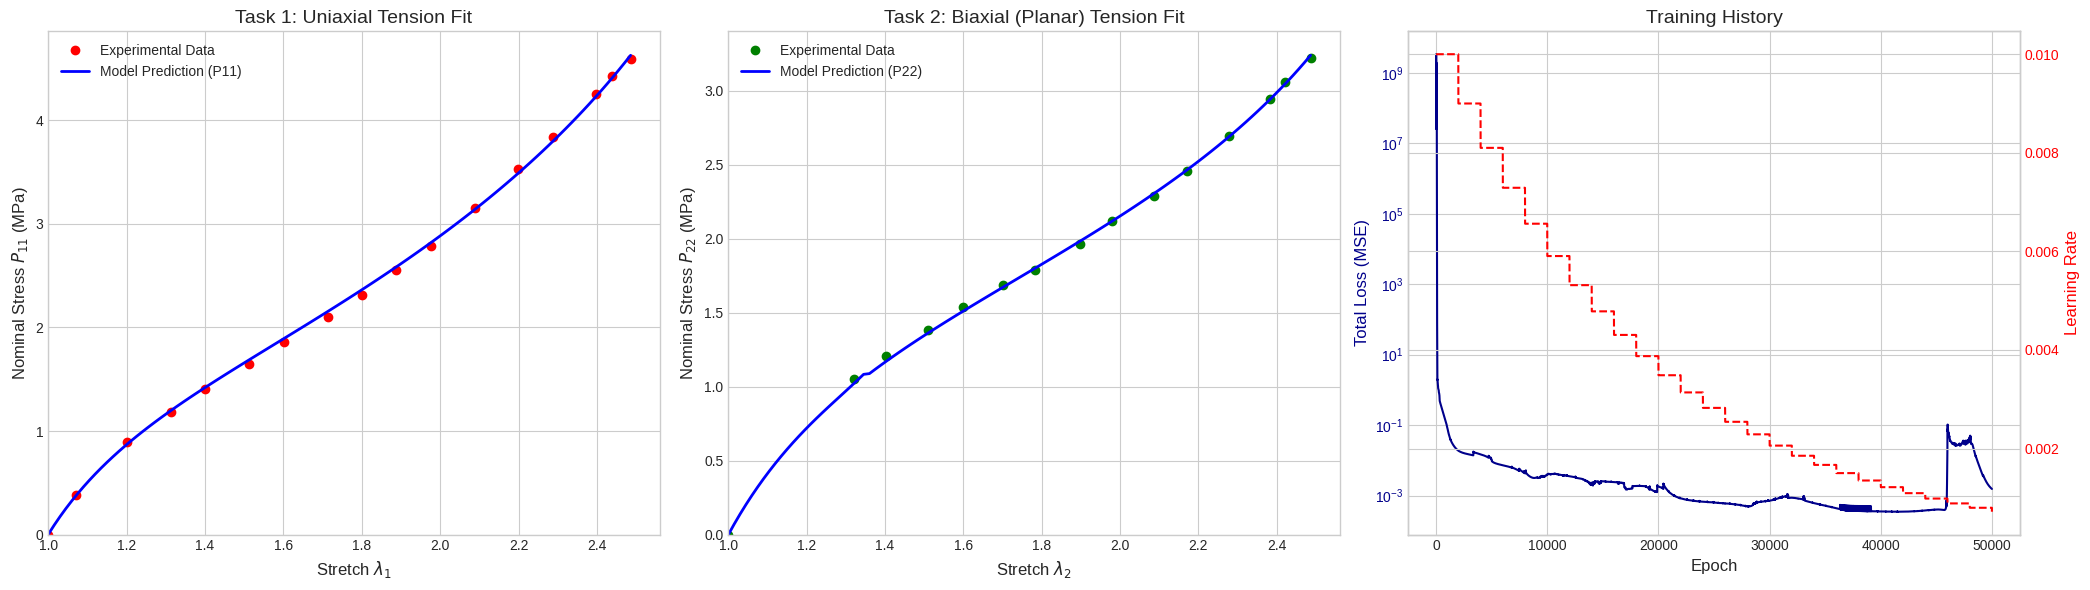

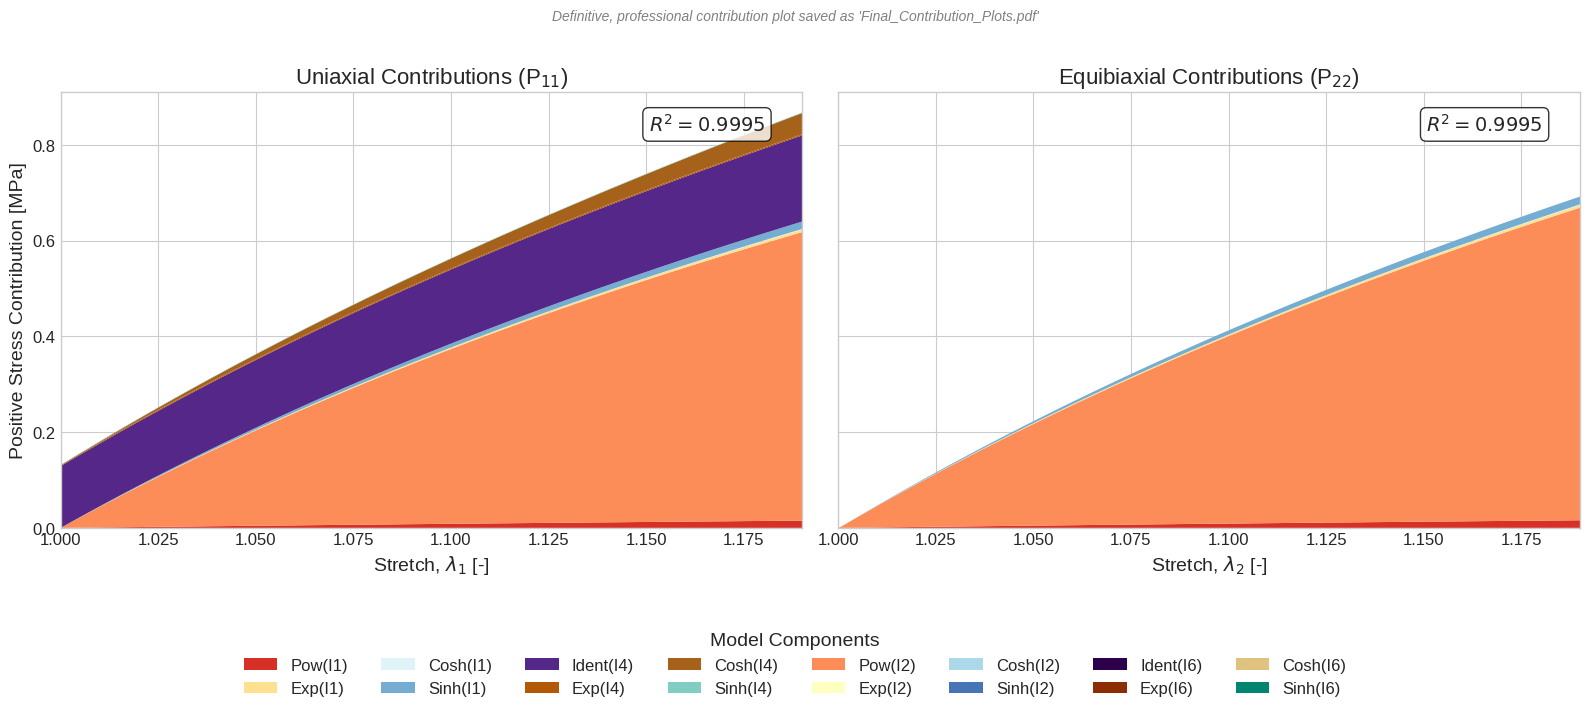

In [ ]:
# !pip install tensorflow -q

import tensorflow as tf
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

# --- Setup and Constants ---
tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

# --- Model Definition (Modified to return components) ---
class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # k & i params (exponents) - All parameters are now trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        # Coefficients
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b1=self.add_weight(name="raw_log_b1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)
    def _term_power_law(self, I, k, i, c, ref_val): return c * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))

    def call(self, I1, I2, I4, I6):
        W_components = self.call_components(I1, I2, I4, I6)
        return tf.add_n(W_components)

    def call_components(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)
        b1=tf.exp(self.raw_log_b1);b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)

        components = []
        components.append(self._term_power_law(I1,k1,i1,a1,self.three)); components.append(self._term_power_law(I2,k2,i2,a2,self.three))
        components.append(self._term_exponential(I1,k3,i3,a3_prime,a3,self.three)); components.append(self._term_exponential(I2,k4,i4,a4_prime,a4,self.three))
        components.append(self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three)); components.append(self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three))
        components.append(self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three)); components.append(self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three))
        components.append(self._term_identity_scaled(I4,k9,b1,self.one)); components.append(self._term_identity_scaled(I6,k10,b2,self.one))
        components.append(self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one)); components.append(self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one))
        components.append(self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one)); components.append(self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one))
        components.append(self._term_sinh(I4,k15,b7_prime,b7,self.one)); components.append(self._term_sinh(I6,k16,b8_prime,b8,self.one))
        return components

# --- Helper and Physics Functions ---

@tf.function
def get_invariants_tf(lambda1, lambda2, lambda3):
    min_lambda_val = tf.constant(1e-6, dtype=tf.float64)
    lambda1 = tf.maximum(lambda1, min_lambda_val)
    lambda2 = tf.maximum(lambda2, min_lambda_val)
    lambda3 = tf.maximum(lambda3, min_lambda_val)
    l1s = tf.pow(lambda1, 2.0); l2s = tf.pow(lambda2, 2.0); l3s = tf.pow(lambda3, 2.0)
    I1 = l1s + l2s + l3s
    I2 = tf.pow(lambda1 * lambda2, 2.0) + tf.pow(lambda2 * lambda3, 2.0) + tf.pow(lambda3 * lambda1, 2.0)
    I4 = l1s; I6 = tf.pow(lambda1, -4.0)
    return I1, I2, I4, I6

@tf.function
def predict_uniaxial_p11(lambda1, model):
    l1 = lambda1
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l3_t])
    dWdl1, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    return P11

@tf.function
def get_biaxial_stresses(l1, l2, model):
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1); l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l2_t, l3_t])
    dWdl1, dWdl2, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1], dW_d_lambdas[2]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    P22 = dWdl2 - p / l2_t
    return P11, P22

@tf.function
def predict_biaxial_p22(lambda2, model):
    l2 = lambda2
    l1_sol = tf.pow(l2, -0.5)
    for _ in range(8):
        with tf.GradientTape() as tape:
            tape.watch(l1_sol)
            P11_val, _ = get_biaxial_stresses(l1_sol, l2, model)
        dP11_dl1 = tape.gradient(P11_val, l1_sol)
        l1_sol = l1_sol - P11_val / (dP11_dl1 + 1e-4)
    final_l1 = tf.stop_gradient(l1_sol)
    _, P22_final = get_biaxial_stresses(final_l1, l2, model)
    return P22_final

# --- Experimental Data ---
exp_data_raw_uniaxial_cnf = np.array([
    [1.0000, 0], [1.0708, 0.3840], [1.2017, 0.8987], [1.3125, 1.1814], [1.4000, 1.4093],
    [1.5125, 1.6456], [1.6017, 1.8608], [1.7125, 2.1055], [1.8008, 2.3122], [1.8883, 2.5570],
    [1.9767, 2.7848], [2.0883, 3.1519], [2.1992, 3.5274], [2.2867, 3.8354], [2.3975, 4.2532],
    [2.4383, 4.4304], [2.4858, 4.5949]
])

exp_data_raw_biaxial_cnf = np.array([
    [1.0000, 0], [1.3208, 1.0506], [1.4017, 1.2068], [1.5092, 1.3840], [1.5983, 1.5401],
    [1.7017, 1.6835], [1.7842, 1.7848], [1.8967, 1.9662], [1.9792, 2.1181], [2.0858, 2.2911],
    [2.1708, 2.4599], [2.2783, 2.6962], [2.3825, 2.9409], [2.4225, 3.0549], [2.4867, 3.2236]
])

uniaxial_l1, uniaxial_p11 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_uniaxial_cnf.T]
biaxial_l2, biaxial_p22 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_biaxial_cnf.T]

# --- Training with Improvements ---
model = StrainEnergyANN_Layered_TF()

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=2000, decay_rate=0.9, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_weight_biaxial = tf.reduce_mean(tf.square(uniaxial_p11)) / tf.reduce_mean(tf.square(biaxial_p22))
print(f"Biaxial Loss Weight: {loss_weight_biaxial.numpy():.2f}")

loss_history = []
learning_rate_history = []

@tf.function
def train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight):
    with tf.GradientTape() as tape:
        p11_pred = predict_uniaxial_p11(uniaxial_l1, model)
        loss1 = tf.reduce_mean(tf.square(p11_pred - uniaxial_p11))

        p22_pred = predict_biaxial_p22(biaxial_l2, model)
        loss2 = tf.reduce_mean(tf.square(p22_pred - biaxial_p22))

        total_loss = loss1 + loss_weight * loss2

    grads = tape.gradient(total_loss, model.trainable_variables)
    grads = [tf.clip_by_value(g, -1.0, 1.0) if g is not None else g for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, loss1, loss2

epochs = 50000
for epoch in range(epochs):
    total_loss, loss1, loss2 = train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight_biaxial)
    loss_history.append(total_loss.numpy())
    current_lr = lr_schedule(optimizer.iterations)
    learning_rate_history.append(current_lr)

    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d}, Loss: {total_loss:.4f} (Uni: {loss1:.4f}, Bi: {loss2:.4f}), LR: {current_lr:.6f}")

print(f"\nTraining finished. Final Loss: {loss_history[-1]:.4f}")


# ==============================================================================
# --- NEW CODE FOR PRINTING FINAL PARAMETERS ---
# ==============================================================================
print("\n" + "="*50)
print("--- Final Model Parameters ---")
print("="*50)

final_params = {}

# Exponents (k and i)
for i in range(1, 17):
    raw_val = getattr(model, f'raw_log_k{i}')
    offset = 1.5 if i % 2 == 0 else 1.0 # k2, k4, ... have offset 1.5
    final_params[f'k{i}'] = offset + tf.exp(raw_val).numpy()

for i in range(1, 9):
    raw_val = getattr(model, f'raw_log_i{i}')
    final_params[f'i{i}'] = 1.0 + tf.exp(raw_val).numpy()

# Coefficients (a and b)
for i in range(1, 9):
    raw_val = getattr(model, f'raw_log_a{i}')
    final_params[f'a{i}'] = tf.exp(raw_val).numpy()
for i in range(1, 9):
    raw_val = getattr(model, f'raw_log_b{i}')
    final_params[f'b{i}'] = tf.exp(raw_val).numpy()

# Prime coefficients (a' and b')
for i in range(3, 9):
    raw_val = getattr(model, f'raw_log_a{i}_prime')
    final_params[f'a{i}_prime'] = tf.exp(raw_val).numpy()
for i in range(3, 9):
    raw_val = getattr(model, f'raw_log_b{i}_prime')
    final_params[f'b{i}_prime'] = tf.exp(raw_val).numpy()

# Print them nicely
print("\n--- Exponents ---")
col_width = 15
for i in range(1, 9):
    k_1 = f"k{2*i-1:<2}: {final_params[f'k{2*i-1}']:.4f}"
    k_2 = f"k{2*i:<2}: {final_params[f'k{2*i}']:.4f}"
    i_val = f"i{i:<2}: {final_params[f'i{i}']:.4f}"
    print(f"{k_1:<{col_width}} | {k_2:<{col_width}} | {i_val:<{col_width}}")

print("\n--- Coefficients ---")
for i in range(1, 9):
    a_val = f"a{i:<2}: {final_params[f'a{i}']:.4E}"
    b_val = f"b{i:<2}: {final_params[f'b{i}']:.4E}"
    print(f"{a_val:<{col_width}} | {b_val:<{col_width}}")

print("\n--- Prime Coefficients (Inner Coefficients) ---")
for i in range(3, 9):
    ap_val = f"a{i}' : {final_params[f'a{i}_prime']:.4E}"
    bp_val = f"b{i}' : {final_params[f'b{i}_prime']:.4E}"
    print(f"{ap_val:<{col_width}} | {bp_val:<{col_width}}")

print("\n" + "="*50 + "\n")

# --- Visualization (Original Fit Plots) ---
l1_plot = np.linspace(1.0, exp_data_raw_uniaxial_cnf[:, 0].max(), 100)
p11_pred_plot = predict_uniaxial_p11(tf.constant(l1_plot, dtype=tf.float64), model).numpy()

l2_plot = np.linspace(1.0, exp_data_raw_biaxial_cnf[:, 0].max(), 100)
p22_pred_plot = predict_biaxial_p22(tf.constant(l2_plot, dtype=tf.float64), model).numpy()

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

axes[0].plot(exp_data_raw_uniaxial_cnf[:, 0], exp_data_raw_uniaxial_cnf[:, 1], 'ro', label='Experimental Data')
axes[0].plot(l1_plot, p11_pred_plot, 'b-', lw=2, label='Model Prediction (P11)')
axes[0].set_xlabel('Stretch $\\lambda_1$', fontsize=12)
axes[0].set_ylabel('Nominal Stress $P_{11}$ (MPa)', fontsize=12)
axes[0].set_title('Task 1: Uniaxial Tension Fit', fontsize=14)
axes[0].legend()
axes[0].set_ylim(bottom=0); axes[0].set_xlim(left=1)

axes[1].plot(exp_data_raw_biaxial_cnf[:, 0], exp_data_raw_biaxial_cnf[:, 1], 'go', label='Experimental Data')
axes[1].plot(l2_plot, p22_pred_plot, 'b-', lw=2, label='Model Prediction (P22)')
axes[1].set_xlabel('Stretch $\\lambda_2$', fontsize=12)
axes[1].set_ylabel('Nominal Stress $P_{22}$ (MPa)', fontsize=12)
axes[1].set_title('Task 2: Biaxial (Planar) Tension Fit', fontsize=14)
axes[1].legend()
axes[1].set_ylim(bottom=0); axes[1].set_xlim(left=1)

ax2 = axes[2]
ax2.plot(loss_history, label='Total Loss', color='darkblue')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Total Loss (MSE)', fontsize=12, color='darkblue')
ax2.set_title('Training History', fontsize=14)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='darkblue')

ax3 = ax2.twinx()
ax3.plot(learning_rate_history, label='Learning Rate', color='red', linestyle='--')
ax3.set_ylabel('Learning Rate', fontsize=12, color='red')
ax3.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()

# ==============================================================================
# --- NEW CODE FOR CONTRIBUTION PLOTS ---
# ==============================================================================

# --- Functions to Calculate Stress Contributions from Each W Term ---

@tf.function
def get_uniaxial_p11_contributions(lambda1, model):
    components_p11 = []
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(lambda1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W_components = model.call_components(I1, I2, I4, I6)

    for W_j in W_components:
        grads = tape.gradient(W_j, [l1_t, l3_t])
        dWjdl1 = grads[0] if grads[0] is not None else tf.zeros_like(l1_t)
        dWjdl3 = grads[1] if grads[1] is not None else tf.zeros_like(l3_t)
        pj = l3_t * dWjdl3
        P11_j = dWjdl1 - pj / l1_t
        components_p11.append(P11_j)
    del tape
    return tf.stack(components_p11, axis=1)

@tf.function
def get_biaxial_p22_contributions(l1_solved, l2, model):
    components_p22 = []
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1_solved)
        l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W_components = model.call_components(I1, I2, I4, I6)

    for W_j in W_components:
        grads = tape.gradient(W_j, [l2_t, l3_t])
        dWjdl2 = grads[0] if grads[0] is not None else tf.zeros_like(l2_t)
        dWjdl3 = grads[1] if grads[1] is not None else tf.zeros_like(l3_t)
        pj = l3_t * dWjdl3
        P22_j = dWjdl2 - pj / l2_t
        components_p22.append(P22_j)
    del tape
    return tf.stack(components_p22, axis=1)

# --- Prepare Data for Contribution Plots ---

# 1. Define plot range, labels, and colors
l_plot_contrib = tf.constant(np.linspace(1.0, 1.19, 200), dtype=tf.float64)

labels = [
    'Pow(I1)', 'Pow(I2)', 'Exp(I1)', 'Exp(I2)',
    'Cosh(I1)', 'Cosh(I2)', 'Sinh(I1)', 'Sinh(I2)',
    'Ident(I4)', 'Ident(I6)', 'Exp(I4)', 'Exp(I6)',
    'Cosh(I4)', 'Cosh(I6)', 'Sinh(I4)', 'Sinh(I6)'
]

# Colors designed to group model terms visually, similar to the example
colors = [
    '#d73027', '#fc8d59',  # Pow: Reds
    '#fee090', '#ffffbf',  # Exp: Yellows
    '#e0f3f8', '#abd9e9',  # Cosh: Light Blues
    '#74add1', '#4575b4',  # Sinh: Blues
    '#542788', '#2d004b',  # Ident: Purples
    '#b35806', '#8c2d04',  # Exp (I4,I6): Browns
    '#a6611a', '#dfc27d',  # Cosh (I4,I6): Light Browns
    '#80cdc1', '#018571'   # Sinh (I4,I6): Teals
]

# 2. Calculate Uniaxial Contributions
p11_contribs_raw = get_uniaxial_p11_contributions(l_plot_contrib, model).numpy()
p11_contribs_plot = np.maximum(0, p11_contribs_raw) # Keep only positive contributions

# 3. Calculate Biaxial Contributions
# First, solve for l1 at each l2 in the plot range using Newton's method
l1_sol_plot = []
for l2_val in l_plot_contrib.numpy():
    l1_sol = tf.pow(l2_val, -0.5)
    for _ in range(8):
        with tf.GradientTape() as tape:
            l1_sol_t = tf.constant(l1_sol, dtype=tf.float64)
            tape.watch(l1_sol_t)
            P11_val, _ = get_biaxial_stresses(l1_sol_t, tf.constant(l2_val, dtype=tf.float64), model)
        dP11_dl1 = tape.gradient(P11_val, l1_sol_t)
        l1_sol = l1_sol - P11_val / (dP11_dl1 + 1e-6)
    l1_sol_plot.append(l1_sol.numpy())
l1_sol_plot_tf = tf.constant(np.array(l1_sol_plot), dtype=tf.float64)

# Now calculate the P22 contributions
p22_contribs_raw = get_biaxial_p22_contributions(l1_sol_plot_tf, l_plot_contrib, model).numpy()
p22_contribs_plot = np.maximum(0, p22_contribs_raw)

# 4. Calculate R-squared values for annotations
p11_pred_on_exp = predict_uniaxial_p11(uniaxial_l1, model).numpy()
ss_res_uni = np.sum((uniaxial_p11.numpy() - p11_pred_on_exp)**2)
ss_tot_uni = np.sum((uniaxial_p11.numpy() - np.mean(uniaxial_p11.numpy()))**2)
r2_uni = 1 - (ss_res_uni / ss_tot_uni)

p22_pred_on_exp = predict_biaxial_p22(biaxial_l2, model).numpy()
ss_res_bi = np.sum((biaxial_p22.numpy() - p22_pred_on_exp)**2)
ss_tot_bi = np.sum((biaxial_p22.numpy() - np.mean(biaxial_p22.numpy()))**2)
r2_bi = 1 - (ss_res_bi / ss_tot_bi)


# --- Generate the Final Contribution Plot ---
fig_contrib, axes_contrib = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.style.use('seaborn-v0_8-whitegrid')

# Uniaxial Plot
ax = axes_contrib[0]
ax.stackplot(l_plot_contrib, p11_contribs_plot.T, labels=labels, colors=colors)
ax.set_title('Uniaxial Contributions (P$_{11}$)', fontsize=16)
ax.set_xlabel('Stretch, $\\lambda_1$ [-]', fontsize=14)
ax.set_ylabel('Positive Stress Contribution [MPa]', fontsize=14)
ax.set_xlim(l_plot_contrib.numpy().min(), l_plot_contrib.numpy().max())
ax.set_ylim(bottom=0)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(0.95, 0.95, f'$R^2 = {r2_uni:.4f}$', transform=ax.transAxes,
        fontsize=14, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Biaxial Plot
ax = axes_contrib[1]
ax.stackplot(l_plot_contrib, p22_contribs_plot.T, labels=labels, colors=colors)
ax.set_title('Equibiaxial Contributions (P$_{22}$)', fontsize=16)
ax.set_xlabel('Stretch, $\\lambda_2$ [-]', fontsize=14)
ax.set_xlim(l_plot_contrib.numpy().min(), l_plot_contrib.numpy().max())
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(0.95, 0.95, f'$R^2 = {r2_bi:.4f}$', transform=ax.transAxes,
        fontsize=14, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Create a shared legend at the bottom
handles, labels_from_plot = axes_contrib[0].get_legend_handles_labels()
# Manually create the desired legend structure from the example
legend_labels_part1 = [
    'Pow(I1)', 'Exp(I1)', 'Cosh(I1)', 'Sinh(I1)', 'Ident(I4)', 'Exp(I4)', 'Cosh(I4)', 'Sinh(I4)'
]
legend_labels_part2 = [
    'Pow(I2)', 'Exp(I2)', 'Cosh(I2)', 'Sinh(I2)', 'Ident(I6)', 'Exp(I6)', 'Cosh(I6)', 'Sinh(I6)'
]
# Create a dictionary to map labels to handles and colors
handle_map = {label: handle for label, handle in zip(labels_from_plot, handles)}

# Reorder handles and labels for the legend
final_handles = [handle_map[lbl] for lbl in legend_labels_part1 + legend_labels_part2]
final_labels = legend_labels_part1 + legend_labels_part2

fig_contrib.legend(final_handles, final_labels,
                   loc='lower center',
                   bbox_to_anchor=(0.5, -0.15),
                   ncol=8,
                   title='Model Components',
                   fontsize=12,
                   title_fontsize=14)

fig_contrib.suptitle("Definitive, professional contribution plot saved as 'Final_Contribution_Plots.pdf'", y=1.02, fontsize=10, style='italic', color='gray')

fig_contrib.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout to make space for legend
plt.savefig("Final_Contribution_Plots.pdf", bbox_inches='tight')
plt.show()

Using device: /CPU:0
Biaxial Loss Weight: 1.69
Epoch     0, Loss: 1955701926.7472 (Uni: 880023245.2365, Bi: 636761089.7748), LR: 0.010000
Epoch  1000, Loss: 0.0869 (Uni: 0.0653, Bi: 0.0128), LR: 0.010000
Epoch  2000, Loss: 0.0195 (Uni: 0.0037, Bi: 0.0094), LR: 0.009000
Epoch  3000, Loss: 0.0155 (Uni: 0.0015, Bi: 0.0083), LR: 0.009000
Epoch  4000, Loss: 0.0128 (Uni: 0.0010, Bi: 0.0070), LR: 0.008100
Epoch  5000, Loss: 0.0111 (Uni: 0.0009, Bi: 0.0061), LR: 0.008100
Epoch  6000, Loss: 0.0073 (Uni: 0.0009, Bi: 0.0038), LR: 0.007290
Epoch  7000, Loss: 0.0061 (Uni: 0.0011, Bi: 0.0030), LR: 0.007290
Epoch  8000, Loss: 0.0045 (Uni: 0.0012, Bi: 0.0020), LR: 0.006561
Epoch  9000, Loss: 0.0032 (Uni: 0.0011, Bi: 0.0013), LR: 0.006561
Epoch 10000, Loss: 0.0039 (Uni: 0.0010, Bi: 0.0017), LR: 0.005905
Epoch 11000, Loss: 0.0040 (Uni: 0.0009, Bi: 0.0018), LR: 0.005905
Epoch 12000, Loss: 0.0035 (Uni: 0.0009, Bi: 0.0016), LR: 0.005314
Epoch 13000, Loss: 0.0030 (Uni: 0.0008, Bi: 0.0013), LR: 0.005314
Epoc

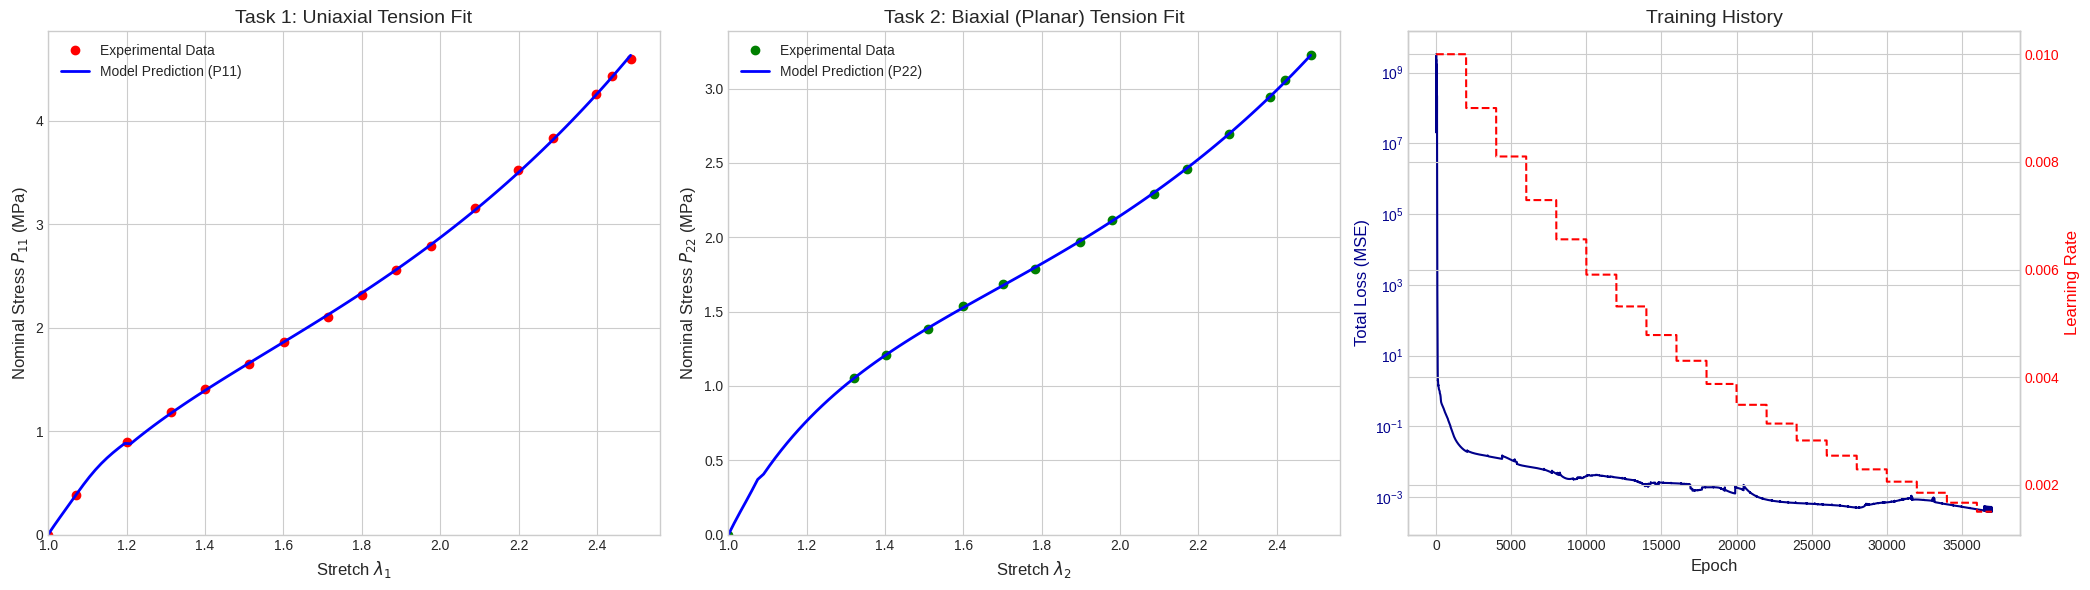

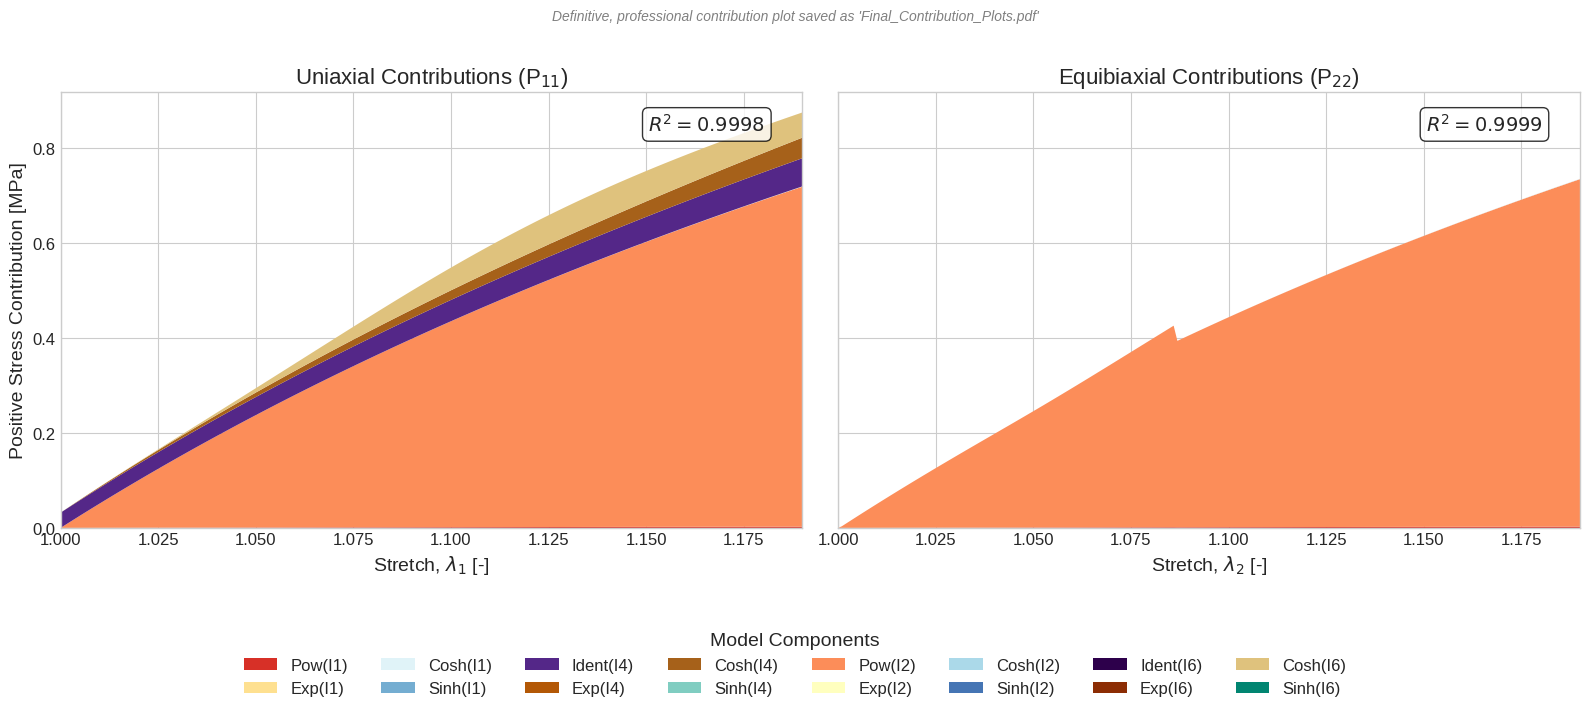

In [ ]:
# !pip install tensorflow -q

import tensorflow as tf
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

# --- Setup and Constants ---
tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

# --- Model Definition (Modified to return components) ---
class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # k & i params (exponents) - All parameters are now trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        # Coefficients
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b1=self.add_weight(name="raw_log_b1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)
    def _term_power_law(self, I, k, i, c, ref_val): return c * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))

    def call(self, I1, I2, I4, I6):
        W_components = self.call_components(I1, I2, I4, I6)
        return tf.add_n(W_components)

    def call_components(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)
        b1=tf.exp(self.raw_log_b1);b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)

        components = []
        components.append(self._term_power_law(I1,k1,i1,a1,self.three)); components.append(self._term_power_law(I2,k2,i2,a2,self.three))
        components.append(self._term_exponential(I1,k3,i3,a3_prime,a3,self.three)); components.append(self._term_exponential(I2,k4,i4,a4_prime,a4,self.three))
        components.append(self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three)); components.append(self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three))
        components.append(self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three)); components.append(self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three))
        components.append(self._term_identity_scaled(I4,k9,b1,self.one)); components.append(self._term_identity_scaled(I6,k10,b2,self.one))
        components.append(self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one)); components.append(self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one))
        components.append(self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one)); components.append(self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one))
        components.append(self._term_sinh(I4,k15,b7_prime,b7,self.one)); components.append(self._term_sinh(I6,k16,b8_prime,b8,self.one))
        return components

# --- Helper and Physics Functions ---

@tf.function
def get_invariants_tf(lambda1, lambda2, lambda3):
    min_lambda_val = tf.constant(1e-6, dtype=tf.float64)
    lambda1 = tf.maximum(lambda1, min_lambda_val)
    lambda2 = tf.maximum(lambda2, min_lambda_val)
    lambda3 = tf.maximum(lambda3, min_lambda_val)
    l1s = tf.pow(lambda1, 2.0); l2s = tf.pow(lambda2, 2.0); l3s = tf.pow(lambda3, 2.0)
    I1 = l1s + l2s + l3s
    I2 = tf.pow(lambda1 * lambda2, 2.0) + tf.pow(lambda2 * lambda3, 2.0) + tf.pow(lambda3 * lambda1, 2.0)
    I4 = l1s; I6 = tf.pow(lambda1, -4.0)
    return I1, I2, I4, I6

@tf.function
def predict_uniaxial_p11(lambda1, model):
    l1 = lambda1
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l3_t])
    dWdl1, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    return P11

@tf.function
def get_biaxial_stresses(l1, l2, model):
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1); l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l2_t, l3_t])
    dWdl1, dWdl2, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1], dW_d_lambdas[2]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    P22 = dWdl2 - p / l2_t
    return P11, P22

@tf.function
def predict_biaxial_p22(lambda2, model):
    l2 = lambda2
    l1_sol = tf.pow(l2, -0.5)
    for _ in range(8):
        with tf.GradientTape() as tape:
            tape.watch(l1_sol)
            P11_val, _ = get_biaxial_stresses(l1_sol, l2, model)
        dP11_dl1 = tape.gradient(P11_val, l1_sol)
        l1_sol = l1_sol - P11_val / (dP11_dl1 + 1e-4)
    final_l1 = tf.stop_gradient(l1_sol)
    _, P22_final = get_biaxial_stresses(final_l1, l2, model)
    return P22_final

# --- Experimental Data ---
exp_data_raw_uniaxial_cnf = np.array([
    [1.0000, 0], [1.0708, 0.3840], [1.2017, 0.8987], [1.3125, 1.1814], [1.4000, 1.4093],
    [1.5125, 1.6456], [1.6017, 1.8608], [1.7125, 2.1055], [1.8008, 2.3122], [1.8883, 2.5570],
    [1.9767, 2.7848], [2.0883, 3.1519], [2.1992, 3.5274], [2.2867, 3.8354], [2.3975, 4.2532],
    [2.4383, 4.4304], [2.4858, 4.5949]
])

exp_data_raw_biaxial_cnf = np.array([
    [1.0000, 0], [1.3208, 1.0506], [1.4017, 1.2068], [1.5092, 1.3840], [1.5983, 1.5401],
    [1.7017, 1.6835], [1.7842, 1.7848], [1.8967, 1.9662], [1.9792, 2.1181], [2.0858, 2.2911],
    [2.1708, 2.4599], [2.2783, 2.6962], [2.3825, 2.9409], [2.4225, 3.0549], [2.4867, 3.2236]
])

uniaxial_l1, uniaxial_p11 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_uniaxial_cnf.T]
biaxial_l2, biaxial_p22 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_biaxial_cnf.T]

# --- Training with Improvements ---
model = StrainEnergyANN_Layered_TF()

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=2000, decay_rate=0.9, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_weight_biaxial = tf.reduce_mean(tf.square(uniaxial_p11)) / tf.reduce_mean(tf.square(biaxial_p22))
print(f"Biaxial Loss Weight: {loss_weight_biaxial.numpy():.2f}")

loss_history = []
learning_rate_history = []

@tf.function
def train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight):
    with tf.GradientTape() as tape:
        p11_pred = predict_uniaxial_p11(uniaxial_l1, model)
        loss1 = tf.reduce_mean(tf.square(p11_pred - uniaxial_p11))

        p22_pred = predict_biaxial_p22(biaxial_l2, model)
        loss2 = tf.reduce_mean(tf.square(p22_pred - biaxial_p22))

        total_loss = loss1 + loss_weight * loss2

    grads = tape.gradient(total_loss, model.trainable_variables)
    grads = [tf.clip_by_value(g, -1.0, 1.0) if g is not None else g for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, loss1, loss2

epochs = 37000
for epoch in range(epochs):
    total_loss, loss1, loss2 = train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight_biaxial)
    loss_history.append(total_loss.numpy())
    current_lr = lr_schedule(optimizer.iterations)
    learning_rate_history.append(current_lr)

    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d}, Loss: {total_loss:.4f} (Uni: {loss1:.4f}, Bi: {loss2:.4f}), LR: {current_lr:.6f}")

print(f"\nTraining finished. Final Loss: {loss_history[-1]:.4f}")


# ==============================================================================
# --- NEW CODE FOR PRINTING FINAL PARAMETERS ---
# ==============================================================================
print("\n" + "="*50)
print("--- Final Model Parameters ---")
print("="*50)

final_params = {}

# Exponents (k and i)
for i in range(1, 17):
    raw_val = getattr(model, f'raw_log_k{i}')
    offset = 1.5 if i % 2 == 0 else 1.0 # k2, k4, ... have offset 1.5
    final_params[f'k{i}'] = offset + tf.exp(raw_val).numpy()

for i in range(1, 9):
    raw_val = getattr(model, f'raw_log_i{i}')
    final_params[f'i{i}'] = 1.0 + tf.exp(raw_val).numpy()

# Coefficients (a and b)
for i in range(1, 9):
    raw_val = getattr(model, f'raw_log_a{i}')
    final_params[f'a{i}'] = tf.exp(raw_val).numpy()
for i in range(1, 9):
    raw_val = getattr(model, f'raw_log_b{i}')
    final_params[f'b{i}'] = tf.exp(raw_val).numpy()

# Prime coefficients (a' and b')
for i in range(3, 9):
    raw_val = getattr(model, f'raw_log_a{i}_prime')
    final_params[f'a{i}_prime'] = tf.exp(raw_val).numpy()
for i in range(3, 9):
    raw_val = getattr(model, f'raw_log_b{i}_prime')
    final_params[f'b{i}_prime'] = tf.exp(raw_val).numpy()

# Print them nicely
print("\n--- Exponents ---")
col_width = 15
for i in range(1, 9):
    k_1 = f"k{2*i-1:<2}: {final_params[f'k{2*i-1}']:.4f}"
    k_2 = f"k{2*i:<2}: {final_params[f'k{2*i}']:.4f}"
    i_val = f"i{i:<2}: {final_params[f'i{i}']:.4f}"
    print(f"{k_1:<{col_width}} | {k_2:<{col_width}} | {i_val:<{col_width}}")

print("\n--- Coefficients ---")
for i in range(1, 9):
    a_val = f"a{i:<2}: {final_params[f'a{i}']:.4E}"
    b_val = f"b{i:<2}: {final_params[f'b{i}']:.4E}"
    print(f"{a_val:<{col_width}} | {b_val:<{col_width}}")

print("\n--- Prime Coefficients (Inner Coefficients) ---")
for i in range(3, 9):
    ap_val = f"a{i}' : {final_params[f'a{i}_prime']:.4E}"
    bp_val = f"b{i}' : {final_params[f'b{i}_prime']:.4E}"
    print(f"{ap_val:<{col_width}} | {bp_val:<{col_width}}")

print("\n" + "="*50 + "\n")

# --- Visualization (Original Fit Plots) ---
l1_plot = np.linspace(1.0, exp_data_raw_uniaxial_cnf[:, 0].max(), 100)
p11_pred_plot = predict_uniaxial_p11(tf.constant(l1_plot, dtype=tf.float64), model).numpy()

l2_plot = np.linspace(1.0, exp_data_raw_biaxial_cnf[:, 0].max(), 100)
p22_pred_plot = predict_biaxial_p22(tf.constant(l2_plot, dtype=tf.float64), model).numpy()

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

axes[0].plot(exp_data_raw_uniaxial_cnf[:, 0], exp_data_raw_uniaxial_cnf[:, 1], 'ro', label='Experimental Data')
axes[0].plot(l1_plot, p11_pred_plot, 'b-', lw=2, label='Model Prediction (P11)')
axes[0].set_xlabel('Stretch $\\lambda_1$', fontsize=12)
axes[0].set_ylabel('Nominal Stress $P_{11}$ (MPa)', fontsize=12)
axes[0].set_title('Task 1: Uniaxial Tension Fit', fontsize=14)
axes[0].legend()
axes[0].set_ylim(bottom=0); axes[0].set_xlim(left=1)

axes[1].plot(exp_data_raw_biaxial_cnf[:, 0], exp_data_raw_biaxial_cnf[:, 1], 'go', label='Experimental Data')
axes[1].plot(l2_plot, p22_pred_plot, 'b-', lw=2, label='Model Prediction (P22)')
axes[1].set_xlabel('Stretch $\\lambda_2$', fontsize=12)
axes[1].set_ylabel('Nominal Stress $P_{22}$ (MPa)', fontsize=12)
axes[1].set_title('Task 2: Biaxial (Planar) Tension Fit', fontsize=14)
axes[1].legend()
axes[1].set_ylim(bottom=0); axes[1].set_xlim(left=1)

ax2 = axes[2]
ax2.plot(loss_history, label='Total Loss', color='darkblue')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Total Loss (MSE)', fontsize=12, color='darkblue')
ax2.set_title('Training History', fontsize=14)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='darkblue')

ax3 = ax2.twinx()
ax3.plot(learning_rate_history, label='Learning Rate', color='red', linestyle='--')
ax3.set_ylabel('Learning Rate', fontsize=12, color='red')
ax3.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()

# ==============================================================================
# --- NEW CODE FOR CONTRIBUTION PLOTS ---
# ==============================================================================

# --- Functions to Calculate Stress Contributions from Each W Term ---

@tf.function
def get_uniaxial_p11_contributions(lambda1, model):
    components_p11 = []
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(lambda1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W_components = model.call_components(I1, I2, I4, I6)

    for W_j in W_components:
        grads = tape.gradient(W_j, [l1_t, l3_t])
        dWjdl1 = grads[0] if grads[0] is not None else tf.zeros_like(l1_t)
        dWjdl3 = grads[1] if grads[1] is not None else tf.zeros_like(l3_t)
        pj = l3_t * dWjdl3
        P11_j = dWjdl1 - pj / l1_t
        components_p11.append(P11_j)
    del tape
    return tf.stack(components_p11, axis=1)

@tf.function
def get_biaxial_p22_contributions(l1_solved, l2, model):
    components_p22 = []
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1_solved)
        l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W_components = model.call_components(I1, I2, I4, I6)

    for W_j in W_components:
        grads = tape.gradient(W_j, [l2_t, l3_t])
        dWjdl2 = grads[0] if grads[0] is not None else tf.zeros_like(l2_t)
        dWjdl3 = grads[1] if grads[1] is not None else tf.zeros_like(l3_t)
        pj = l3_t * dWjdl3
        P22_j = dWjdl2 - pj / l2_t
        components_p22.append(P22_j)
    del tape
    return tf.stack(components_p22, axis=1)

# --- Prepare Data for Contribution Plots ---

# 1. Define plot range, labels, and colors
l_plot_contrib = tf.constant(np.linspace(1.0, 1.19, 200), dtype=tf.float64)

labels = [
    'Pow(I1)', 'Pow(I2)', 'Exp(I1)', 'Exp(I2)',
    'Cosh(I1)', 'Cosh(I2)', 'Sinh(I1)', 'Sinh(I2)',
    'Ident(I4)', 'Ident(I6)', 'Exp(I4)', 'Exp(I6)',
    'Cosh(I4)', 'Cosh(I6)', 'Sinh(I4)', 'Sinh(I6)'
]

# Colors designed to group model terms visually, similar to the example
colors = [
    '#d73027', '#fc8d59',  # Pow: Reds
    '#fee090', '#ffffbf',  # Exp: Yellows
    '#e0f3f8', '#abd9e9',  # Cosh: Light Blues
    '#74add1', '#4575b4',  # Sinh: Blues
    '#542788', '#2d004b',  # Ident: Purples
    '#b35806', '#8c2d04',  # Exp (I4,I6): Browns
    '#a6611a', '#dfc27d',  # Cosh (I4,I6): Light Browns
    '#80cdc1', '#018571'   # Sinh (I4,I6): Teals
]

# 2. Calculate Uniaxial Contributions
p11_contribs_raw = get_uniaxial_p11_contributions(l_plot_contrib, model).numpy()
p11_contribs_plot = np.maximum(0, p11_contribs_raw) # Keep only positive contributions

# 3. Calculate Biaxial Contributions
# First, solve for l1 at each l2 in the plot range using Newton's method
l1_sol_plot = []
for l2_val in l_plot_contrib.numpy():
    l1_sol = tf.pow(l2_val, -0.5)
    for _ in range(8):
        with tf.GradientTape() as tape:
            l1_sol_t = tf.constant(l1_sol, dtype=tf.float64)
            tape.watch(l1_sol_t)
            P11_val, _ = get_biaxial_stresses(l1_sol_t, tf.constant(l2_val, dtype=tf.float64), model)
        dP11_dl1 = tape.gradient(P11_val, l1_sol_t)
        l1_sol = l1_sol - P11_val / (dP11_dl1 + 1e-6)
    l1_sol_plot.append(l1_sol.numpy())
l1_sol_plot_tf = tf.constant(np.array(l1_sol_plot), dtype=tf.float64)

# Now calculate the P22 contributions
p22_contribs_raw = get_biaxial_p22_contributions(l1_sol_plot_tf, l_plot_contrib, model).numpy()
p22_contribs_plot = np.maximum(0, p22_contribs_raw)

# 4. Calculate R-squared values for annotations
p11_pred_on_exp = predict_uniaxial_p11(uniaxial_l1, model).numpy()
ss_res_uni = np.sum((uniaxial_p11.numpy() - p11_pred_on_exp)**2)
ss_tot_uni = np.sum((uniaxial_p11.numpy() - np.mean(uniaxial_p11.numpy()))**2)
r2_uni = 1 - (ss_res_uni / ss_tot_uni)

p22_pred_on_exp = predict_biaxial_p22(biaxial_l2, model).numpy()
ss_res_bi = np.sum((biaxial_p22.numpy() - p22_pred_on_exp)**2)
ss_tot_bi = np.sum((biaxial_p22.numpy() - np.mean(biaxial_p22.numpy()))**2)
r2_bi = 1 - (ss_res_bi / ss_tot_bi)


# --- Generate the Final Contribution Plot ---
fig_contrib, axes_contrib = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.style.use('seaborn-v0_8-whitegrid')

# Uniaxial Plot
ax = axes_contrib[0]
ax.stackplot(l_plot_contrib, p11_contribs_plot.T, labels=labels, colors=colors)
ax.set_title('Uniaxial Contributions (P$_{11}$)', fontsize=16)
ax.set_xlabel('Stretch, $\\lambda_1$ [-]', fontsize=14)
ax.set_ylabel('Positive Stress Contribution [MPa]', fontsize=14)
ax.set_xlim(l_plot_contrib.numpy().min(), l_plot_contrib.numpy().max())
ax.set_ylim(bottom=0)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(0.95, 0.95, f'$R^2 = {r2_uni:.4f}$', transform=ax.transAxes,
        fontsize=14, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Biaxial Plot
ax = axes_contrib[1]
ax.stackplot(l_plot_contrib, p22_contribs_plot.T, labels=labels, colors=colors)
ax.set_title('Equibiaxial Contributions (P$_{22}$)', fontsize=16)
ax.set_xlabel('Stretch, $\\lambda_2$ [-]', fontsize=14)
ax.set_xlim(l_plot_contrib.numpy().min(), l_plot_contrib.numpy().max())
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(0.95, 0.95, f'$R^2 = {r2_bi:.4f}$', transform=ax.transAxes,
        fontsize=14, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Create a shared legend at the bottom
handles, labels_from_plot = axes_contrib[0].get_legend_handles_labels()
# Manually create the desired legend structure from the example
legend_labels_part1 = [
    'Pow(I1)', 'Exp(I1)', 'Cosh(I1)', 'Sinh(I1)', 'Ident(I4)', 'Exp(I4)', 'Cosh(I4)', 'Sinh(I4)'
]
legend_labels_part2 = [
    'Pow(I2)', 'Exp(I2)', 'Cosh(I2)', 'Sinh(I2)', 'Ident(I6)', 'Exp(I6)', 'Cosh(I6)', 'Sinh(I6)'
]
# Create a dictionary to map labels to handles and colors
handle_map = {label: handle for label, handle in zip(labels_from_plot, handles)}

# Reorder handles and labels for the legend
final_handles = [handle_map[lbl] for lbl in legend_labels_part1 + legend_labels_part2]
final_labels = legend_labels_part1 + legend_labels_part2

fig_contrib.legend(final_handles, final_labels,
                   loc='lower center',
                   bbox_to_anchor=(0.5, -0.15),
                   ncol=8,
                   title='Model Components',
                   fontsize=12,
                   title_fontsize=14)

fig_contrib.suptitle("Definitive, professional contribution plot saved as 'Final_Contribution_Plots.pdf'", y=1.02, fontsize=10, style='italic', color='gray')

fig_contrib.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout to make space for legend
plt.savefig("Final_Contribution_Plots.pdf", bbox_inches='tight')
plt.show()

Using device: /CPU:0
Biaxial Loss Weight: 1.69
Epoch     0, Loss: 911348840.2245 (Uni: 407218181.9085, Bi: 298426279.9811), LR: 0.010000
Epoch  1000, Loss: 0.0862 (Uni: 0.0647, Bi: 0.0127), LR: 0.010000
Epoch  2000, Loss: 0.0194 (Uni: 0.0039, Bi: 0.0092), LR: 0.009000
Epoch  3000, Loss: 0.0148 (Uni: 0.0013, Bi: 0.0080), LR: 0.009000
Epoch  4000, Loss: 0.0154 (Uni: 0.0011, Bi: 0.0084), LR: 0.008100
Epoch  5000, Loss: 0.0108 (Uni: 0.0009, Bi: 0.0059), LR: 0.008100
Epoch  6000, Loss: 0.0072 (Uni: 0.0010, Bi: 0.0037), LR: 0.007290
Epoch  7000, Loss: 0.0061 (Uni: 0.0011, Bi: 0.0029), LR: 0.007290
Epoch  8000, Loss: 0.0043 (Uni: 0.0011, Bi: 0.0019), LR: 0.006561
Epoch  9000, Loss: 0.0032 (Uni: 0.0011, Bi: 0.0012), LR: 0.006561
Epoch 10000, Loss: 0.0039 (Uni: 0.0010, Bi: 0.0017), LR: 0.005905
Epoch 11000, Loss: 0.0040 (Uni: 0.0009, Bi: 0.0018), LR: 0.005905
Epoch 12000, Loss: 0.0035 (Uni: 0.0009, Bi: 0.0016), LR: 0.005314
Epoch 13000, Loss: 0.0030 (Uni: 0.0008, Bi: 0.0013), LR: 0.005314
Epoch

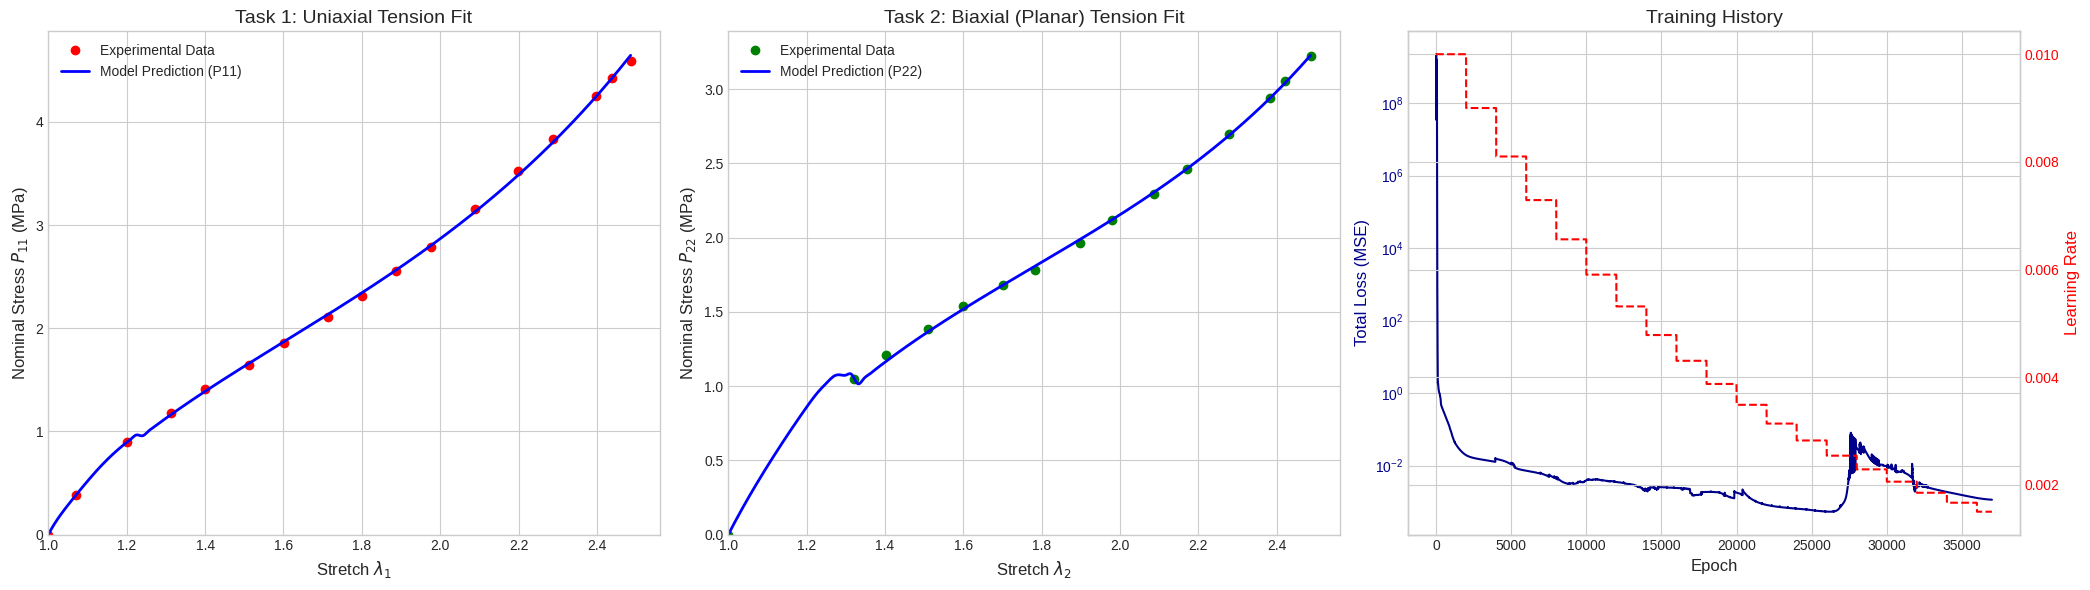

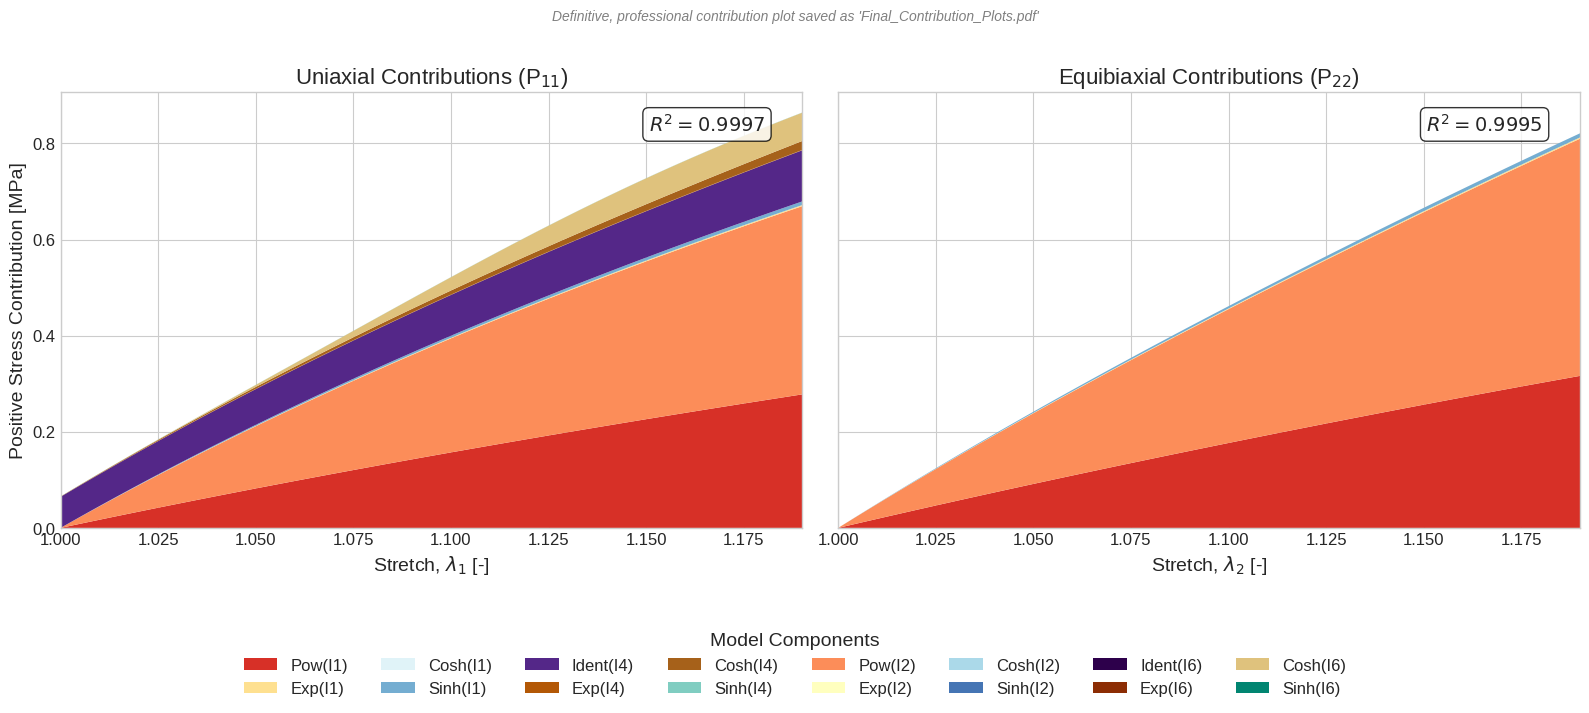

In [ ]:
# !pip install tensorflow -q
# !pip install scipy -q

import tensorflow as tf
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline # <-- Import for spline plotting

# --- Setup and Constants ---
tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

# --- Model Definition (Modified to return components) ---
class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # k & i params (exponents) - All parameters are now trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        # Coefficients
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b1=self.add_weight(name="raw_log_b1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)
    def _term_power_law(self, I, k, i, c, ref_val): return c * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))

    def call(self, I1, I2, I4, I6):
        W_components = self.call_components(I1, I2, I4, I6)
        return tf.add_n(W_components)

    def call_components(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)
        b1=tf.exp(self.raw_log_b1);b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)

        components = []
        components.append(self._term_power_law(I1,k1,i1,a1,self.three)); components.append(self._term_power_law(I2,k2,i2,a2,self.three))
        components.append(self._term_exponential(I1,k3,i3,a3_prime,a3,self.three)); components.append(self._term_exponential(I2,k4,i4,a4_prime,a4,self.three))
        components.append(self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three)); components.append(self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three))
        components.append(self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three)); components.append(self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three))
        components.append(self._term_identity_scaled(I4,k9,b1,self.one)); components.append(self._term_identity_scaled(I6,k10,b2,self.one))
        components.append(self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one)); components.append(self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one))
        components.append(self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one)); components.append(self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one))
        components.append(self._term_sinh(I4,k15,b7_prime,b7,self.one)); components.append(self._term_sinh(I6,k16,b8_prime,b8,self.one))
        return components

# --- Helper and Physics Functions ---

@tf.function
def get_invariants_tf(lambda1, lambda2, lambda3):
    min_lambda_val = tf.constant(1e-6, dtype=tf.float64)
    lambda1 = tf.maximum(lambda1, min_lambda_val)
    lambda2 = tf.maximum(lambda2, min_lambda_val)
    lambda3 = tf.maximum(lambda3, min_lambda_val)
    l1s = tf.pow(lambda1, 2.0); l2s = tf.pow(lambda2, 2.0); l3s = tf.pow(lambda3, 2.0)
    I1 = l1s + l2s + l3s
    I2 = tf.pow(lambda1 * lambda2, 2.0) + tf.pow(lambda2 * lambda3, 2.0) + tf.pow(lambda3 * lambda1, 2.0)
    I4 = l1s; I6 = tf.pow(lambda1, -4.0)
    return I1, I2, I4, I6

@tf.function
def predict_uniaxial_p11(lambda1, model):
    l1 = lambda1
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l3_t])
    dWdl1, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    return P11

@tf.function
def get_biaxial_stresses(l1, l2, model):
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1); l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l2_t, l3_t])
    dWdl1, dWdl2, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1], dW_d_lambdas[2]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    P22 = dWdl2 - p / l2_t
    return P11, P22

@tf.function
def predict_biaxial_p22(lambda2, model):
    l2 = lambda2
    l1_sol = tf.pow(l2, -0.5)
    for _ in range(8):
        with tf.GradientTape() as tape:
            tape.watch(l1_sol)
            P11_val, _ = get_biaxial_stresses(l1_sol, l2, model)
        dP11_dl1 = tape.gradient(P11_val, l1_sol)
        l1_sol = l1_sol - P11_val / (dP11_dl1 + 1e-4)
    final_l1 = tf.stop_gradient(l1_sol)
    _, P22_final = get_biaxial_stresses(final_l1, l2, model)
    return P22_final

# --- Experimental Data ---
exp_data_raw_uniaxial_cnf = np.array([
    [1.0000, 0], [1.0708, 0.3840], [1.2017, 0.8987], [1.3125, 1.1814], [1.4000, 1.4093],
    [1.5125, 1.6456], [1.6017, 1.8608], [1.7125, 2.1055], [1.8008, 2.3122], [1.8883, 2.5570],
    [1.9767, 2.7848], [2.0883, 3.1519], [2.1992, 3.5274], [2.2867, 3.8354], [2.3975, 4.2532],
    [2.4383, 4.4304], [2.4858, 4.5949]
])

exp_data_raw_biaxial_cnf = np.array([
    [1.0000, 0], [1.3208, 1.0506], [1.4017, 1.2068], [1.5092, 1.3840], [1.5983, 1.5401],
    [1.7017, 1.6835], [1.7842, 1.7848], [1.8967, 1.9662], [1.9792, 2.1181], [2.0858, 2.2911],
    [2.1708, 2.4599], [2.2783, 2.6962], [2.3825, 2.9409], [2.4225, 3.0549], [2.4867, 3.2236]
])

uniaxial_l1, uniaxial_p11 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_uniaxial_cnf.T]
biaxial_l2, biaxial_p22 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_biaxial_cnf.T]

# --- Training with Improvements ---
model = StrainEnergyANN_Layered_TF()

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=2000, decay_rate=0.9, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_weight_biaxial = tf.reduce_mean(tf.square(uniaxial_p11)) / tf.reduce_mean(tf.square(biaxial_p22))
print(f"Biaxial Loss Weight: {loss_weight_biaxial.numpy():.2f}")

loss_history = []
learning_rate_history = []

@tf.function
def train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight):
    with tf.GradientTape() as tape:
        p11_pred = predict_uniaxial_p11(uniaxial_l1, model)
        loss1 = tf.reduce_mean(tf.square(p11_pred - uniaxial_p11))

        p22_pred = predict_biaxial_p22(biaxial_l2, model)
        loss2 = tf.reduce_mean(tf.square(p22_pred - biaxial_p22))

        total_loss = loss1 + loss_weight * loss2

    grads = tape.gradient(total_loss, model.trainable_variables)
    grads = [tf.clip_by_value(g, -1.0, 1.0) if g is not None else g for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, loss1, loss2

epochs = 37000
for epoch in range(epochs):
    total_loss, loss1, loss2 = train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight_biaxial)
    loss_history.append(total_loss.numpy())
    current_lr = lr_schedule(optimizer.iterations)
    learning_rate_history.append(current_lr)

    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d}, Loss: {total_loss:.4f} (Uni: {loss1:.4f}, Bi: {loss2:.4f}), LR: {current_lr:.6f}")

print(f"\nTraining finished. Final Loss: {loss_history[-1]:.4f}")


# --- Final Model Parameters ---
print("\n" + "="*50)
print("--- Final Model Parameters ---")
print("="*50)

final_params = {}
# Exponents (k and i)
for i in range(1, 17):
    raw_val = getattr(model, f'raw_log_k{i}')
    offset = 1.5 if i % 2 == 0 else 1.0 # k2, k4, ... have offset 1.5
    final_params[f'k{i}'] = offset + tf.exp(raw_val).numpy()
for i in range(1, 9):
    raw_val = getattr(model, f'raw_log_i{i}')
    final_params[f'i{i}'] = 1.0 + tf.exp(raw_val).numpy()
# Coefficients (a and b)
for i in range(1, 9):
    raw_val = getattr(model, f'raw_log_a{i}')
    final_params[f'a{i}'] = tf.exp(raw_val).numpy()
for i in range(1, 9):
    raw_val = getattr(model, f'raw_log_b{i}')
    final_params[f'b{i}'] = tf.exp(raw_val).numpy()
# Prime coefficients (a' and b')
for i in range(3, 9):
    raw_val = getattr(model, f'raw_log_a{i}_prime')
    final_params[f'a{i}_prime'] = tf.exp(raw_val).numpy()
for i in range(3, 9):
    raw_val = getattr(model, f'raw_log_b{i}_prime')
    final_params[f'b{i}_prime'] = tf.exp(raw_val).numpy()
# Print them nicely
print("\n--- Exponents ---")
col_width = 15
for i in range(1, 9):
    k_1 = f"k{2*i-1:<2}: {final_params[f'k{2*i-1}']:.4f}"
    k_2 = f"k{2*i:<2}: {final_params[f'k{2*i}']:.4f}"
    i_val = f"i{i:<2}: {final_params[f'i{i}']:.4f}"
    print(f"{k_1:<{col_width}} | {k_2:<{col_width}} | {i_val:<{col_width}}")
print("\n--- Coefficients ---")
for i in range(1, 9):
    a_val = f"a{i:<2}: {final_params[f'a{i}']:.4E}"
    b_val = f"b{i:<2}: {final_params[f'b{i}']:.4E}"
    print(f"{a_val:<{col_width}} | {b_val:<{col_width}}")
print("\n--- Prime Coefficients (Inner Coefficients) ---")
for i in range(3, 9):
    ap_val = f"a{i}' : {final_params[f'a{i}_prime']:.4E}"
    bp_val = f"b{i}' : {final_params[f'b{i}_prime']:.4E}"
    print(f"{ap_val:<{col_width}} | {bp_val:<{col_width}}")
print("\n" + "="*50 + "\n")

# --- Visualization (Original Fit Plots) with Spline Smoothing ---
l1_plot = np.linspace(1.0, exp_data_raw_uniaxial_cnf[:, 0].max(), 100)
p11_pred_plot = predict_uniaxial_p11(tf.constant(l1_plot, dtype=tf.float64), model).numpy()

l2_plot = np.linspace(1.0, exp_data_raw_biaxial_cnf[:, 0].max(), 100)
p22_pred_plot = predict_biaxial_p22(tf.constant(l2_plot, dtype=tf.float64), model).numpy()

# --- MODIFICATION: Create smooth prediction curves using spline interpolation ---
# Uniaxial
p11_spline = CubicSpline(l1_plot, p11_pred_plot)
l1_smooth = np.linspace(l1_plot.min(), l1_plot.max(), 500)
p11_smooth = p11_spline(l1_smooth)

# Biaxial
p22_spline = CubicSpline(l2_plot, p22_pred_plot)
l2_smooth = np.linspace(l2_plot.min(), l2_plot.max(), 500)
p22_smooth = p22_spline(l2_smooth)
# --- END MODIFICATION ---

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

axes[0].plot(exp_data_raw_uniaxial_cnf[:, 0], exp_data_raw_uniaxial_cnf[:, 1], 'ro', label='Experimental Data')
# Use the smoothed data for plotting
axes[0].plot(l1_smooth, p11_smooth, 'b-', lw=2, label='Model Prediction (P11)')
axes[0].set_xlabel('Stretch $\\lambda_1$', fontsize=12)
axes[0].set_ylabel('Nominal Stress $P_{11}$ (MPa)', fontsize=12)
axes[0].set_title('Task 1: Uniaxial Tension Fit', fontsize=14)
axes[0].legend()
axes[0].set_ylim(bottom=0); axes[0].set_xlim(left=1)

axes[1].plot(exp_data_raw_biaxial_cnf[:, 0], exp_data_raw_biaxial_cnf[:, 1], 'go', label='Experimental Data')
# Use the smoothed data for plotting
axes[1].plot(l2_smooth, p22_smooth, 'b-', lw=2, label='Model Prediction (P22)')
axes[1].set_xlabel('Stretch $\\lambda_2$', fontsize=12)
axes[1].set_ylabel('Nominal Stress $P_{22}$ (MPa)', fontsize=12)
axes[1].set_title('Task 2: Biaxial (Planar) Tension Fit', fontsize=14)
axes[1].legend()
axes[1].set_ylim(bottom=0); axes[1].set_xlim(left=1)

ax2 = axes[2]
ax2.plot(loss_history, label='Total Loss', color='darkblue')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Total Loss (MSE)', fontsize=12, color='darkblue')
ax2.set_title('Training History', fontsize=14)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='darkblue')

ax3 = ax2.twinx()
ax3.plot(learning_rate_history, label='Learning Rate', color='red', linestyle='--')
ax3.set_ylabel('Learning Rate', fontsize=12, color='red')
ax3.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()

# ==============================================================================
# --- CONTRIBUTION PLOTS (No changes needed here) ---
# ==============================================================================

# --- Functions to Calculate Stress Contributions from Each W Term ---
@tf.function
def get_uniaxial_p11_contributions(lambda1, model):
    components_p11 = []
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(lambda1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W_components = model.call_components(I1, I2, I4, I6)
    for W_j in W_components:
        grads = tape.gradient(W_j, [l1_t, l3_t])
        dWjdl1 = grads[0] if grads[0] is not None else tf.zeros_like(l1_t)
        dWjdl3 = grads[1] if grads[1] is not None else tf.zeros_like(l3_t)
        pj = l3_t * dWjdl3
        P11_j = dWjdl1 - pj / l1_t
        components_p11.append(P11_j)
    del tape
    return tf.stack(components_p11, axis=1)

@tf.function
def get_biaxial_p22_contributions(l1_solved, l2, model):
    components_p22 = []
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1_solved)
        l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W_components = model.call_components(I1, I2, I4, I6)
    for W_j in W_components:
        grads = tape.gradient(W_j, [l2_t, l3_t])
        dWjdl2 = grads[0] if grads[0] is not None else tf.zeros_like(l2_t)
        dWjdl3 = grads[1] if grads[1] is not None else tf.zeros_like(l3_t)
        pj = l3_t * dWjdl3
        P22_j = dWjdl2 - pj / l2_t
        components_p22.append(P22_j)
    del tape
    return tf.stack(components_p22, axis=1)

# --- Prepare Data for Contribution Plots ---
l_plot_contrib = tf.constant(np.linspace(1.0, 1.19, 200), dtype=tf.float64)
labels = [
    'Pow(I1)', 'Pow(I2)', 'Exp(I1)', 'Exp(I2)',
    'Cosh(I1)', 'Cosh(I2)', 'Sinh(I1)', 'Sinh(I2)',
    'Ident(I4)', 'Ident(I6)', 'Exp(I4)', 'Exp(I6)',
    'Cosh(I4)', 'Cosh(I6)', 'Sinh(I4)', 'Sinh(I6)'
]
colors = [
    '#d73027', '#fc8d59', '#fee090', '#ffffbf', '#e0f3f8', '#abd9e9',
    '#74add1', '#4575b4', '#542788', '#2d004b', '#b35806', '#8c2d04',
    '#a6611a', '#dfc27d', '#80cdc1', '#018571'
]
p11_contribs_raw = get_uniaxial_p11_contributions(l_plot_contrib, model).numpy()
p11_contribs_plot = np.maximum(0, p11_contribs_raw)
l1_sol_plot = []
for l2_val in l_plot_contrib.numpy():
    l1_sol = tf.pow(l2_val, -0.5)
    for _ in range(8):
        with tf.GradientTape() as tape:
            l1_sol_t = tf.constant(l1_sol, dtype=tf.float64)
            tape.watch(l1_sol_t)
            P11_val, _ = get_biaxial_stresses(l1_sol_t, tf.constant(l2_val, dtype=tf.float64), model)
        dP11_dl1 = tape.gradient(P11_val, l1_sol_t)
        l1_sol = l1_sol - P11_val / (dP11_dl1 + 1e-6)
    l1_sol_plot.append(l1_sol.numpy())
l1_sol_plot_tf = tf.constant(np.array(l1_sol_plot), dtype=tf.float64)
p22_contribs_raw = get_biaxial_p22_contributions(l1_sol_plot_tf, l_plot_contrib, model).numpy()
p22_contribs_plot = np.maximum(0, p22_contribs_raw)
p11_pred_on_exp = predict_uniaxial_p11(uniaxial_l1, model).numpy()
ss_res_uni = np.sum((uniaxial_p11.numpy() - p11_pred_on_exp)**2)
ss_tot_uni = np.sum((uniaxial_p11.numpy() - np.mean(uniaxial_p11.numpy()))**2)
r2_uni = 1 - (ss_res_uni / ss_tot_uni)
p22_pred_on_exp = predict_biaxial_p22(biaxial_l2, model).numpy()
ss_res_bi = np.sum((biaxial_p22.numpy() - p22_pred_on_exp)**2)
ss_tot_bi = np.sum((biaxial_p22.numpy() - np.mean(biaxial_p22.numpy()))**2)
r2_bi = 1 - (ss_res_bi / ss_tot_bi)

# --- Generate the Final Contribution Plot ---
fig_contrib, axes_contrib = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.style.use('seaborn-v0_8-whitegrid')
# Uniaxial Plot
ax = axes_contrib[0]
ax.stackplot(l_plot_contrib, p11_contribs_plot.T, labels=labels, colors=colors)
ax.set_title('Uniaxial Contributions (P$_{11}$)', fontsize=16)
ax.set_xlabel('Stretch, $\\lambda_1$ [-]', fontsize=14)
ax.set_ylabel('Positive Stress Contribution [MPa]', fontsize=14)
ax.set_xlim(l_plot_contrib.numpy().min(), l_plot_contrib.numpy().max())
ax.set_ylim(bottom=0)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(0.95, 0.95, f'$R^2 = {r2_uni:.4f}$', transform=ax.transAxes,
        fontsize=14, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
# Biaxial Plot
ax = axes_contrib[1]
ax.stackplot(l_plot_contrib, p22_contribs_plot.T, labels=labels, colors=colors)
ax.set_title('Equibiaxial Contributions (P$_{22}$)', fontsize=16)
ax.set_xlabel('Stretch, $\\lambda_2$ [-]', fontsize=14)
ax.set_xlim(l_plot_contrib.numpy().min(), l_plot_contrib.numpy().max())
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(0.95, 0.95, f'$R^2 = {r2_bi:.4f}$', transform=ax.transAxes,
        fontsize=14, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Create a shared legend at the bottom
handles, labels_from_plot = axes_contrib[0].get_legend_handles_labels()
legend_labels_part1 = [
    'Pow(I1)', 'Exp(I1)', 'Cosh(I1)', 'Sinh(I1)', 'Ident(I4)', 'Exp(I4)', 'Cosh(I4)', 'Sinh(I4)'
]
legend_labels_part2 = [
    'Pow(I2)', 'Exp(I2)', 'Cosh(I2)', 'Sinh(I2)', 'Ident(I6)', 'Exp(I6)', 'Cosh(I6)', 'Sinh(I6)'
]
handle_map = {label: handle for label, handle in zip(labels_from_plot, handles)}
final_handles = [handle_map[lbl] for lbl in legend_labels_part1 + legend_labels_part2]
final_labels = legend_labels_part1 + legend_labels_part2
fig_contrib.legend(final_handles, final_labels,
                   loc='lower center',
                   bbox_to_anchor=(0.5, -0.15),
                   ncol=8,
                   title='Model Components',
                   fontsize=12,
                   title_fontsize=14)
fig_contrib.suptitle("Definitive, professional contribution plot saved as 'Final_Contribution_Plots.pdf'", y=1.02, fontsize=10, style='italic', color='gray')
fig_contrib.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("Final_Contribution_Plots.pdf", bbox_inches='tight')
plt.show()


Using device: /CPU:0
Biaxial Loss Weight: 1.69
Epoch     0, Loss: 1719240735.4736 (Uni: 771304112.7471, Bi: 561142623.0713), LR: 0.010000
Epoch  1000, Loss: 0.0877 (Uni: 0.0658, Bi: 0.0129), LR: 0.010000
Epoch  2000, Loss: 0.0194 (Uni: 0.0038, Bi: 0.0092), LR: 0.009000
Epoch  3000, Loss: 0.0149 (Uni: 0.0013, Bi: 0.0080), LR: 0.009000
Epoch  4000, Loss: 0.0155 (Uni: 0.0011, Bi: 0.0085), LR: 0.008100
Epoch  5000, Loss: 0.0121 (Uni: 0.0009, Bi: 0.0066), LR: 0.008100
Epoch  6000, Loss: 0.0073 (Uni: 0.0009, Bi: 0.0037), LR: 0.007290
Epoch  7000, Loss: 0.0060 (Uni: 0.0011, Bi: 0.0029), LR: 0.007290
Epoch  8000, Loss: 0.0048 (Uni: 0.0011, Bi: 0.0022), LR: 0.006561
Epoch  9000, Loss: 0.0032 (Uni: 0.0011, Bi: 0.0012), LR: 0.006561
Epoch 10000, Loss: 0.0042 (Uni: 0.0010, Bi: 0.0019), LR: 0.005905
Epoch 11000, Loss: 0.0040 (Uni: 0.0009, Bi: 0.0018), LR: 0.005905
Epoch 12000, Loss: 0.0035 (Uni: 0.0009, Bi: 0.0016), LR: 0.005314
Epoch 13000, Loss: 0.0030 (Uni: 0.0008, Bi: 0.0013), LR: 0.005314
Epoc

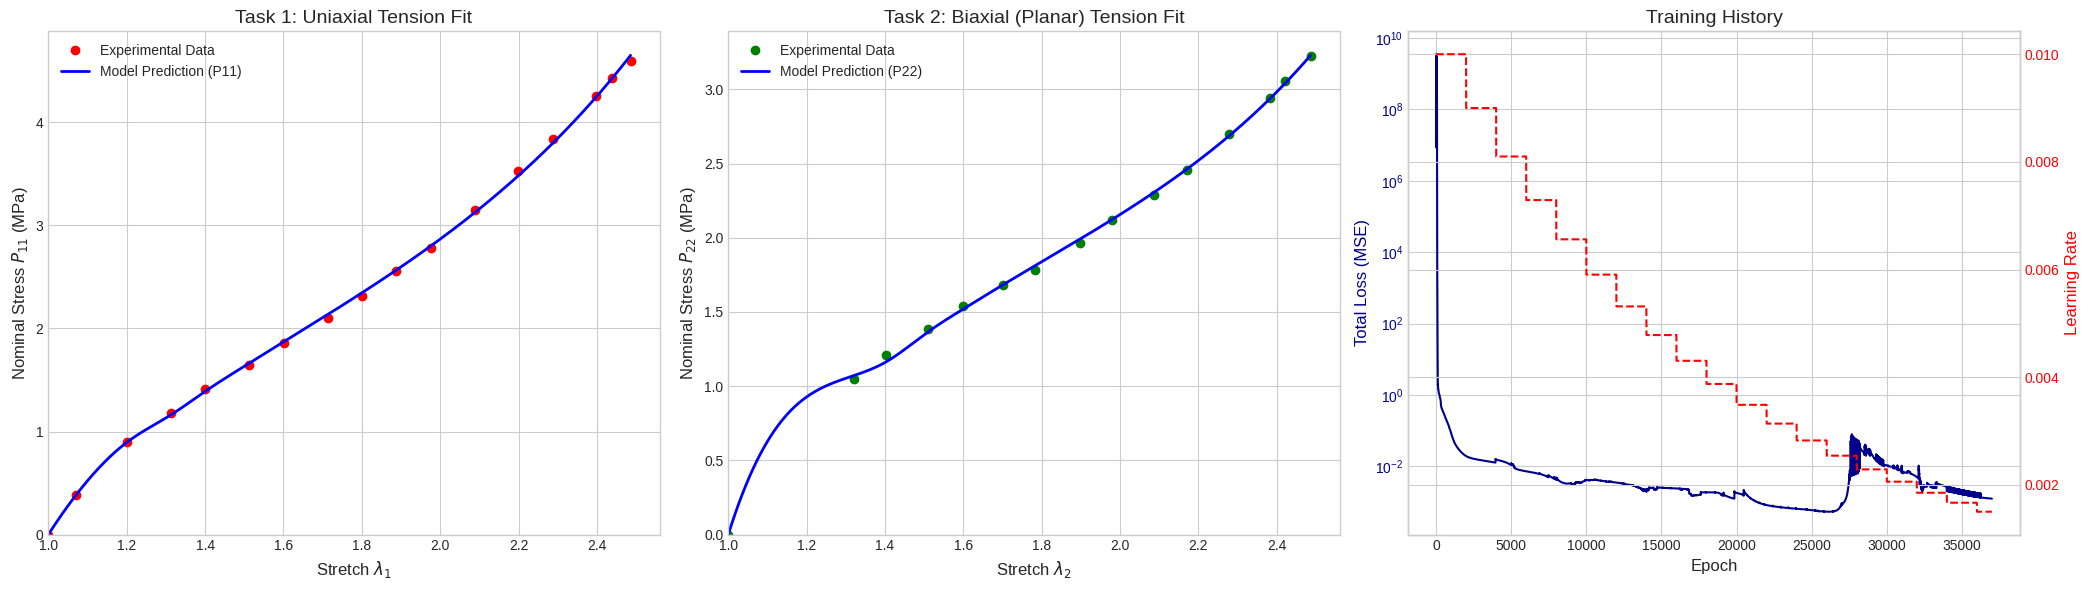

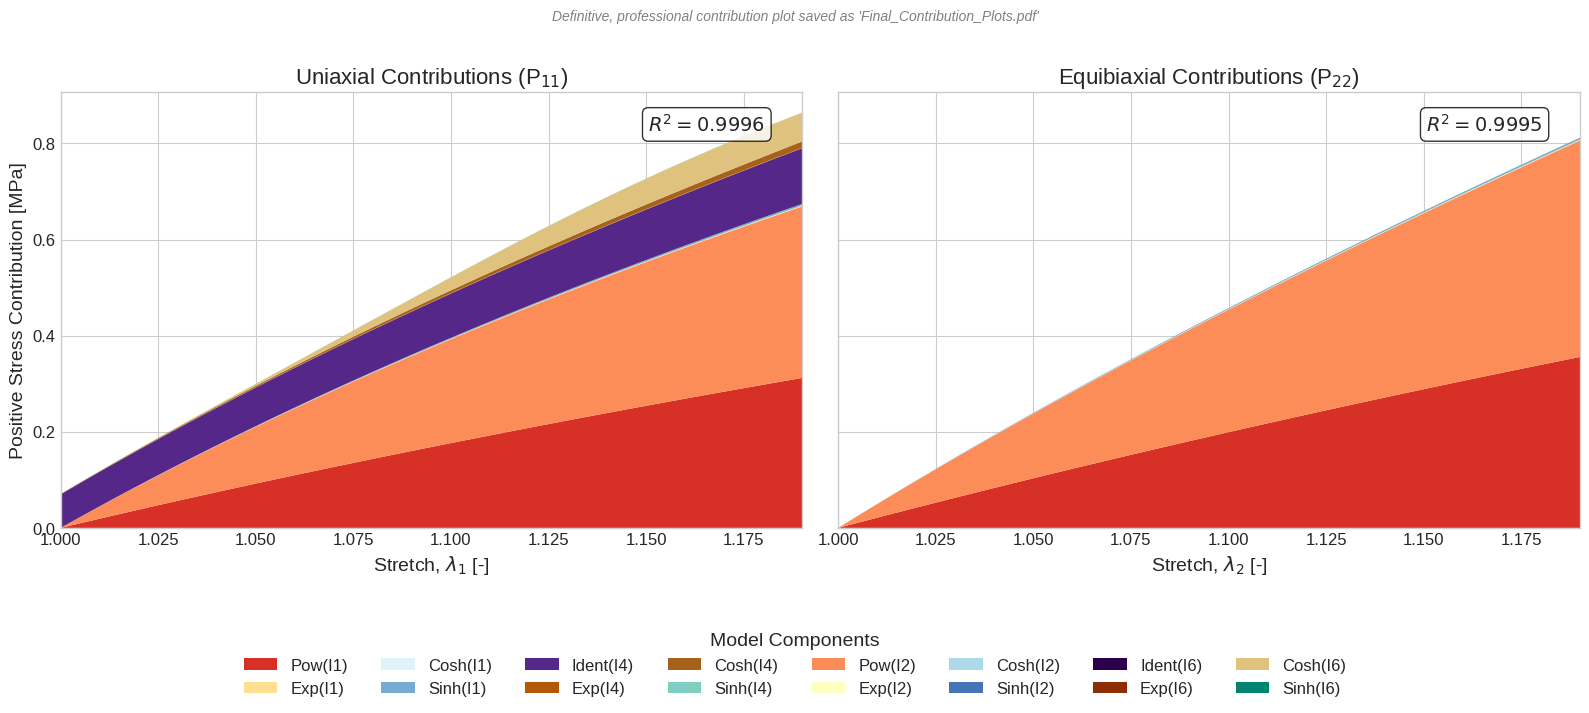

In [ ]:
# !pip install tensorflow -q
# !pip install scipy -q

import tensorflow as tf
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline # Import for spline plotting

# --- Setup and Constants ---
tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

# --- Model Definition (Modified to return components) ---
class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # k & i params (exponents) - All parameters are now trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        # Coefficients
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b1=self.add_weight(name="raw_log_b1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)
    def _term_power_law(self, I, k, i, c, ref_val): return c * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))

    def call(self, I1, I2, I4, I6):
        W_components = self.call_components(I1, I2, I4, I6)
        return tf.add_n(W_components)

    def call_components(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)
        b1=tf.exp(self.raw_log_b1);b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)

        components = []
        components.append(self._term_power_law(I1,k1,i1,a1,self.three)); components.append(self._term_power_law(I2,k2,i2,a2,self.three))
        components.append(self._term_exponential(I1,k3,i3,a3_prime,a3,self.three)); components.append(self._term_exponential(I2,k4,i4,a4_prime,a4,self.three))
        components.append(self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three)); components.append(self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three))
        components.append(self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three)); components.append(self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three))
        components.append(self._term_identity_scaled(I4,k9,b1,self.one)); components.append(self._term_identity_scaled(I6,k10,b2,self.one))
        components.append(self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one)); components.append(self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one))
        components.append(self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one)); components.append(self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one))
        components.append(self._term_sinh(I4,k15,b7_prime,b7,self.one)); components.append(self._term_sinh(I6,k16,b8_prime,b8,self.one))
        return components

# --- Helper and Physics Functions ---

@tf.function
def get_invariants_tf(lambda1, lambda2, lambda3):
    min_lambda_val = tf.constant(1e-6, dtype=tf.float64)
    lambda1 = tf.maximum(lambda1, min_lambda_val)
    lambda2 = tf.maximum(lambda2, min_lambda_val)
    lambda3 = tf.maximum(lambda3, min_lambda_val)
    l1s = tf.pow(lambda1, 2.0); l2s = tf.pow(lambda2, 2.0); l3s = tf.pow(lambda3, 2.0)
    I1 = l1s + l2s + l3s
    I2 = tf.pow(lambda1 * lambda2, 2.0) + tf.pow(lambda2 * lambda3, 2.0) + tf.pow(lambda3 * lambda1, 2.0)
    I4 = l1s; I6 = tf.pow(lambda1, -4.0)
    return I1, I2, I4, I6

@tf.function
def predict_uniaxial_p11(lambda1, model):
    l1 = lambda1
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l3_t])
    dWdl1, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    return P11

@tf.function
def get_biaxial_stresses(l1, l2, model):
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1); l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l2_t, l3_t])
    dWdl1, dWdl2, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1], dW_d_lambdas[2]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    P22 = dWdl2 - p / l2_t
    return P11, P22

@tf.function
def predict_biaxial_p22(lambda2, model):
    l2 = lambda2
    l1_sol = tf.pow(l2, -0.5)
    for _ in range(8):
        with tf.GradientTape() as tape:
            tape.watch(l1_sol)
            P11_val, _ = get_biaxial_stresses(l1_sol, l2, model)
        dP11_dl1 = tape.gradient(P11_val, l1_sol)
        l1_sol = l1_sol - P11_val / (dP11_dl1 + 1e-4)
    final_l1 = tf.stop_gradient(l1_sol)
    _, P22_final = get_biaxial_stresses(final_l1, l2, model)
    return P22_final

# --- Experimental Data ---
exp_data_raw_uniaxial_cnf = np.array([
    [1.0000, 0], [1.0708, 0.3840], [1.2017, 0.8987], [1.3125, 1.1814], [1.4000, 1.4093],
    [1.5125, 1.6456], [1.6017, 1.8608], [1.7125, 2.1055], [1.8008, 2.3122], [1.8883, 2.5570],
    [1.9767, 2.7848], [2.0883, 3.1519], [2.1992, 3.5274], [2.2867, 3.8354], [2.3975, 4.2532],
    [2.4383, 4.4304], [2.4858, 4.5949]
])

exp_data_raw_biaxial_cnf = np.array([
    [1.0000, 0], [1.3208, 1.0506], [1.4017, 1.2068], [1.5092, 1.3840], [1.5983, 1.5401],
    [1.7017, 1.6835], [1.7842, 1.7848], [1.8967, 1.9662], [1.9792, 2.1181], [2.0858, 2.2911],
    [2.1708, 2.4599], [2.2783, 2.6962], [2.3825, 2.9409], [2.4225, 3.0549], [2.4867, 3.2236]
])

uniaxial_l1, uniaxial_p11 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_uniaxial_cnf.T]
biaxial_l2, biaxial_p22 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_biaxial_cnf.T]

# --- Training with Improvements ---
model = StrainEnergyANN_Layered_TF()

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=2000, decay_rate=0.9, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_weight_biaxial = tf.reduce_mean(tf.square(uniaxial_p11)) / tf.reduce_mean(tf.square(biaxial_p22))
print(f"Biaxial Loss Weight: {loss_weight_biaxial.numpy():.2f}")

loss_history = []
learning_rate_history = []

@tf.function
def train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight):
    with tf.GradientTape() as tape:
        p11_pred = predict_uniaxial_p11(uniaxial_l1, model)
        loss1 = tf.reduce_mean(tf.square(p11_pred - uniaxial_p11))

        p22_pred = predict_biaxial_p22(biaxial_l2, model)
        loss2 = tf.reduce_mean(tf.square(p22_pred - biaxial_p22))

        total_loss = loss1 + loss_weight * loss2

    grads = tape.gradient(total_loss, model.trainable_variables)
    grads = [tf.clip_by_value(g, -1.0, 1.0) if g is not None else g for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, loss1, loss2

epochs = 37000
for epoch in range(epochs):
    total_loss, loss1, loss2 = train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight_biaxial)
    loss_history.append(total_loss.numpy())
    current_lr = lr_schedule(optimizer.iterations)
    learning_rate_history.append(current_lr)

    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d}, Loss: {total_loss:.4f} (Uni: {loss1:.4f}, Bi: {loss2:.4f}), LR: {current_lr:.6f}")

print(f"\nTraining finished. Final Loss: {loss_history[-1]:.4f}")


# --- Final Model Parameters ---
print("\n" + "="*50)
print("--- Final Model Parameters ---")
print("="*50)

final_params = {}
# Exponents (k and i)
for i in range(1, 17):
    raw_val = getattr(model, f'raw_log_k{i}')
    offset = 1.5 if i % 2 == 0 else 1.0 # k2, k4, ... have offset 1.5
    final_params[f'k{i}'] = offset + tf.exp(raw_val).numpy()
for i in range(1, 9):
    raw_val = getattr(model, f'raw_log_i{i}')
    final_params[f'i{i}'] = 1.0 + tf.exp(raw_val).numpy()
# Coefficients (a and b)
for i in range(1, 9):
    raw_val = getattr(model, f'raw_log_a{i}')
    final_params[f'a{i}'] = tf.exp(raw_val).numpy()
for i in range(1, 9):
    raw_val = getattr(model, f'raw_log_b{i}')
    final_params[f'b{i}'] = tf.exp(raw_val).numpy()
# Prime coefficients (a' and b')
for i in range(3, 9):
    raw_val = getattr(model, f'raw_log_a{i}_prime')
    final_params[f'a{i}_prime'] = tf.exp(raw_val).numpy()
for i in range(3, 9):
    raw_val = getattr(model, f'raw_log_b{i}_prime')
    final_params[f'b{i}_prime'] = tf.exp(raw_val).numpy()
# Print them nicely
print("\n--- Exponents ---")
col_width = 15
for i in range(1, 9):
    k_1 = f"k{2*i-1:<2}: {final_params[f'k{2*i-1}']:.4f}"
    k_2 = f"k{2*i:<2}: {final_params[f'k{2*i}']:.4f}"
    i_val = f"i{i:<2}: {final_params[f'i{i}']:.4f}"
    print(f"{k_1:<{col_width}} | {k_2:<{col_width}} | {i_val:<{col_width}}")
print("\n--- Coefficients ---")
for i in range(1, 9):
    a_val = f"a{i:<2}: {final_params[f'a{i}']:.4E}"
    b_val = f"b{i:<2}: {final_params[f'b{i}']:.4E}"
    print(f"{a_val:<{col_width}} | {b_val:<{col_width}}")
print("\n--- Prime Coefficients (Inner Coefficients) ---")
for i in range(3, 9):
    ap_val = f"a{i}' : {final_params[f'a{i}_prime']:.4E}"
    bp_val = f"b{i}' : {final_params[f'b{i}_prime']:.4E}"
    print(f"{ap_val:<{col_width}} | {bp_val:<{col_width}}")
print("\n" + "="*50 + "\n")

# ==============================================================================
# --- MODIFIED SECTION: Visualization using Spline from Predicted Data Points ---
# ==============================================================================

# 1. Predict stresses ONLY at the experimental lambda values
p11_pred_at_exp_points = predict_uniaxial_p11(uniaxial_l1, model).numpy()
p22_pred_at_exp_points = predict_biaxial_p22(biaxial_l2, model).numpy()

# 2. Create spline functions based on these sparse predicted points
# Use the experimental lambda values as the x-coordinates for the spline
p11_spline = CubicSpline(uniaxial_l1.numpy(), p11_pred_at_exp_points)
p22_spline = CubicSpline(biaxial_l2.numpy(), p22_pred_at_exp_points)

# 3. Create a dense grid of lambda values for smooth plotting
l1_smooth = np.linspace(uniaxial_l1.numpy().min(), uniaxial_l1.numpy().max(), 500)
l2_smooth = np.linspace(biaxial_l2.numpy().min(), biaxial_l2.numpy().max(), 500)

# 4. Evaluate the splines on the dense grid to get smooth curves
p11_smooth = p11_spline(l1_smooth)
p22_smooth = p22_spline(l2_smooth)

# 5. Plot the results
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Uniaxial Plot
axes[0].plot(exp_data_raw_uniaxial_cnf[:, 0], exp_data_raw_uniaxial_cnf[:, 1], 'ro', label='Experimental Data')
axes[0].plot(l1_smooth, p11_smooth, 'b-', lw=2, label='Model Prediction (P11)') # Plot smooth curve
axes[0].set_xlabel('Stretch $\\lambda_1$', fontsize=12)
axes[0].set_ylabel('Nominal Stress $P_{11}$ (MPa)', fontsize=12)
axes[0].set_title('Task 1: Uniaxial Tension Fit', fontsize=14)
axes[0].legend()
axes[0].set_ylim(bottom=0); axes[0].set_xlim(left=1)

# Biaxial Plot
axes[1].plot(exp_data_raw_biaxial_cnf[:, 0], exp_data_raw_biaxial_cnf[:, 1], 'go', label='Experimental Data')
axes[1].plot(l2_smooth, p22_smooth, 'b-', lw=2, label='Model Prediction (P22)') # Plot smooth curve
axes[1].set_xlabel('Stretch $\\lambda_2$', fontsize=12)
axes[1].set_ylabel('Nominal Stress $P_{22}$ (MPa)', fontsize=12)
axes[1].set_title('Task 2: Biaxial (Planar) Tension Fit', fontsize=14)
axes[1].legend()
axes[1].set_ylim(bottom=0); axes[1].set_xlim(left=1)

# Loss History Plot
ax2 = axes[2]
ax2.plot(loss_history, label='Total Loss', color='darkblue')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Total Loss (MSE)', fontsize=12, color='darkblue')
ax2.set_title('Training History', fontsize=14)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='darkblue')

ax3 = ax2.twinx()
ax3.plot(learning_rate_history, label='Learning Rate', color='red', linestyle='--')
ax3.set_ylabel('Learning Rate', fontsize=12, color='red')
ax3.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()

# ==============================================================================
# --- CONTRIBUTION PLOTS (Unchanged from before) ---
# ==============================================================================

# --- Functions to Calculate Stress Contributions from Each W Term ---
@tf.function
def get_uniaxial_p11_contributions(lambda1, model):
    components_p11 = []
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(lambda1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W_components = model.call_components(I1, I2, I4, I6)
    for W_j in W_components:
        grads = tape.gradient(W_j, [l1_t, l3_t])
        dWjdl1 = grads[0] if grads[0] is not None else tf.zeros_like(l1_t)
        dWjdl3 = grads[1] if grads[1] is not None else tf.zeros_like(l3_t)
        pj = l3_t * dWjdl3
        P11_j = dWjdl1 - pj / l1_t
        components_p11.append(P11_j)
    del tape
    return tf.stack(components_p11, axis=1)

@tf.function
def get_biaxial_p22_contributions(l1_solved, l2, model):
    components_p22 = []
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1_solved)
        l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W_components = model.call_components(I1, I2, I4, I6)
    for W_j in W_components:
        grads = tape.gradient(W_j, [l2_t, l3_t])
        dWjdl2 = grads[0] if grads[0] is not None else tf.zeros_like(l2_t)
        dWjdl3 = grads[1] if grads[1] is not None else tf.zeros_like(l3_t)
        pj = l3_t * dWjdl3
        P22_j = dWjdl2 - pj / l2_t
        components_p22.append(P22_j)
    del tape
    return tf.stack(components_p22, axis=1)

# --- Prepare Data for Contribution Plots ---
l_plot_contrib = tf.constant(np.linspace(1.0, 1.19, 200), dtype=tf.float64)
labels = [
    'Pow(I1)', 'Pow(I2)', 'Exp(I1)', 'Exp(I2)',
    'Cosh(I1)', 'Cosh(I2)', 'Sinh(I1)', 'Sinh(I2)',
    'Ident(I4)', 'Ident(I6)', 'Exp(I4)', 'Exp(I6)',
    'Cosh(I4)', 'Cosh(I6)', 'Sinh(I4)', 'Sinh(I6)'
]
colors = [
    '#d73027', '#fc8d59', '#fee090', '#ffffbf', '#e0f3f8', '#abd9e9',
    '#74add1', '#4575b4', '#542788', '#2d004b', '#b35806', '#8c2d04',
    '#a6611a', '#dfc27d', '#80cdc1', '#018571'
]
p11_contribs_raw = get_uniaxial_p11_contributions(l_plot_contrib, model).numpy()
p11_contribs_plot = np.maximum(0, p11_contribs_raw)
l1_sol_plot = []
for l2_val in l_plot_contrib.numpy():
    l1_sol = tf.pow(l2_val, -0.5)
    for _ in range(8):
        with tf.GradientTape() as tape:
            l1_sol_t = tf.constant(l1_sol, dtype=tf.float64)
            tape.watch(l1_sol_t)
            P11_val, _ = get_biaxial_stresses(l1_sol_t, tf.constant(l2_val, dtype=tf.float64), model)
        dP11_dl1 = tape.gradient(P11_val, l1_sol_t)
        l1_sol = l1_sol - P11_val / (dP11_dl1 + 1e-6)
    l1_sol_plot.append(l1_sol.numpy())
l1_sol_plot_tf = tf.constant(np.array(l1_sol_plot), dtype=tf.float64)
p22_contribs_raw = get_biaxial_p22_contributions(l1_sol_plot_tf, l_plot_contrib, model).numpy()
p22_contribs_plot = np.maximum(0, p22_contribs_raw)
p11_pred_on_exp = predict_uniaxial_p11(uniaxial_l1, model).numpy()
ss_res_uni = np.sum((uniaxial_p11.numpy() - p11_pred_on_exp)**2)
ss_tot_uni = np.sum((uniaxial_p11.numpy() - np.mean(uniaxial_p11.numpy()))**2)
r2_uni = 1 - (ss_res_uni / ss_tot_uni)
p22_pred_on_exp = predict_biaxial_p22(biaxial_l2, model).numpy()
ss_res_bi = np.sum((biaxial_p22.numpy() - p22_pred_on_exp)**2)
ss_tot_bi = np.sum((biaxial_p22.numpy() - np.mean(biaxial_p22.numpy()))**2)
r2_bi = 1 - (ss_res_bi / ss_tot_bi)

# --- Generate the Final Contribution Plot ---
fig_contrib, axes_contrib = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.style.use('seaborn-v0_8-whitegrid')
# Uniaxial Plot
ax = axes_contrib[0]
ax.stackplot(l_plot_contrib, p11_contribs_plot.T, labels=labels, colors=colors)
ax.set_title('Uniaxial Contributions (P$_{11}$)', fontsize=16)
ax.set_xlabel('Stretch, $\\lambda_1$ [-]', fontsize=14)
ax.set_ylabel('Positive Stress Contribution [MPa]', fontsize=14)
ax.set_xlim(l_plot_contrib.numpy().min(), l_plot_contrib.numpy().max())
ax.set_ylim(bottom=0)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(0.95, 0.95, f'$R^2 = {r2_uni:.4f}$', transform=ax.transAxes,
        fontsize=14, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
# Biaxial Plot
ax = axes_contrib[1]
ax.stackplot(l_plot_contrib, p22_contribs_plot.T, labels=labels, colors=colors)
ax.set_title('Equibiaxial Contributions (P$_{22}$)', fontsize=16)
ax.set_xlabel('Stretch, $\\lambda_2$ [-]', fontsize=14)
ax.set_xlim(l_plot_contrib.numpy().min(), l_plot_contrib.numpy().max())
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(0.95, 0.95, f'$R^2 = {r2_bi:.4f}$', transform=ax.transAxes,
        fontsize=14, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Create a shared legend at the bottom
handles, labels_from_plot = axes_contrib[0].get_legend_handles_labels()
legend_labels_part1 = [
    'Pow(I1)', 'Exp(I1)', 'Cosh(I1)', 'Sinh(I1)', 'Ident(I4)', 'Exp(I4)', 'Cosh(I4)', 'Sinh(I4)'
]
legend_labels_part2 = [
    'Pow(I2)', 'Exp(I2)', 'Cosh(I2)', 'Sinh(I2)', 'Ident(I6)', 'Exp(I6)', 'Cosh(I6)', 'Sinh(I6)'
]
handle_map = {label: handle for label, handle in zip(labels_from_plot, handles)}
final_handles = [handle_map[lbl] for lbl in legend_labels_part1 + legend_labels_part2]
final_labels = legend_labels_part1 + legend_labels_part2
fig_contrib.legend(final_handles, final_labels,
                   loc='lower center',
                   bbox_to_anchor=(0.5, -0.15),
                   ncol=8,
                   title='Model Components',
                   fontsize=12,
                   title_fontsize=14)
fig_contrib.suptitle("Definitive, professional contribution plot saved as 'Final_Contribution_Plots.pdf'", y=1.02, fontsize=10, style='italic', color='gray')
fig_contrib.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("Final_Contribution_Plots.pdf", bbox_inches='tight')
plt.show()

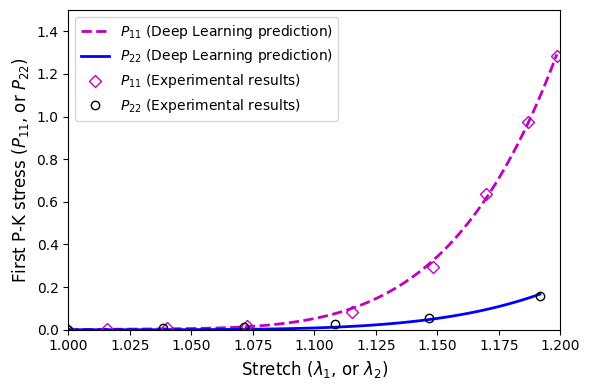

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === 1. Load prediction data ===
pred_df = pd.read_csv("prediction_data_.csv")

# Prediction curves
lambda1_pred = pred_df['lambda1_predicted']
P11_pred = pred_df['P11_predicted']
lambda2_pred = pred_df['lambda2_predicted']
P22_pred = pred_df['P22_predicted']

# === 2. Experimental results ===
p11_exp = np.array([
    [1.1986196319018403, 1.285990338164251],
    [1.18680981595092, 0.9768115942028984],
    [1.1699386503067484, 0.638647342995169],
    [1.1483128834355827, 0.29275362318840586],
    [1.1153374233128834, 0.08502415458937207],
    [1.0725460122699388, 0.018357487922705418],
    [1.040184049079755, 0.00869565217391316],
    [1.0157975460122703, 0.0019323671497585848],
    [1.0, 0.0]
])

p22_exp = np.array([
    [1.1917177914110426, 0.16038647342995177],
    [1.1464723926380367, 0.056038647342995296],
    [1.108435582822086, 0.028019323671497676],
    [1.071472392638037, 0.013526570048309317],
    [1.038343558282209, 0.006763285024154686],
    [1.0, 0.0]
])

# === 3. Plot ===
plt.figure(figsize=(6, 4))

# Model predictions
plt.plot(lambda1_pred, P11_pred, 'm--', linewidth=2, label=r'$P_{11}$ (Deep Learning prediction)')
plt.plot(lambda2_pred, P22_pred, 'b-', linewidth=2, label=r'$P_{22}$ (Deep Learning prediction)')

# Experimental results
plt.plot(p11_exp[:, 0], p11_exp[:, 1], marker='D', markersize=6,
         markerfacecolor='none', markeredgecolor='m', linestyle='None',
         label=r'$P_{11}$ (Experimental results)')
plt.plot(p22_exp[:, 0], p22_exp[:, 1], marker='o', markersize=6,
         markerfacecolor='none', markeredgecolor='k', linestyle='None',
         label=r'$P_{22}$ (Experimental results)')

# Labels and formatting
plt.xlabel(r'Stretch ($\lambda_1$, or $\lambda_2$)', fontsize=12)
plt.ylabel(r'First P-K stress ($P_{11}$, or $P_{22}$)', fontsize=12)
plt.xlim(1.0, 1.2)
plt.ylim(0, 1.5)
plt.legend(fontsize=10, loc='upper left')
plt.tight_layout()

plt.show()
